# Table of Contents
1. [Introduction](#introduction)
   1. [Problem Statement](#problem-statement)
   2. [Goal Setting](#goal-setting)
2. [Exploratory Data Analysis](#exploratory-data-analysis)
   1. [Data Ingestion and Understanding](#data-ingestion-and-understanding)
   2. [Univariate and Multivariate Feature Relationships](#univariate-and-multivariate-feature-relationships)
3. [Data Preprocessing](#data-preprocessing)
   1. [Feature Engineering](#feature-engineering)
   2. [Pipeline for Preprocessing](#pipeline-for-preprocessing)
   3. [Feature Selection](#feature-selection)
4. [Model Building](#model-building)
   1. [Choosing the Right Model](#choosing-the-right-model)
   2. [Training the Model](#training-the-model)
   3. [Cross-Validation](#cross-validation)
   4. [Model Evaluation](#model-evaluation)
   5. [Evaluation Metrics](#evaluation-metrics)
   6. [Root Mean Squared Error and R2 Score](#root-mean-squared-error-and-r2-score)
5. [Hyperparameter Tuning](#hyperparameter-tuning)
   1. [Grid Search](#grid-search)
   2. [Random Search](#random-search)
6. [Conclusion](#conclusion)

# Introduction
In today's dynamic real estate market, accurate house price prediction is crucial for various stakeholders:

- **Real Estate Agents**: Need reliable price estimates to advise clients effectively
- **Home Buyers**: Want to ensure they're making fair offers
- **Sellers**: Need to set competitive listing prices
- **Investors**: Require accurate valuations for investment decisions

## Problem Statement
This project implements a machine learning solution that analyzes various house features to predict market prices, helping stakeholders make data-driven decisions.

## Goal Setting
In today's dynamic real estate market, accurate house price prediction is crucial for various stakeholders:

- **Real Estate Agents**: Need reliable price estimates to advise clients effectively
- **Home Buyers**: Want to ensure they're making fair offers
- **Sellers**: Need to set competitive listing prices
- **Investors**: Require accurate valuations for investment decisions


# Exploratory Data Analysis

In [78]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
import seaborn as sns
import warnings
import os
from functools import lru_cache
from math import ceil
from itertools import zip_longest
from typing import List, Tuple, Union, Any
from scipy.stats import chi2_contingency
from itertools import combinations
from collections import defaultdict
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.feature_selection import r_regression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# Set style for plots
sns.set_style("whitegrid")
warnings.filterwarnings('ignore') 

# Define custom params for plots
rcParams = {
    'font.size': 20,                # all font sizes in plot
    'font.weight': 'bold',          # bold all fonts
    'figure.titleweight': 'bold',   # bold supertitle
    'axes.labelweight': 'bold',     # bold x and y labels
    'axes.linewidth': 3,            # linewidth for axes
    'xtick.major.width': 3,         # width for major ticks on x-axis
    'ytick.major.width': 3,         # width for major ticks on y-axis
    'axes.spines.top': True,
    'axes.spines.right': True,
    'lines.linewidth': 3,
    'legend.fontsize': 'large',
    'xtick.labelsize': 20,          # sets x-tick font size
    'ytick.labelsize': 20,          # sets y-tick font size
    'axes.titlepad': 20,            # spacing between title and figure
    'axes.facecolor': 'white',      # background color for axes
    'axes.titlesize': 20,           # title font size for axes
    'axes.titleweight': 'bold'      
}

# Update rcparams
mpl.rcParams.update(rcParams) 

## Data Ingestion and Understanding

In [2]:
# Construct the full path to the data file
def get_absolute_path(relative_path: str) -> str:
    """
    Returns the absolute path of a given relative path.
    
    Parameters:
    - relative_path (str): The relative path to the file.
    
    Returns:
    - str: The absolute path to the file.
    """
    return os.path.join(os.getcwd(), relative_path)

""" The lru_cache decorator is applied when defining the function, specifically at the time the 
function is decorated. So, when you define load_data and add @lru_cache, it wraps the function in 
a cache mechanism. When you later call the load_data function, it uses the cache if the same parameters
have been used before, thereby speeding up the process."""

@lru_cache
def load_data(file_path: str) -> pd.DataFrame:
    """
    Loads data from a specified file path and returns it as a pandas DataFrame.
    
    Parameters:
    - file_path (str): The path to the file to be loaded. The file must be in .csv or .xlsx format.
    
    Returns:
    - pd.DataFrame: The data loaded from the file or None if an error occurs.
    """
    absolute_file_path = get_absolute_path(file_path)
    try:
        if os.path.exists(absolute_file_path):
            if absolute_file_path.endswith(('.csv', '.xlsx')):
                if absolute_file_path.endswith('.csv'):
                    return pd.read_csv(absolute_file_path, sep=',', encoding='utf-8')
                else:
                    return pd.read_excel(absolute_file_path)
            else:
                raise ValueError("Incorrect format type. The file must be in .csv or .xlsx format.")
        else:
            raise FileNotFoundError(f"The file at {absolute_file_path} was not found.")
    except FileNotFoundError as fnf_error:
        print(fnf_error)
        return None
    except ValueError as val_error:
        print(val_error)
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

In [3]:
# Load real state and house pricing data
real_state = load_data(r'data/raw_data/Ames Real Estate Data.csv')
data = load_data(r'data/raw_data/AmesHousing.csv')

In [4]:
data.columns = data.columns.str.replace(' ', '')
data.shape

(2930, 81)

In [5]:
real_state.columns

Index(['MapRefNo', 'GeoRefNo', 'Tier', 'Range', 'Prop_Addr', 'ZngCdPr',
       'ZngCdSc', 'ZngOLPr', 'ZngOLSc', 'ClassPr_S', 'ClassSc_S', 'Legal_Pr',
       'SchD_S', 'TxD_S', 'MA_Ownr1', 'MA_Ownr2', 'MA_Line1', 'MA_Line2',
       'MA_City', 'MA_State', 'MA_Zip1', 'MA_Zip2', 'Rcrd_Yr', 'Rcrd_Mo',
       'Inst1_No', 'Inst1_Yr', 'Inst1_Mo', 'Inst1TPr', 'LndAc_S', 'ImpAc_S',
       'OthAc_S', 'TtlVal_AsrYr', 'ValType', 'X1TPr_D', 'X1TSc_D', 'X2TPr_D',
       'X2TSc_D', 'X1TPr_S', 'X1TSc_S', 'X2TPr_S', 'X2TSc_S', 'LndAcX1S',
       'ImpAcX1S', 'ImpAcX2S', 'HSTtl_D', 'MilVal_D', 'HSTtl_S', 'MilVal_S',
       'AcreX_S1', 'AcreGr', 'AcreNt_S', 'Neighborhood', 'LotArea', 'ParType',
       'BldgNo_S', 'DwlgNo_S', 'BldgType', 'YrBuilt', 'HouseStyle',
       'Foundation', 'RoofMatl', 'Ext1', 'Ext2', 'MasVnrType', 'Heating',
       'Central Air', 'GLA', 'TtlBsmtSF', 'TotRmsAbvGrd', 'Fireplaces',
       'PoolArea', 'GarageType', 'GarYrBlt', 'Cars', 'GarageArea',
       'YrSold_YYYY', 'MoSold_MM', '

In [6]:
# the house_price data already contains deatures from real_state
set(data.columns) & set(real_state.columns)

{'BldgType',
 'Fireplaces',
 'Foundation',
 'GarageArea',
 'GarageType',
 'Heating',
 'HouseStyle',
 'LotArea',
 'MasVnrType',
 'Neighborhood',
 'PoolArea',
 'RoofMatl',
 'SalePrice',
 'SaleType',
 'TotRmsAbvGrd'}

In [7]:
data.columns

Index(['PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDri

Summon the data described by De Cock (2011) where 81 fields were recorded for 2,580 properties in Ames IA.

From the data documentation reference, the columns include:

<ol>
<li>PID: Parcel identification number - can be used with city web site for parcel review.</li>
<li>MS SubClass: Identifies the type of dwelling involved in the sale.</li>
<li>MS Zoning: Identifies the general zoning classification of the sale.</li>
<li>Lot Frontage: Linear feet of street connected to property</li>
<li>Lot Area: Lot size in square feet</li>
<li>Street: Type of road access to property</li>
<li>Alley: Type of alley access to property</li>
<li>Lot Shape: General shape of property</li>
<li>Land Contour: Flatness of the property</li>
<li>Utilities: Type of utilities available</li>
<li>Lot Config: Lot configuration</li>
<li>Land Slope: Slope of property</li>
<li>Neighborhood: Physical locations within Ames city limits (map available)</li>
<li>Condition 1: Proximity to various conditions</li>
<li>Condition 2: Proximity to various conditions (if more than one is present)</li>
<li>Bldg Type: Type of dwelling</li>
<li>House Style: Style of dwelling</li>
<li>Overall Qual: Rates the overall material and finish of the house</li>
<li>Overall Cond: Rates the overall condition of the house</li>
<li>Year Built: Original construction date</li>
<li>Year Remod/Add: Remodel date (same as construction date if no remodeling or additions)</li>
<li>Roof Style: Type of roof</li>
<li>Roof Matl: Roof material</li>
<li>Exterior 1: Exterior covering on house</li>
<li>Exterior 2: Exterior covering on house (if more than one material)</li>
<li>Mas Vnr Type: Masonry veneer type</li>
<li>Mas Vnr Area: Masonry veneer area in square feet</li>
<li>Exter Qual: Evaluates the quality of the material on the exterior</li>
<li>Exter Cond: Evaluates the present condition of the material on the exterior</li>
<li>Foundation: Type of foundation</li>
<li>Bsmt Qual: Evaluates the height of the basement</li>
<li>Bsmt Cond: Evaluates the general condition of the basement</li>
<li>Bsmt Exposure: Refers to walkout or garden level walls</li>
<li>BsmtFin Type 1: Rating of basement finished area</li>
<li>BsmtFin SF 1: Type 1 finished square feet</li>
<li>BsmtFinType 2: Rating of basement finished area (if multiple types)</li>
<li>BsmtFin SF 2: Type 2 finished square feet</li>
<li>Bsmt Unf SF: Unfinished square feet of basement area</li>
<li>Total Bsmt SF: Total square feet of basement area</li>
<li>Heating: Type of heating</li>
<li>HeatingQC: Heating quality and condition</li>
<li>Central Air: Central air conditioning</li>
<li>Electrical: Electrical system</li>
<li>1st Flr SF: First Floor square feet</li>
<li>2nd Flr SF: Second floor square feet</li>
<li>Low Qual Fin SF: Low quality finished square feet (all floors)</li>
<li>Gr Liv Area: Above grade (ground) living area square feet</li>
<li>Bsmt Full Bath: Basement full bathrooms</li>
<li>Bsmt Half Bath: Basement half bathrooms</li>
<li>Full Bath: Full bathrooms above grade</li>
<li>Half Bath: Half baths above grade</li>
<li>Bedroom: Bedrooms above grade (does NOT include basement bedrooms)</li>
<li>Kitchen: Kitchens above grade</li>
<li>KitchenQual: Kitchen quality</li>
<li>TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)</li>
<li>Functional: Home functionality (Assume typical unless deductions are warranted)</li>
<li>Fireplaces: Number of fireplaces</li>
<li>FireplaceQu: Fireplace quality</li>
<li>Garage Type: Garage location</li>
<li>Garage Yr Blt: Year garage was built</li>
<li>Garage Finish: Interior finish of the garage</li>
<li>Garage Cars: Size of garage in car capacity</li>
<li>Garage Area: Size of garage in square feet</li>
<li>Garage Qual: Garage quality</li>
<li>Garage Cond: Garage condition</li>
<li>Paved Drive: Paved driveway</li>
<li>Wood Deck SF: Wood deck area in square feet</li>
<li>Open Porch SF: Open porch area in square feet</li>
<li>Enclosed Porch: Enclosed porch area in square feet</li>
<li>3-Ssn Porch: Three season porch area in square feet</li>
<li>Screen Porch: Screen porch area in square feet</li>
<li>Pool Area: Pool area in square feet</li>
<li>Pool QC: Pool quality</li>
<li>Fence: Fence quality</li>
<li>Misc Feature: Miscellaneous feature not covered in other categories</li>
<li>Misc Val: $Value of miscellaneous feature</li>
<li>Mo Sold: Month Sold</li>
<li>Yr Sold: Year Sold</li>
<li>Sale Type: Type of sale</li>
<li>Sale Condition: Condition of sale</li>
<li>SalePrice
</ol>


In [8]:
def plot_null_counts(df: pd.DataFrame, top_n: int = 10) -> pd.DataFrame:
    """
    Plots the top features with the highest percentage of null values in a DataFrame 
    and returns a DataFrame with the null value information.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - top_n (int): The number of top features to plot based on the percentage of null values. Default is 10.
    
    Returns:
    - pd.DataFrame: A DataFrame containing the features, number of null values, and percentage of null values.
    """
    null_info = pd.DataFrame({
        'features': df.isnull().sum().index, 
        'num_null_values': df.isnull().sum().values,
        'percent_null_values': df.isnull().sum().values * 100. / df.shape[0]
    }).sort_values(by='percent_null_values', ascending=False).reset_index(drop=True)

    null_info = null_info.loc[null_info['num_null_values'] > 0].head(top_n)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.barplot(data=null_info, y='features', x='percent_null_values', ax=ax)
    plt.suptitle(f"Top {top_n} Features with the Highest Percentage of Null Values")
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.xlabel("% Null Values")
    plt.ylabel(None)
    return 

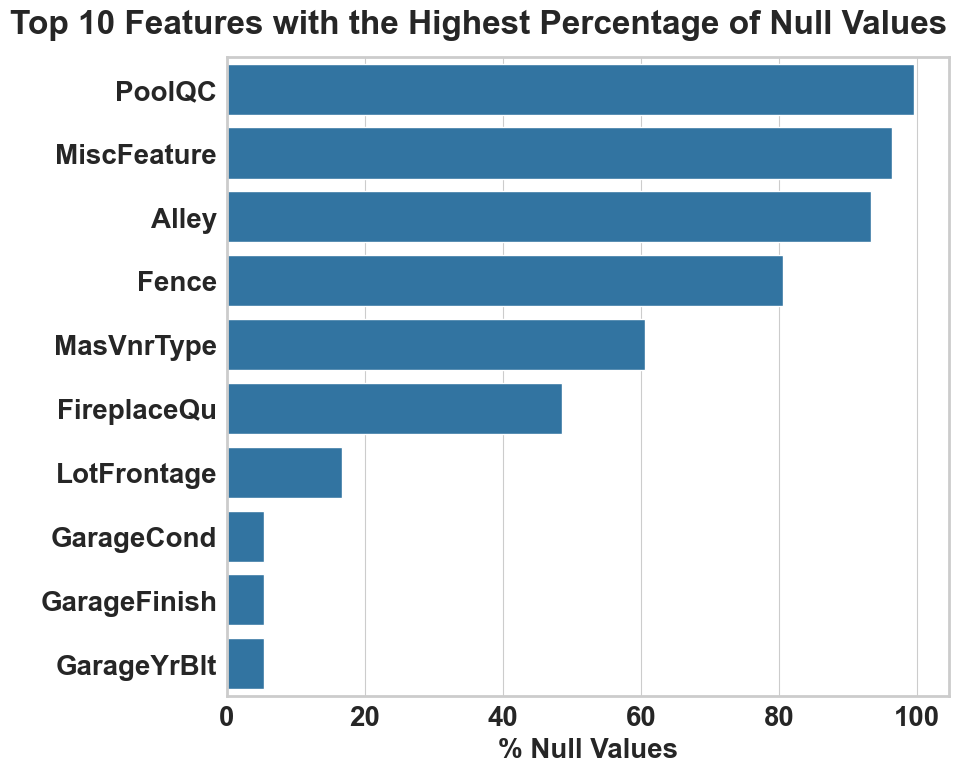

In [9]:
plot_null_counts(data)

## Univariate and Multivariate Feature Relationships

In [10]:
target_name = "SalePrice"
X, y = (
    data.drop(columns = [target_name, 'PID']),
    data[target_name]
)

<Axes: ylabel='Frequency'>

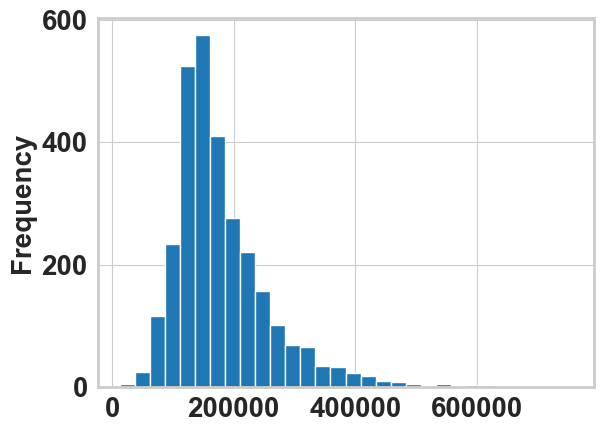

In [11]:
y.plot.hist(bins = 30)

In [12]:
numerical_data = data.select_dtypes(include = "number")
numerical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PID            2930 non-null   int64  
 1   MSSubClass     2930 non-null   int64  
 2   LotFrontage    2440 non-null   float64
 3   LotArea        2930 non-null   int64  
 4   OverallQual    2930 non-null   int64  
 5   OverallCond    2930 non-null   int64  
 6   YearBuilt      2930 non-null   int64  
 7   YearRemod/Add  2930 non-null   int64  
 8   MasVnrArea     2907 non-null   float64
 9   BsmtFinSF1     2929 non-null   float64
 10  BsmtFinSF2     2929 non-null   float64
 11  BsmtUnfSF      2929 non-null   float64
 12  TotalBsmtSF    2929 non-null   float64
 13  1stFlrSF       2930 non-null   int64  
 14  2ndFlrSF       2930 non-null   int64  
 15  LowQualFinSF   2930 non-null   int64  
 16  GrLivArea      2930 non-null   int64  
 17  BsmtFullBath   2928 non-null   float64
 18  BsmtHalf

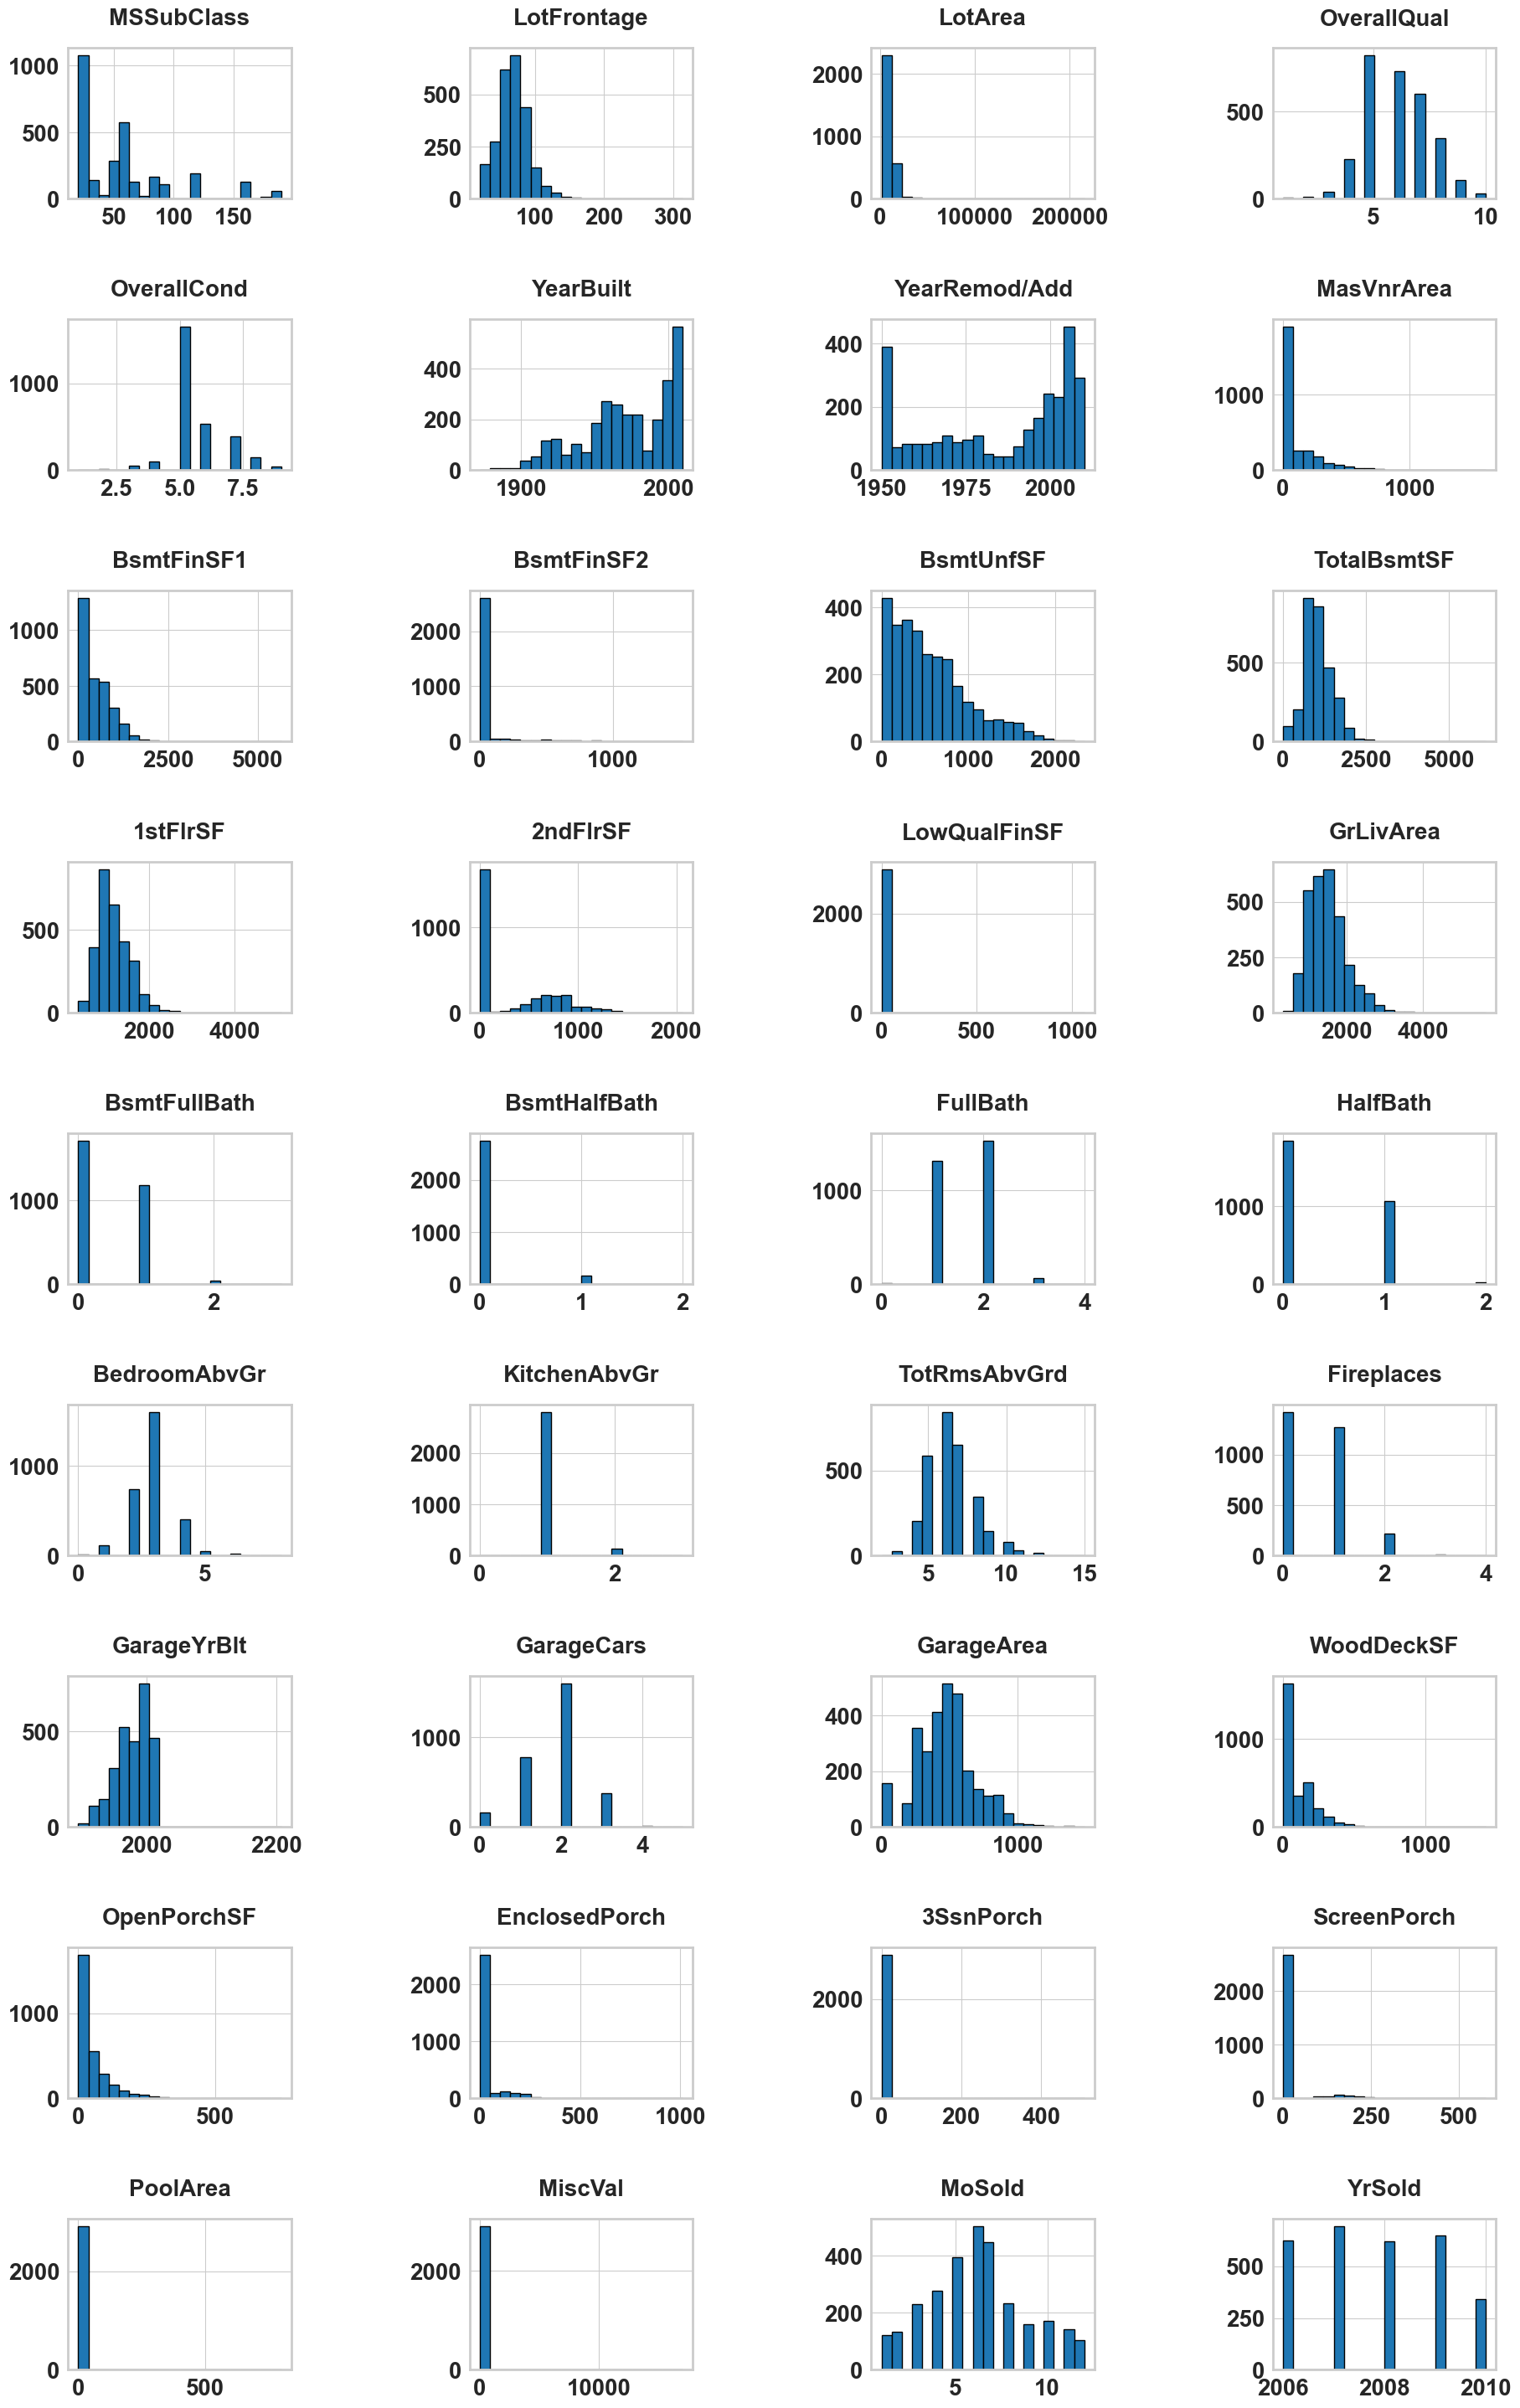

In [13]:
def plot_univariate_numerical_features(df: pd.DataFrame, nrow: int = 9, ncol: int = 4, figsize: tuple = (22, 36), bins: int = 20) -> None:
    """
    Plots histograms for univariate numerical features in a DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data to be plotted.
    - nrow (int, optional): Number of rows in the subplot grid. Default is 9.
    - ncol (int, optional): Number of columns in the subplot grid. Default is 4.
    - figsize (tuple, optional): Size of the figure. Default is (22, 36).
    - bins (int, optional): Number of bins for the histogram. Default is 20.
    
    Returns:
    - None
    """
    
    numerical_data = df.select_dtypes(include=['number'])
    
    numerical_data.hist(
        bins=bins, figsize=figsize, edgecolor="black", layout=(nrow, ncol)
    )
    plt.subplots_adjust(hspace=0.8, wspace=0.8)

plot_univariate_numerical_features(X)


In [14]:
string_data = data.select_dtypes(object)
string_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       2930 non-null   object
 1   Street         2930 non-null   object
 2   Alley          198 non-null    object
 3   LotShape       2930 non-null   object
 4   LandContour    2930 non-null   object
 5   Utilities      2930 non-null   object
 6   LotConfig      2930 non-null   object
 7   LandSlope      2930 non-null   object
 8   Neighborhood   2930 non-null   object
 9   Condition1     2930 non-null   object
 10  Condition2     2930 non-null   object
 11  BldgType       2930 non-null   object
 12  HouseStyle     2930 non-null   object
 13  RoofStyle      2930 non-null   object
 14  RoofMatl       2930 non-null   object
 15  Exterior1st    2930 non-null   object
 16  Exterior2nd    2930 non-null   object
 17  MasVnrType     1155 non-null   object
 18  ExterQual      2930 non-null

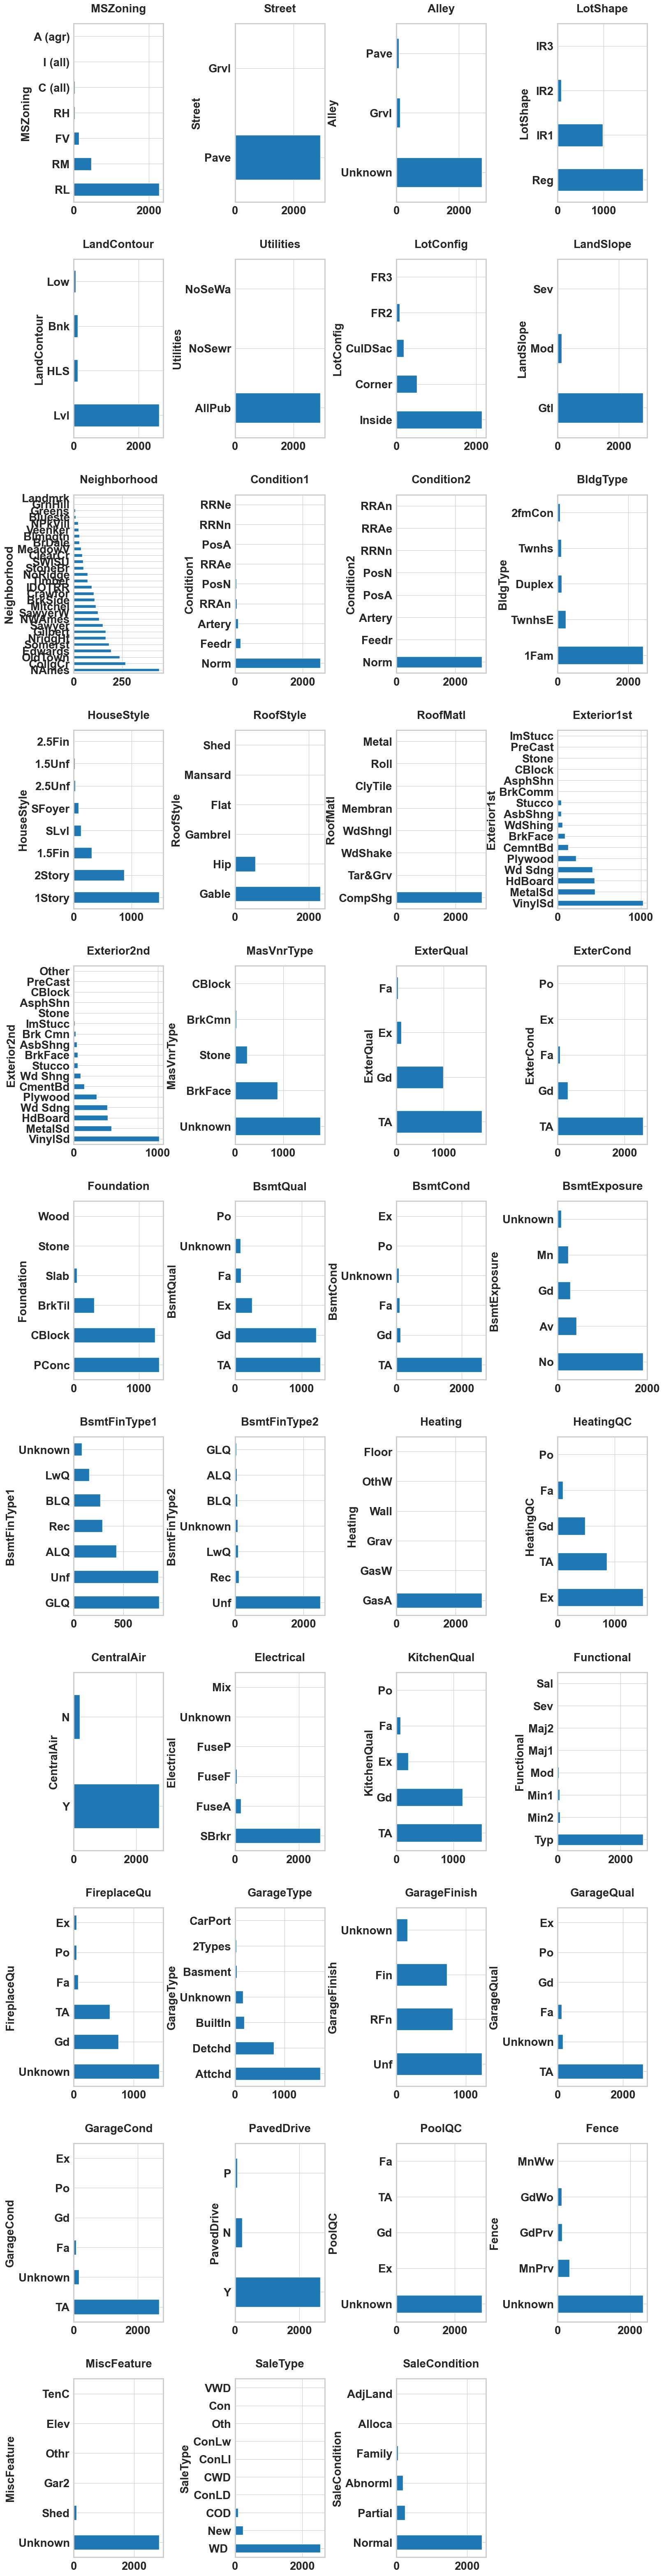

In [15]:
def plot_categorical_features(df: pd.DataFrame, ncol: int = 4, figsize: tuple = (18, 80)) -> None:
    """
    Plots bar charts for categorical features in a DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data to be plotted.
    - ncol (int, optional): Number of columns in the subplot grid. Default is 4.
    - figsize (tuple, optional): Size of the figure. Default is (18, 80).
    
    Returns:
    - None
    """
    string_data = df.select_dtypes(include=['object']).fillna('Unknown')
    n_string_features = string_data.shape[1]
    nrows = ceil(n_string_features / ncol)
    
    fig, axs = plt.subplots(ncols=ncol, nrows=nrows, figsize=figsize)
    
    for feature_name, ax in zip_longest(string_data, axs.flatten()):
        if feature_name is None:
            # do not show the axis
            ax.axis("off")
            continue
        
        string_data[feature_name].value_counts().plot.barh(ax=ax)
        ax.set_title(feature_name)
    
    plt.subplots_adjust(hspace = 0.32, wspace = 0.8)

# Example usage:
plot_categorical_features(X)

In [16]:
def plot_target_by_cat_features(df: pd.DataFrame, column: str, target: str = 'SalePrice', top_n: int = 10) -> None:
    """
    Visualizes the relationship between a categorical feature and a target variable.

    This function fills missing values in the specified categorical column with 'Unknown' and 
    generates a boxplot and a violin plot to show the distribution and spread of the target variable 
    across different categories of the specified feature. If the number of categories exceeds top_n,
    only the top_n categories are displayed and sorted from high to low based on the median target variable.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    column (str): The name of the categorical column to be plotted.
    target (str, optional): The name of the target variable to be plotted. Default is 'SalePrice'.
    top_n (int, optional): The number of top categories to display. Default is 10.

    Returns:
    None: The function generates plots and does not return any value.

    Notes:
    - The function fills missing values in the specified categorical column with the string 'Unknown' 
    to ensure all data is included in the plots.
    - The color palette used is 'tab20' from the Seaborn library, which provides a variety of colors 
    for distinguishing different categories.
    - The function creates two subplots: a boxplot and a violin plot, providing a comprehensive view of 
    the data distribution and spread.
    """
    # Make a copy of the DataFrame
    data = df.copy()
    
    # Fill missing values in the categorical column with 'Unknown'
    data[column] = data[column].fillna('Unknown')
    
    # Limit to top_n categories based on median target value
    category_medians = data.groupby(column)[target].median().sort_values(ascending=False)
    top_categories = category_medians.index[:top_n]
    data = data[data[column].isin(top_categories)]
    
    # Sort the categorical column by median target value
    data[column] = pd.Categorical(data[column], categories=top_categories, ordered=True)
    
    # Define a color palette
    palette = sns.color_palette('tab20', n_colors=top_n)
    
    # Create subplots
    fig, ax = plt.subplots(1, 2, figsize = (18, 10), sharey = True, sharex = True)
    
    # Plot a boxplot
    sns.boxplot(data=data, x=target, y=column, palette=palette, ax=ax[0])
    ax[0].set_ylabel('')
    ax[0].set_xlabel("Sales Price [USD]")
    
    # Plot a violin plot
    sns.violinplot(data=data, x=target, y=column, hue=column, palette=palette, ax=ax[1])
    ax[1].set_ylabel('')
    ax[1].set_xlabel("Sales Price [USD]")
    
    # Set a common super-title
    plt.suptitle(f'Sales Price of Homes Available by Top {top_n} {column} in Ames City')
    
    # Minimize horizontal space between figures
    plt.subplots_adjust(wspace=0.02, top = 0.95)
    
    # Rotate x-axis labels if needed
    for axes in ax:
        axes.set_xticklabels(axes.get_xticklabels(), rotation= 0, ha = 'right')
    
    # set right and left spines invisible for ax[0] and ax[1]
    ax[0].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)

    # Show the plots
    plt.show()

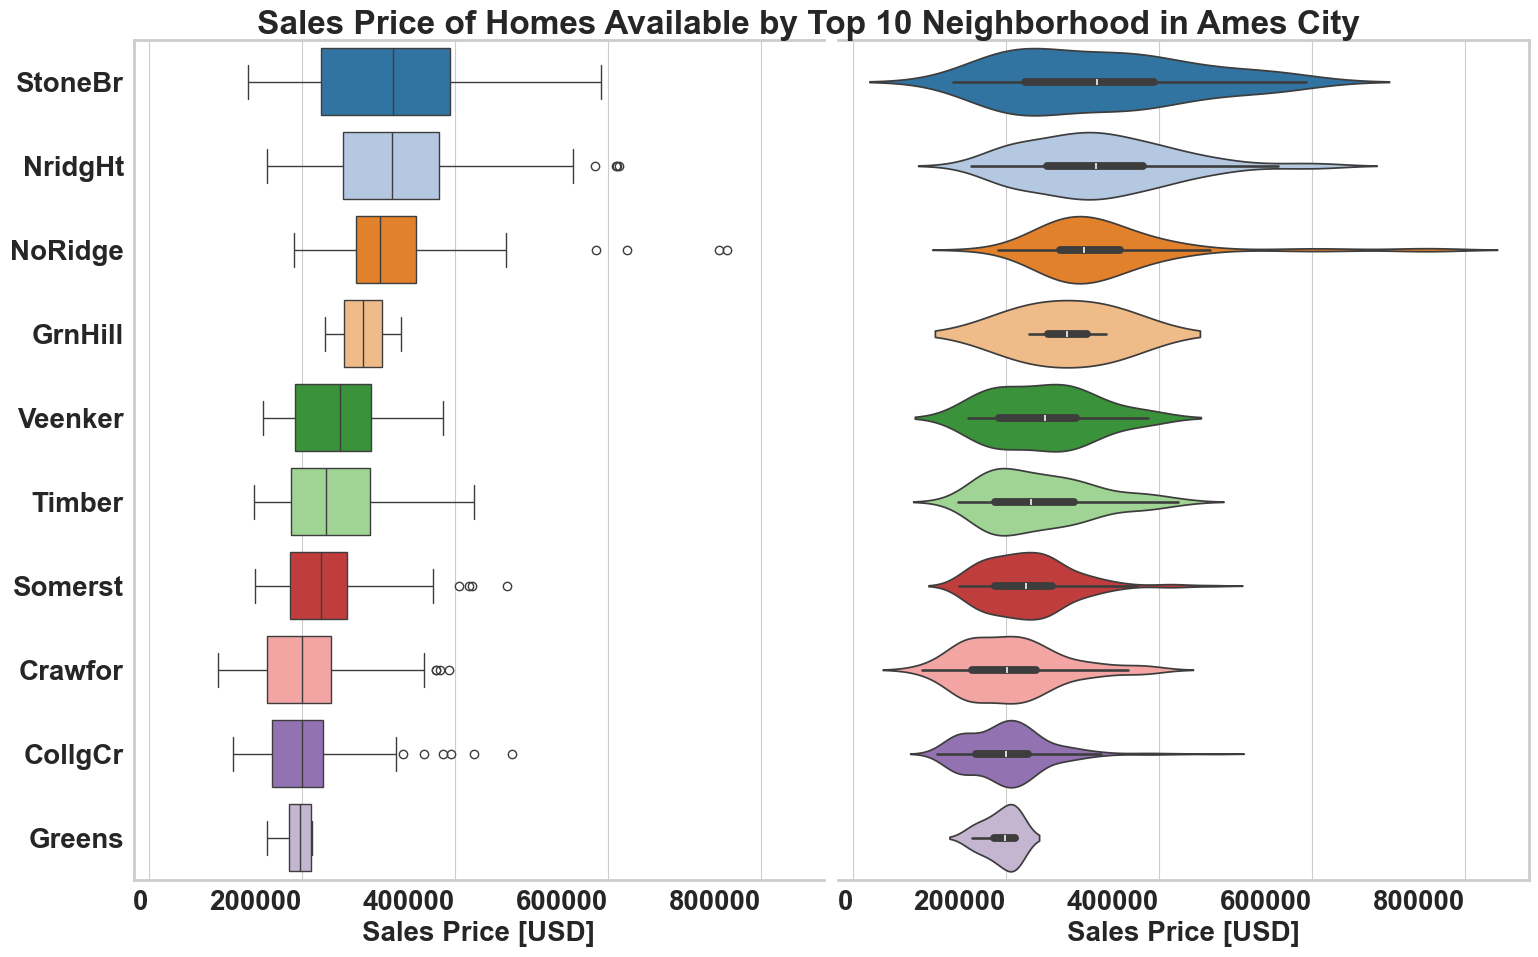

In [17]:
plot_target_by_cat_features(data, 'Neighborhood')

In [18]:
data.columns

Index(['PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDri

<Figure size 1400x800 with 0 Axes>

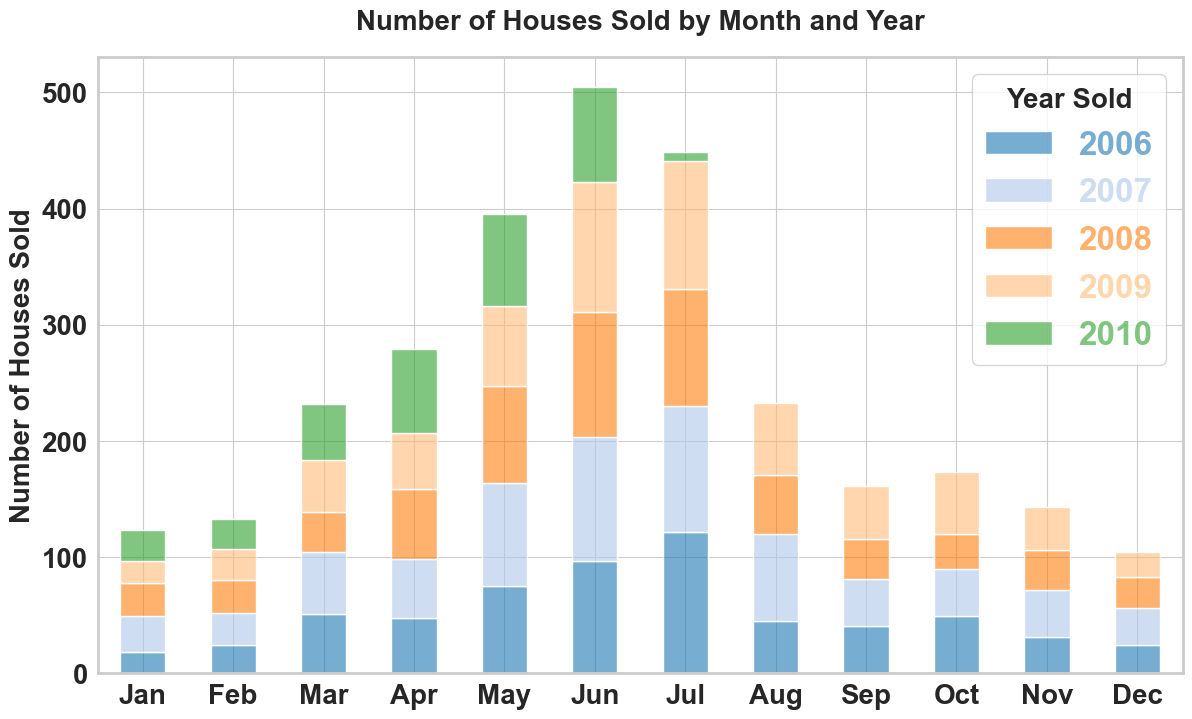

In [19]:
# Group by 'YrSold' and 'MoSold', count and unstack
grouped = X.groupby(['MoSold', 'YrSold']).size().unstack().fillna(0)

# Map month numbers to month names in the columns
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
grouped.index = grouped.index.map(month_names)

# Define a color palette
palette = sns.color_palette('tab20', n_colors = grouped.shape[1])
palette_with_alpha = [(r, g, b, 0.6) for r, g, b in palette]

# Create the plot
plt.figure(figsize=(14, 8))
ax = grouped.plot(kind='bar', stacked=True, figsize=(14, 8), rot = 0, color = palette_with_alpha)

# Set plot title and labels
plt.title('Number of Houses Sold by Month and Year', fontweight = 'bold')
plt.xlabel('')
plt.ylabel('Number of Houses Sold')

# set legend title and color
plt.legend(labelcolor = 'linecolor', title = 'Year Sold')
# Show the plot
plt.show()


In [20]:
def cramers_v(x, y):
    """Calculate Cramér's V for two categorical variables."""
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    minDim = min(confusion_matrix.shape) - 1
    V = np.sqrt((chi2 / n) / minDim)
    return V, p

def filter_strong_associations(df, cramer_threshold = 0.3, p_value_threshold = 0.05):
    """
    Calculate Cramér's V and chi-squared test for each pair of categorical features and 
    return a DataFrame with pairs that have a Cramér's V value greater than cramer_threshold 
    and p-value less than p_value_threshold.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the features.
    cramer_threshold (float, optional): The threshold for Cramér's V value. Default is 0.1.
    p_value_threshold (float, optional): The threshold for p-value. Default is 0.05.
    
    Returns:
    pd.DataFrame: A DataFrame with pairs of columns, Cramér's V values, and p-values.
    """
    categorical_columns = df.select_dtypes(include=['object']).columns
    results = []

    for col1, col2 in combinations(categorical_columns, 2):
        V, p = cramers_v(df[col1].fillna('Unknown'), df[col2].fillna('Unknown'))
        if V > cramer_threshold and p < p_value_threshold:
            results.append({'Column1': col1, 'Column2': col2, 'Cramér\'s V': V, 'p-value': p})
    
    results_df = pd.DataFrame(results)
    return results_df

# Example usage
strong_associations = filter_strong_associations(X)
print(strong_associations)

       Column1        Column2  Cramér's V        p-value
0     MSZoning         Street    0.350307   1.370346e-74
1     MSZoning          Alley    0.419472  3.839313e-213
2     MSZoning      Utilities    0.353416  6.409168e-149
3     MSZoning   Neighborhood    0.543881   0.000000e+00
4        Alley   Neighborhood    0.480565  1.350636e-247
..         ...            ...         ...            ...
73  GarageQual     GarageCond    0.627809   0.000000e+00
74  GarageQual     PavedDrive    0.309125  6.577725e-114
75  GarageCond     PavedDrive    0.330620  3.573558e-131
76      PoolQC    MiscFeature    0.353545  1.328319e-298
77    SaleType  SaleCondition    0.472634   0.000000e+00

[78 rows x 4 columns]


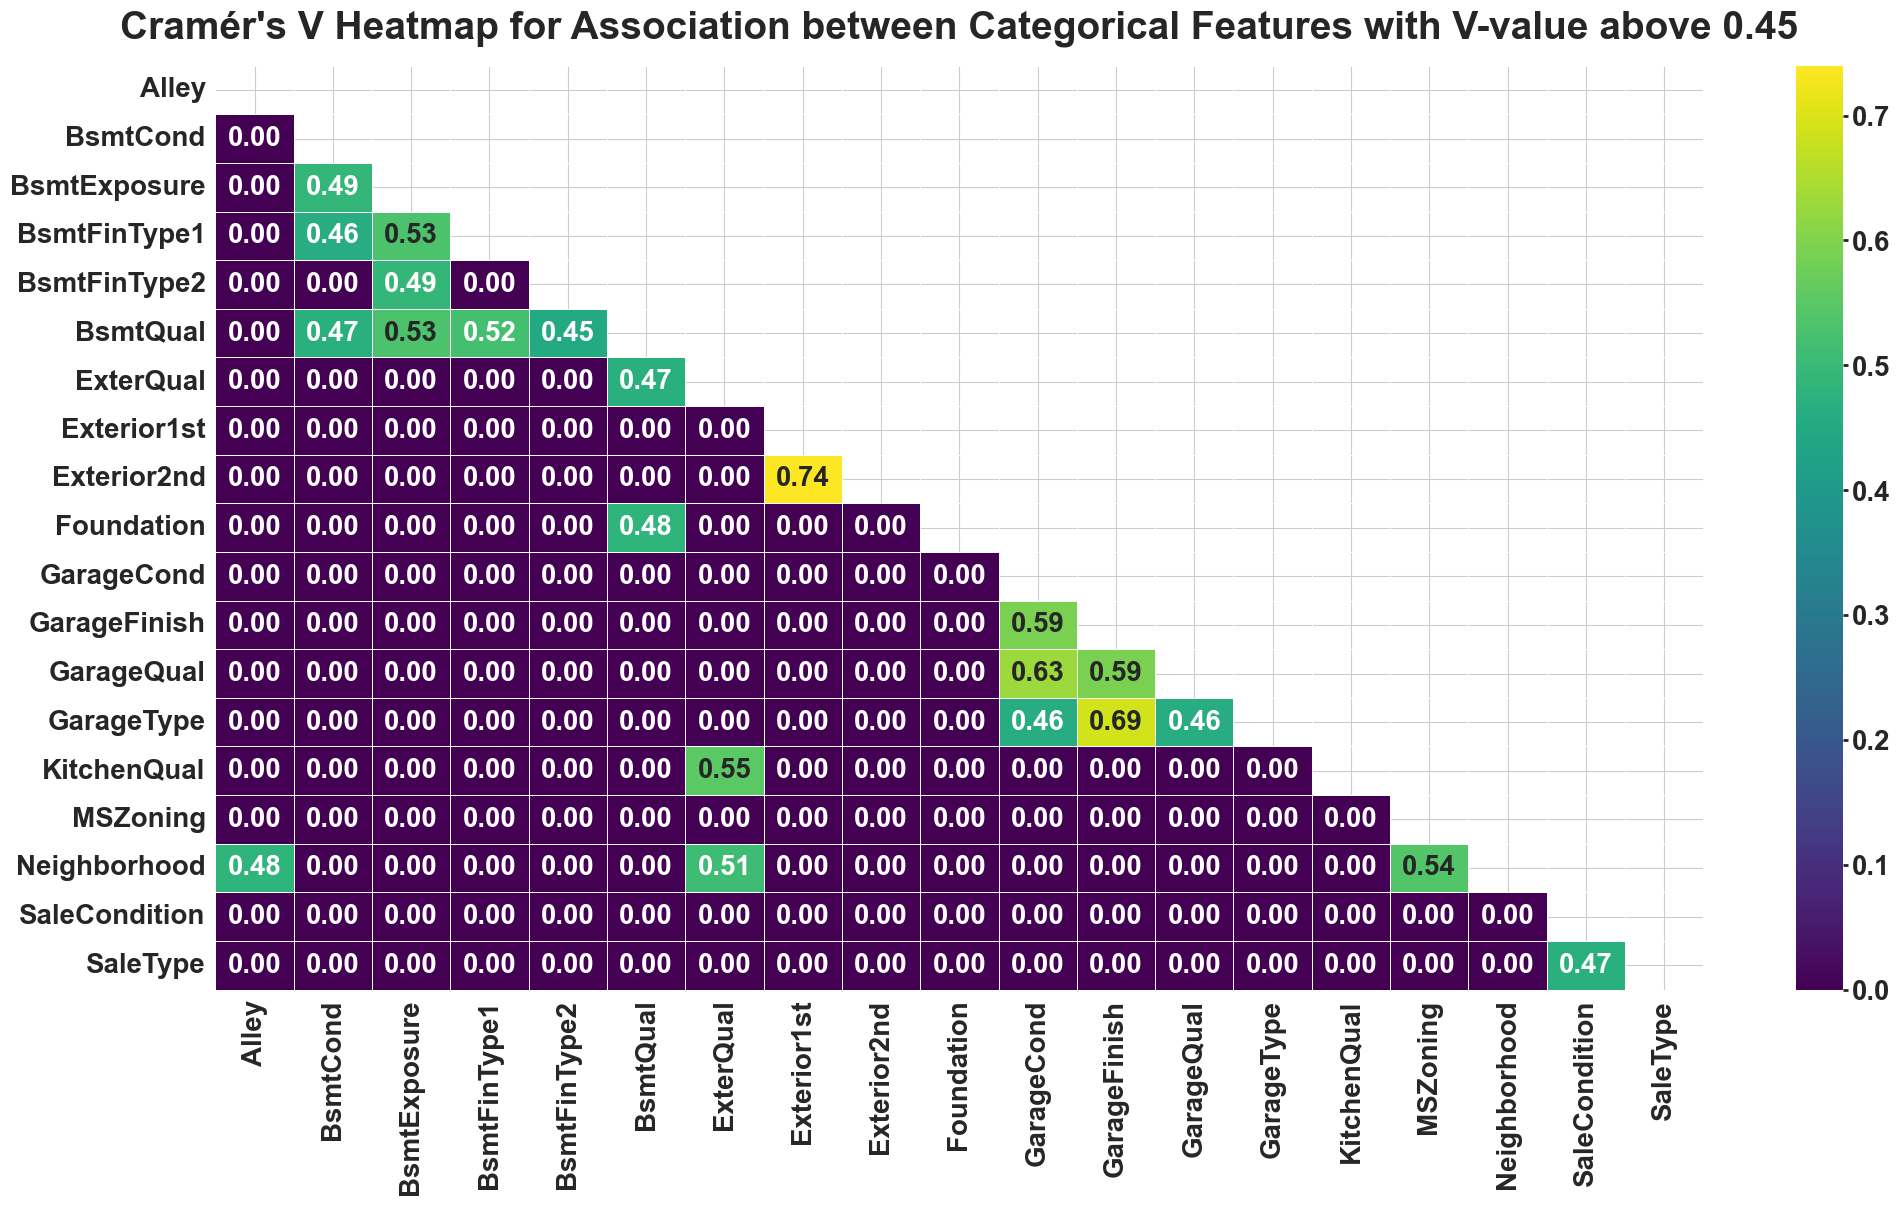

In [21]:
def calculate_cramers_v_matrix(df, cramer_v_threshold = 0.3):
    """
    Calculate the Cramér's V matrix for all pairs of categorical features.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the features.
    cramer_v_threshold (float, optional): The threshold for filtering Cramér's V values.
    
    Returns:
    pd.DataFrame: A DataFrame with Cramér's V values for each pair of categorical features that pass the threshold.
    """
    categorical_columns = df.select_dtypes(include=['object']).columns
    cramers_v_dict = defaultdict(dict)

    for col1, col2 in combinations(categorical_columns, 2):
        V, _ = cramers_v(df[col1].fillna('Unknown'), df[col2].fillna('Unknown'))
        if V >= cramer_v_threshold:
            cramers_v_dict[col1][col2] = round(V, 2)
            cramers_v_dict[col2][col1] = round(V, 2)  # Mirror the value across the diagonal

    # Convert defaultdict to DataFrame
    cramers_v_matrix = pd.DataFrame(cramers_v_dict).fillna(0)  # Fill missing values with 0

    # Ensure the order of columns and index are the same
    cramers_v_matrix = cramers_v_matrix.reindex(sorted(cramers_v_matrix.columns), axis=0)
    cramers_v_matrix = cramers_v_matrix.reindex(sorted(cramers_v_matrix.columns), axis=1)
    
    # Create mask for the upper triangle
    mask = np.triu(np.ones_like(cramers_v_matrix, dtype=bool))

    return cramers_v_matrix.astype(float), mask  # Ensure all values are float and return mask

# Example usage
cramer_v_threshold = 0.45
cramers_v_matrix, mask = calculate_cramers_v_matrix(X, cramer_v_threshold = cramer_v_threshold)

# Plot the heatmap
plt.figure(figsize = (24, 12))
sns.heatmap(cramers_v_matrix, annot = True, cmap = 'viridis', linewidths = .5, fmt='.2f', mask=mask)
plt.title(f"Cramér's V Heatmap for Association between Categorical Features with V-value above {cramer_v_threshold}", fontsize = 28)
plt.show()

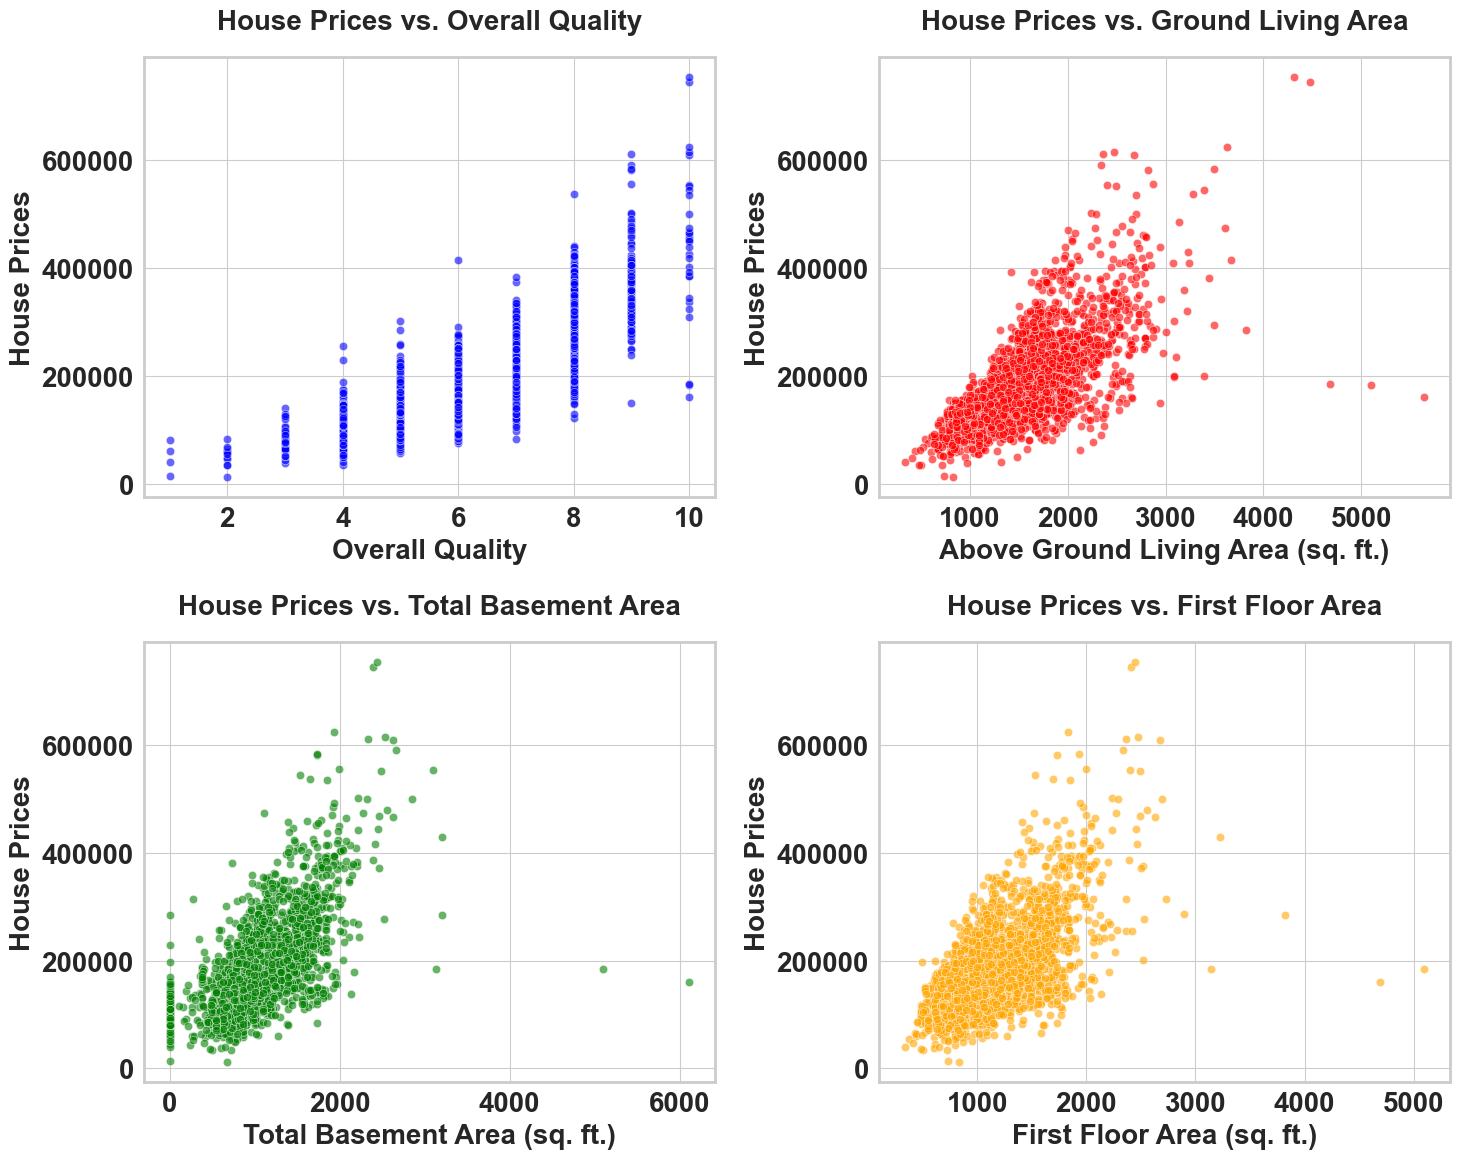

In [22]:
# Setting up the figure and axes
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

palette = ['blue', 'red', 'green', 'orange']
# Scatter plot for SalePrice vs. OverallQual
sns.scatterplot(x= data['OverallQual'], y= y, ax=ax[0, 0], color= palette[0], alpha=0.6)
ax[0, 0].set_title('House Prices vs. Overall Quality')
ax[0, 0].set_ylabel('House Prices')
ax[0, 0].set_xlabel('Overall Quality')
 
# Scatter plot for SalePrice vs. GrLivArea
sns.scatterplot(x=data['GrLivArea'], y= y, ax=ax[0, 1], color = palette[1], alpha=0.6)
ax[0, 1].set_title('House Prices vs. Ground Living Area')
ax[0, 1].set_ylabel('House Prices')
ax[0, 1].set_xlabel('Above Ground Living Area (sq. ft.)')
 
# Scatter plot for SalePrice vs. TotalBsmtSF
sns.scatterplot(x=data['TotalBsmtSF'], y= y, ax=ax[1, 0], color= palette[2], alpha=0.6)
ax[1, 0].set_title('House Prices vs. Total Basement Area')
ax[1, 0].set_ylabel('House Prices')
ax[1, 0].set_xlabel('Total Basement Area (sq. ft.)')
 
# Scatter plot for SalePrice vs. 1stFlrSF
sns.scatterplot(x=data['1stFlrSF'], y= y, ax=ax[1, 1], color= palette[3], alpha=0.6)
ax[1, 1].set_title('House Prices vs. First Floor Area')
ax[1, 1].set_ylabel('House Prices')
ax[1, 1].set_xlabel('First Floor Area (sq. ft.)')
 
# Adjust layout
plt.tight_layout()
plt.show()

## Data Preprocessing

Lets look percentage of possible outliers for contamination factor IsolationForest (the default is auto as defined by original research paper).

In [23]:
def calculate_outlier_percentage(df: pd.DataFrame, lower_percentile: float = 1, upper_percentile: float = 99) -> pd.DataFrame:
    """
    Calculates the percentage of outliers based on winsorization for all numerical variables in the DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    lower_percentile (float, optional): The lower percentile for winsorization. Default is 5.
    upper_percentile (float, optional): The upper percentile for winsorization. Default is 95.

    Returns:
    pd.DataFrame: A DataFrame containing the column names and the percentage of outliers.
    """
    outlier_percentages = {}

    numerical_cols = df.select_dtypes(include=[np.number]).columns

    for col in numerical_cols:
        x_low, x_high = np.percentile(df[col].dropna(), [lower_percentile, upper_percentile])
        total_values = len(df[col])
        outliers = len(df[~df[col].between(x_low, x_high)])
        outlier_percentage = round((outliers / total_values) * 100, 2)
        outlier_percentages[col] = outlier_percentage

    outlier_df = pd.DataFrame(list(outlier_percentages.items()), columns=['Numerical Features', 'Outliers Percentage'])
    return outlier_df

# Example usage
outlier_percentages = calculate_outlier_percentage(data)
print(outlier_percentages.sort_values(by = 'Outliers Percentage', ascending = False).reset_index(drop = True))

   Numerical Features  Outliers Percentage
0         LotFrontage                17.58
1         GarageYrBlt                 6.38
2                 PID                 2.05
3           GrLivArea                 2.05
4           SalePrice                 2.05
5            1stFlrSF                 2.01
6           YearBuilt                 1.84
7          MasVnrArea                 1.81
8             LotArea                 1.67
9        TotRmsAbvGrd                 1.57
10         GarageArea                 1.06
11         BsmtFinSF1                 1.06
12         BsmtFinSF2                 1.06
13          BsmtUnfSF                 1.06
14        TotalBsmtSF                 1.06
15        OpenPorchSF                 1.02
16         WoodDeckSF                 1.02
17       BedroomAbvGr                 1.02
18        ScreenPorch                 1.02
19           2ndFlrSF                 1.02
20            MiscVal                 1.02
21       LowQualFinSF                 1.02
22         

### Automated Pipelines
Although Scikit learn comes loaded with a set of standard transformers, we will begin with a custom one to understand what they do and how they work. The first thing to remember is that a custom transformer is an estimator and a transformer, so we will create a class that inherits from both BaseEstimator and TransformerMixin. It is a good practice to initialize it with super().__init__(). By inheriting, we get a standard method such as get_params and set_params for free. In the init, we also want to create the model parameter or parameters we want to learn.

<a href = "https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-ef792bbb3260">ref1</a>

<a href = "https://stackoverflow.com/questions/64900801/implementing-knn-imputation-on-categorical-variables-in-an-sklearn-pipeline">ref2</a>

<a href = "https://www.superannotate.com/blog/how-to-optimize-machine-learning-pipeline#:~:text=A%20machine%20learning%20pipeline%20otherwise,a%20fully%2Dfunctioning%20ML%20pipeline.">Automated Pipeline</a>



In [24]:
def fill_missing_values(df, cat_threshold = 0.5):
    """
    Fills missing values in a DataFrame for both categorical and numerical columns based on specific rules.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame with missing values.
    cat_threshold : float, optional (default = 0.5 percentage)
        The threshold for handling missing values in categorical columns.
        - If the percentage of missing values in a categorical column is less than `cat_threshold`, 
        fill with the most frequent value.
        - If it exceeds the threshold, fill with the category 'Unknown'.

    Returns:
    --------
    pd.DataFrame
        A DataFrame with no missing values.
        
    Rules for filling missing values:
    1. Categorical columns:
        - If missing values are less than `cat_threshold`, fill with the most frequent category.
        - If greater than the threshold, fill with 'Unknown'.
    2. LotFrontage and GarageYrBlt columns:
        - Fill using groupby medians based on relevant related columns.
    3. Other numeric columns:
        - Fill missing values with the overall median of the column.
    """

    # Make a copy of the original DataFrame
    data = df.copy()

    # Handle missing values in categorical columns
    for col in data.select_dtypes(include=['object', 'category']).columns:
        missing_ratio = data[col].isnull().mean() * 100.
        if missing_ratio > cat_threshold:
            data[col] = data[col].fillna('Unknown')
        else:
            data[col] = data[col].fillna(data[col].mode()[0])

    # Handle LotFrontage with groupby median imputation
    if 'LotFrontage' in data.columns:
        data['LotFrontage'] = data.groupby(['HouseStyle', 'Neighborhood', 'BldgType', 
        'LandContour', 'LotConfig'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # Handle GarageYrBlt with groupby median imputation
    if 'GarageYrBlt' in data.columns:
        data['GarageYrBlt'] = data.groupby(['YearBuilt', 'GarageType', 'Neighborhood'])['GarageYrBlt'].transform(lambda x: x.fillna(x.median()))

    # Handle other numeric columns with median imputation
    for col in data.select_dtypes(include=['number']).columns:
        if data[col].isnull().sum() > 0:
            data[col] = data[col].fillna(data[col].median())

    return data


In [25]:
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.means_ = None
        self.std_ = None

    def fit(self, X, y=None):
        X = X.to_numpy()
        self.means_ = X.mean(axis=0, keepdims=True)
        self.std_ = X.std(axis=0, keepdims=True)

        return self

    def transform(self, X, y=None):
        X[:] = (X.to_numpy() - self.means_) / self.std_

        return X

In [26]:
data.columns

Index(['PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDri

### Feature Engineering

In [27]:
# Create new features
X['TotalSqFt'] = X['GrLivArea'] + X['TotalBsmtSF']
X['YrRemodAge'] = X['YrSold'] - X['YearRemod/Add']
X['HouseAge'] = 2010 - X['YearBuilt']
X['GarageAge'] = 2010 - X['GarageYrBlt']
X['TotalBaths'] = X['FullBath'] + 0.5 * X['HalfBath'] + X['BsmtFullBath'] + 0.5 * X['BsmtHalfBath']

### Split the data set into train and test set

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

In [29]:
X_train = fill_missing_values(X_train)

### Feature Selection

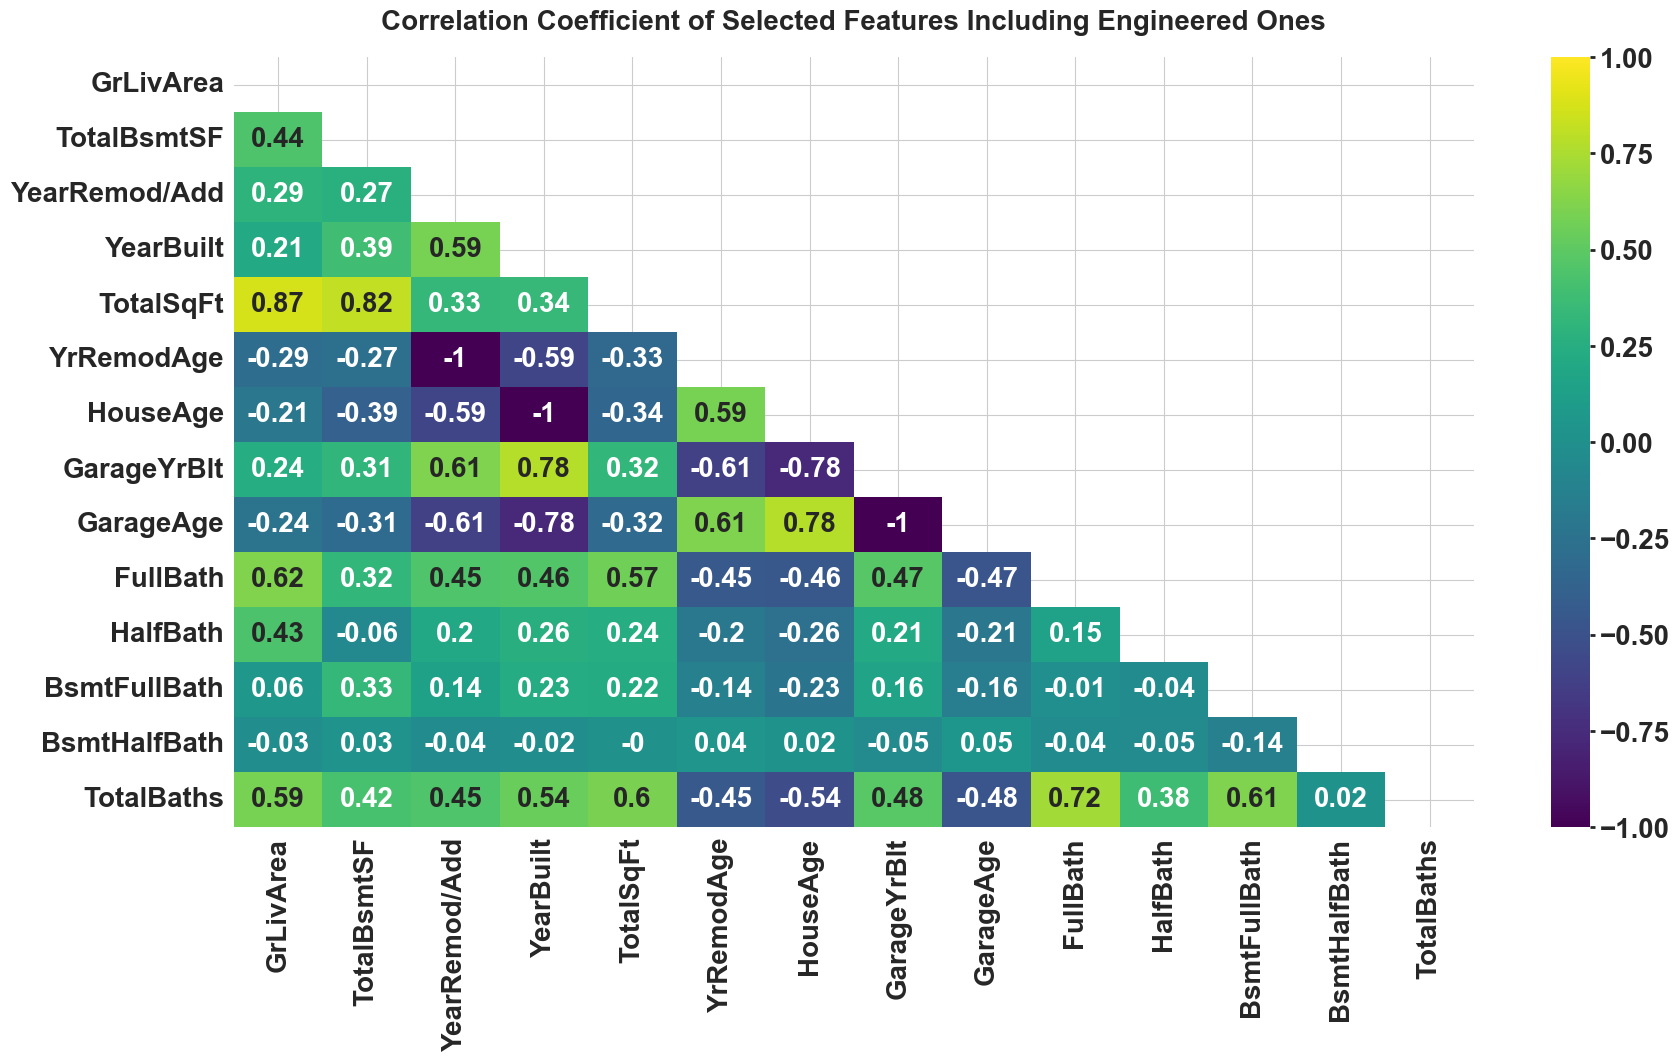

In [80]:
# Select old and new features
selected_features = ['GrLivArea', 'TotalBsmtSF', 'YearRemod/Add', 'YearBuilt', 'TotalSqFt', 'YrRemodAge', 'HouseAge',
                     'GarageYrBlt', 'GarageAge', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBaths']

# Compute the correlations for the selected features
corr_matrix = X_train[selected_features].corr().round(2)

# Generate a mask to only show the bottom triangle
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

# Generate the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot = True, mask = mask, vmin = -1, vmax = 1, cmap = 'viridis')
plt.title('Correlation Coefficient of Selected Features Including Engineered Ones')
plt.show()

## Top-n Categorical Features

In [81]:
X_train_new = X_train.drop(columns = ['GrLivArea', 'TotalBsmtSF', 'YearRemod/Add', 'YearBuilt', 'GarageYrBlt', 
                            'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'])
X_test_new = X_test.drop(columns = ['GrLivArea', 'TotalBsmtSF', 'YearRemod/Add', 'YearBuilt', 'GarageYrBlt', 
                            'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'])

In [122]:
def anova_tests(df: pd.DataFrame, target: Union[str, pd.Series]) -> pd.DataFrame:
    """
    Perform ANOVA tests to assess the relationship between categorical inputs and a numerical target.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    target (str or pd.Series): The name of the numerical target column or a standalone Series.

    Returns:
    pd.DataFrame: A DataFrame with the ANOVA F-values and p-values for each categorical column.
    """
    # Check if target is a string (column name) or a standalone Series
    if isinstance(target, str):
        # Ensure the target column is in the DataFrame
        if target not in df.columns:
            raise ValueError("Target column not found in DataFrame")
        target_data = df[target]
    else:
        # If the target is provided as a Series
        target_data = target
    
    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    # Store results
    results = []

    for cat_col in categorical_columns:
        # Group the numerical data by the categorical column
        groups = [target_data[df[cat_col] == category] for category in df[cat_col].unique()]
        
        # Perform ANOVA
        f_value, p_value = stats.f_oneway(*groups)
        
        # Append results
        results.append({'Categorical Column': cat_col, 'F-value': f_value, \
        'P-value': p_value})
    return pd.DataFrame(results).sort_values(by = ['F-value', 'P-value'], 
            ascending = False).reset_index(drop = True)

In [123]:
anova_tests(X_train, y_train)

Categorical Column     F-value        P-value
0           ExterQual  736.365436   0.000000e+00
1         KitchenQual  672.454143  3.239848e-315
2            BsmtQual  453.760570   0.000000e+00
3        GarageFinish  320.150197  3.723546e-174
4         FireplaceQu  204.513701  3.218798e-181
5          CentralAir  183.137224   3.126434e-40
6          Foundation  174.396667  5.114029e-158
7           HeatingQC  151.375728  2.845975e-115
8          GarageType  122.352003  9.276168e-135
9        BsmtExposure  119.692946   5.204699e-93
10         MasVnrType  117.401297   2.314388e-91
11       BsmtFinType1  113.167990  1.269505e-125
12       Neighborhood  109.079016   0.000000e+00
13         PavedDrive   99.103620   4.843651e-42
14           LotShape   83.288347   3.380142e-51
15      SaleCondition   66.861001   1.896794e-65
16           MSZoning   51.159058   2.211045e-59
17         GarageQual   47.774786   3.516771e-47
18         GarageCond   41.740844   2.790526e-41
19           SaleType   37.758166   4.520885e-63
20         Electrical   37.358662   2.499038e-30
21        LandContour   36.917644   2.631380e-23
22          RoofStyle   31.704505   2.427405e-31
23        Exterior1st   28.905261   1.297492e-75
24        Exterior2nd   27.819635   1.028027e-72
25              Alley   26.143138   5.903591e-12
26         HouseStyle   25.801560   3.339012e-34
27           BsmtCond   24.472768   4.318790e-24
28              Fence   22.126109   5.971170e-18
29           BldgType   19.324416   1.177290e-15
30             PoolQC   15.686937   1.130099e-12
31          ExterCond   14.854146   5.441564e-12
32          LotConfig   13.159861   1.328566e-10
33         Condition1   12.930462   2.263848e-18
34       BsmtFinType2   12.625995   4.600965e-14
35             Street    9.027586   2.687551e-03
36           RoofMatl    7.621133   4.052195e-09
37          LandSlope    6.823855   1.109283e-03
38         Condition2    6.199673   3.268890e-07
39         Functional    5.861218   9.179067e-07
40            Heating    4.421168   5.199240e-04
41        MiscFeature    2.859832   2.226286e-02
42          Utilities    1.575759   2.070698e-01

## Categorical Feature Importance in Predicting Sale Price

When examining the importance of features in predicting **Sale Price**, we analyze the **ANOVA F-values** and **p-values**.


### F-value:
- A higher F-value indicates significant differences in group means (based on categorical features), suggesting that the feature greatly influences the target variable (Sale Price).

### p-value:
- A p-value below **0.05** signifies statistical significance. Smaller p-values provide stronger evidence against the null hypothesis (which posits that the group means are equal), indicating that the feature has a notable effect on Sale Price.

## Results Summary:

| **Categorical Column** | **F-value** | **p-value** |
|------------------------|-------------|-------------|
| ExterQual              | 809.62      | 0.000000e+00 |
| GarageCars             | 412.91      | 0.000000e+00 |
| KitchenQual            | 543.67      | 0.000000e+00 |
| Neighborhood           | 120.20      | 0.000000e+00 |
| BsmtQual               | 477.84      | 0.000000e+00 |

### Highly Significant Features:
- **ExterQual (F-value: 809.62, p-value: 0.0)**: Extremely strong relationship with Sale Price.
- **GarageCars (F-value: 412.91, p-value: 0.0)**: Significant impact.
- **KitchenQual (F-value: 543.67, p-value: 0.0)**: Notable influence.
- **Neighborhood (F-value: 120.20, p-value: 0.0)**: Affects Sale Price significantly.
- **BsmtQual (F-value: 477.84, p-value: 0.0)**: Highly significant as well.

### Less Significant Features:
- **Utilities (F-value: 2.995, p-value: 0.08)**: Indicates lower significance.
- **BsmtHalfBath (F-value: 1.142, p-value: 0.33)**: Not statistically significant.
- **BsmtFinSF2 (F-value: 0.737, p-value: 0.999)**: Not significant.

## Next Steps:

1. **Prioritize Significant Features**:
   - Focus on impactful features like **ExterQual**, **GarageCars**, and **KitchenQual** for your predictive models, as they strongly influence Sale Price.

2. **Review Less Significant Features**:
   - Consider dropping or transforming features like **BsmtFinSF2** and **BsmtHalfBath**, as they contribute minimally to Sale Price predictions.

3. **Analyze Cramér's V Value**:
   - To avoid having strongly associated features, examine Cramér's V value, which measures the association between categorical variables. This step helps in selecting features that are not overly correlated, improving model performance and interpretability.

Lets drop categorical features that has strong association with other categorical features and select top 4 categorical features that people usually look for. Neighborhood, Fireplace Quality, Kitchen Quality, Basement Exposure.


## Selecting Top-n Numerical Features

### Use r_regression and f_regression from sklearn
<a href = 'https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.r_regression.html'> r_regression</a>
Compute Pearson’s r for each features and the target.

Pearson’s r is also known as the Pearson correlation coefficient.

Linear model for testing the individual effect of each of many regressors. This is a scoring function to be used in a feature selection procedure, not a free standing feature selection procedure.

The cross correlation between each regressor and the target is computed as:
E[(X[:, i] - mean(X[:, i])) * (y - mean(y))] / (std(X[:, i]) * std(y))

### Feature Selection: f_regression vs r_regression

Both `f_regression` and `r_regression` are used for feature selection based on linear relationships between features and the target variable.

- **f_regression** is preferred because it provides F-scores and p-values to assess feature significance, independent of positive or negative associations.
- **r_regression** computes Pearson correlation, returning values between -1 and 1, but lacks p-values, making it less useful for assessing statistical significance.

For downstream classifiers, **f_regression** is typically favored for its statistical rigor.

In [124]:
from sklearn.feature_selection import r_regression, f_regression

# Compute r_regression scores
# scores = f_regression(data_new.select_dtypes(include='number'), target)

# Compute f_regression scores
f_score, p_value = f_regression(X_train_new.select_dtypes(include='number'), y_train)

# Create a DataFrame with scores
scores_df = pd.DataFrame({
    'Feature': X_train_new.select_dtypes(include='number').columns,
    'F-Score': f_score,
    'P-Value': p_value
}).sort_values(by = ['F-Score', 'P-Value'], ascending=False).reset_index(drop = True)

# Select top features
top_features = scores_df.head(35)

# Sort top_features by the absolute value of 'Score'
print(top_features)



          Feature      F-Score        P-Value
0     OverallQual  4030.762673   0.000000e+00
1       TotalSqFt  3511.813072   0.000000e+00
2      GarageCars  1661.535113  5.401955e-275
3      TotalBaths  1613.790893  6.879371e-269
4      GarageArea  1566.511083  9.043226e-263
5        1stFlrSF  1369.423612  1.939001e-236
6        HouseAge   991.671383  8.387002e-182
7      YrRemodAge   868.419479  1.267421e-162
8       GarageAge   778.032522  4.405989e-148
9      MasVnrArea   717.070657  4.925451e-138
10   TotRmsAbvGrd   684.065511  1.648497e-132
11     Fireplaces   655.021473  1.346129e-127
12     BsmtFinSF1   512.830777  7.774940e-103
13     WoodDeckSF   292.181400   8.003561e-62
14    LotFrontage   260.781788   1.056003e-55
15    OpenPorchSF   227.782028   3.460194e-49
16       2ndFlrSF   197.657484   3.663641e-43
17        LotArea   171.675782   6.629992e-38
18      BsmtUnfSF    64.430720   1.565991e-15
19   BedroomAbvGr    53.371996   3.765759e-13
20    ScreenPorch    44.755253   2

### Feature Selection Based on F-Score and P-Value

Based on the F-scores and p-values, the following conclusions can be drawn:

#### Features to Keep:
- **TotalSqFt**, **OverallQual**, **1stFlrSF**, **TotalBaths**, **GarageCars**, **GarageArea**, **HouseAge**, etc.
  - These features have high F-scores and very low p-values (statistically significant), indicating they are important predictors.

#### Features to Drop:
- **3SsnPorch**, **PoolArea**, **LowQualFinSF**, **BsmtFinSF2**, **MiscVal**, **MoSold**, **YrSold**
  - These features have low F-scores and high p-values (statistically insignificant), suggesting they have weak relationships with the target variable.


In [125]:
# compute the vif for all given features
def compute_vif(df):
    
    d = df.select_dtypes(include = 'number')
    # the calculation of variance inflation requires a constant
    d['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = d.columns
    vif["VIF"] = [variance_inflation_factor(d.values, i) for i in range(d.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif
# Criterion: Remove variables with VIF >= 5.0

In [126]:
compute_vif(X_train_new).sort_values(by = 'VIF', ascending = False).reset_index(drop = True)

Variable          VIF
0       TotalSqFt  2980.062541
1      BsmtFinSF1   957.601977
2       BsmtUnfSF   882.734802
3        2ndFlrSF   856.740562
4        1stFlrSF   697.474231
5      BsmtFinSF2   136.687850
6    LowQualFinSF    10.265053
7      GarageCars     5.578599
8      GarageArea     5.443760
9    TotRmsAbvGrd     4.479966
10       HouseAge     4.436962
11      GarageAge     3.170258
12    OverallQual     3.041922
13     TotalBaths     3.038840
14     YrRemodAge     2.318115
15   BedroomAbvGr     2.297721
16    LotFrontage     1.678630
17     MSSubClass     1.647154
18    OverallCond     1.549551
19   KitchenAbvGr     1.539661
20     Fireplaces     1.531721
21     MasVnrArea     1.407207
22        LotArea     1.288627
23  EnclosedPorch     1.249255
24     WoodDeckSF     1.235431
25    OpenPorchSF     1.203299
26       PoolArea     1.107620
27    ScreenPorch     1.085283
28        MiscVal     1.057475
29         YrSold     1.051071
30         MoSold     1.040926
31      3SsnPorch     1.015800

From the VIF values, TotalSqFt, BsmtFinSF1, BsmtUnfSF, 2ndFlrSF, and 1stFlrSF have extremely high VIF scores, indicating severe multicollinearity. These features are likely highly correlated with each other, making them problematic for regression analysis. We might want to keep only TotalSqFt and remove other area related features BsmtFinSF1, BsmtUnfSF, 2ndFlrSF, and 1stFlrSF as they have lower F-Score and P-values that might reduce VIF score.

To address this, we may consider removing some of these features or combining them to reduce redundancy. Features with lower VIF values, such as GarageCars, GarageArea, and TotRmsAbvGrd, are less likely to suffer from multicollinearity.

In [127]:
compute_vif(X_train_new.drop(columns = ['BsmtFinSF1', 'BsmtUnfSF', '2ndFlrSF', '1stFlrSF', 'GarageArea',
        "2ndFlrSF", "BsmtUnfSF", "BedroomAbvGr", "EnclosedPorch", "ScreenPorch", 
    "KitchenAbvGr", "OverallCond", "MSSubClass", "3SsnPorch", "PoolArea", 
    "LowQualFinSF", "BsmtFinSF2", "MiscVal", "MoSold", "YrSold"])).\
sort_values(by = 'VIF', ascending = False).reset_index(drop = True)

Variable       VIF
0      TotalSqFt  3.536970
1       HouseAge  3.389633
2      GarageAge  2.955172
3    OverallQual  2.711003
4     TotalBaths  2.097282
5   TotRmsAbvGrd  1.958635
6     YrRemodAge  1.909756
7     GarageCars  1.893344
8     Fireplaces  1.401744
9     MasVnrArea  1.357075
10   LotFrontage  1.356635
11       LotArea  1.269913
12   OpenPorchSF  1.165339
13    WoodDeckSF  1.158316

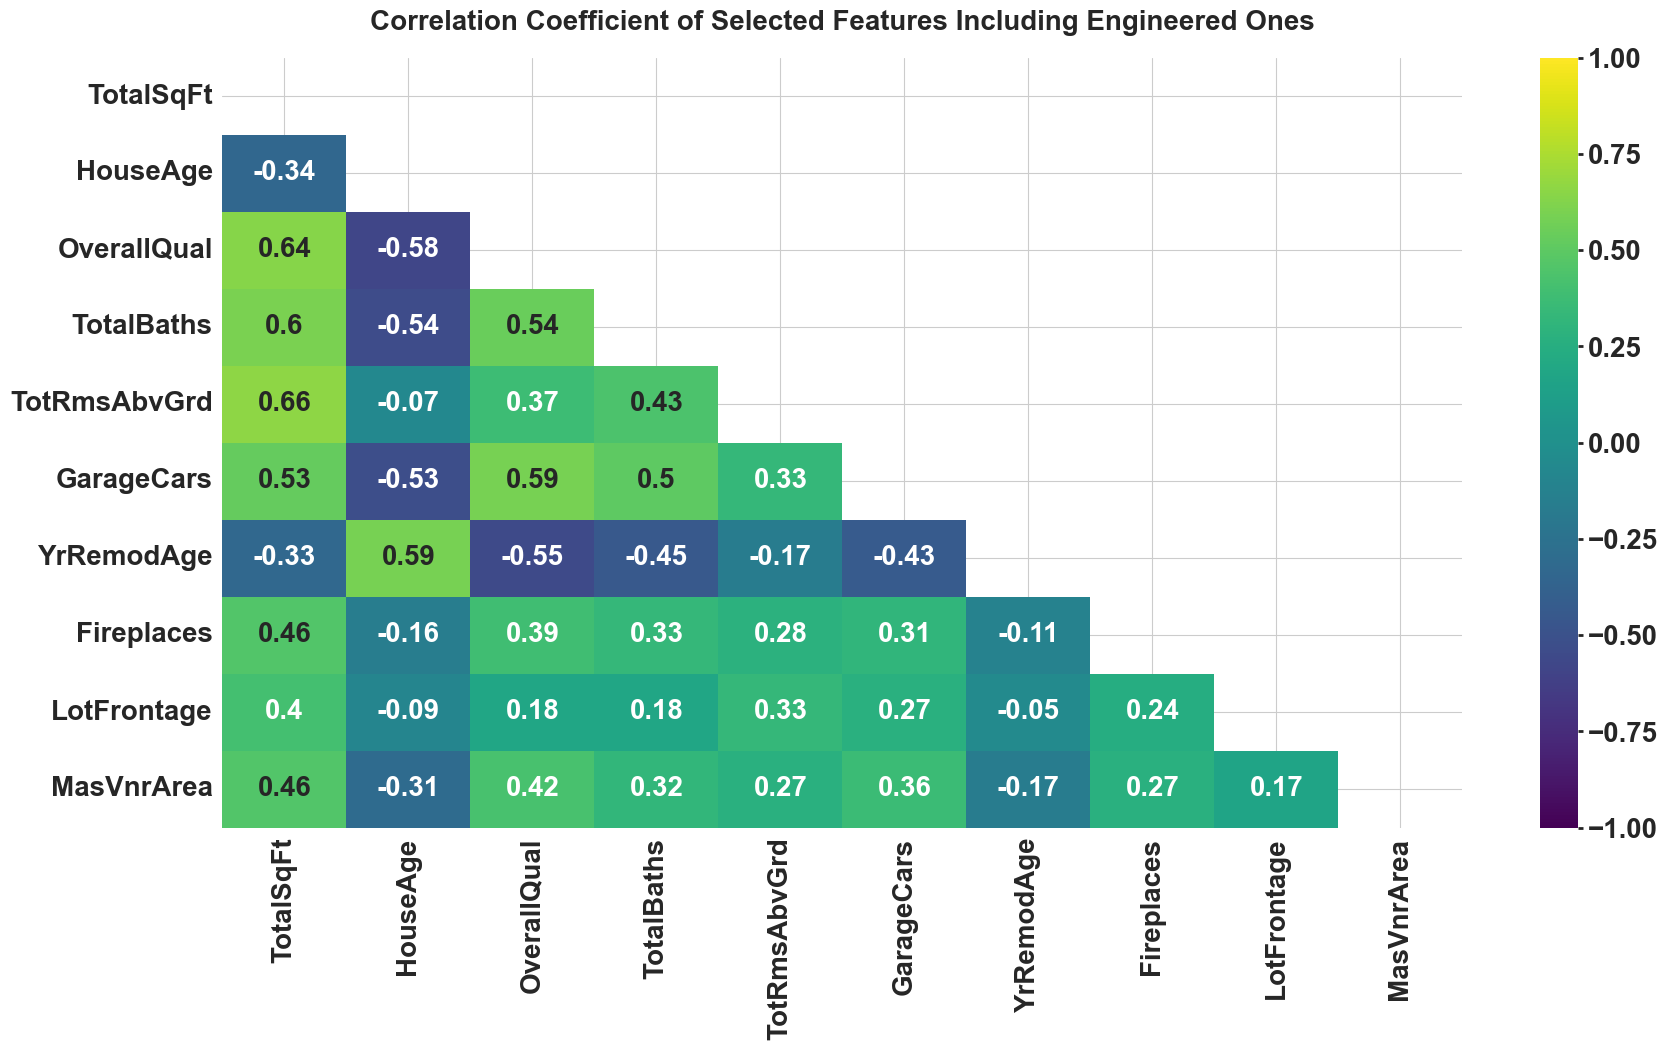

In [128]:
# Select old and new features
selected_features = [
    "TotalSqFt", "HouseAge", "OverallQual", "TotalBaths", 
    "TotRmsAbvGrd", "GarageCars", "YrRemodAge", "Fireplaces",
    "LotFrontage", "MasVnrArea"]


# Compute the correlations for the selected features
corr_matrix = X_train_new[selected_features].corr().round(2)

# Generate a mask to only show the bottom triangle
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

# Generate the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot = True, mask = mask, vmin = -1, vmax = 1, cmap = 'viridis')
plt.title('Correlation Coefficient of Selected Features Including Engineered Ones')
plt.show()

In [129]:
compute_vif(X_train_new[selected_features])

Variable       VIF
0     TotalSqFt  3.367572
1      HouseAge  2.283658
2   OverallQual  2.657610
3    TotalBaths  2.065626
4  TotRmsAbvGrd  1.949337
5    GarageCars  1.872338
6    YrRemodAge  1.795730
7    Fireplaces  1.345782
8   LotFrontage  1.252839
9    MasVnrArea  1.354716

# Model Building

https://machinelearningmastery.com/from-features-to-performance-crafting-robust-predictive-models/

## Base Model: CatBoost with all features
Why CatBoost is good?

<img src="https://i.sstatic.net/Fmqc7.png" alt="Image Description" width="500" height="600">

https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


In [131]:
# Identify and fill NaNs in categorical columns
cat_features = [col for col in X_train_new.columns if X_train_new[col].dtype == 'object']
# Define and train the default CatBoost Model
base_model = CatBoostRegressor(cat_features = cat_features, random_state = 42, verbose = 0)
base_scores = cross_val_score(base_model, X_train_new, y_train, cv = 5, scoring = 'r2')
print(f"Average r2 score for default CatBoost: {base_scores.mean():.4f}")

Average r2 score for default CatBoost: 0.9125


In [132]:
base_scores

array([0.88449204, 0.92523497, 0.92133909, 0.89634955, 0.93528412])

In [133]:
# CatBoost with Ordered Boosting
base_model_ordered = CatBoostRegressor(cat_features = cat_features, random_state = 42, verbose = 0, boosting_type='Ordered')
base_scores_ordered = cross_val_score(base_model_ordered, X_train_new, y_train, cv = 5, scoring = 'r2')
print(f"Average r2 score for default CatBoost with ordered boosting: {base_scores_ordered.mean():.4f}")

Average r2 score for default CatBoost with ordered boosting: 0.9076


Ordered Boosting is novel and should have performed better but not in our data set.

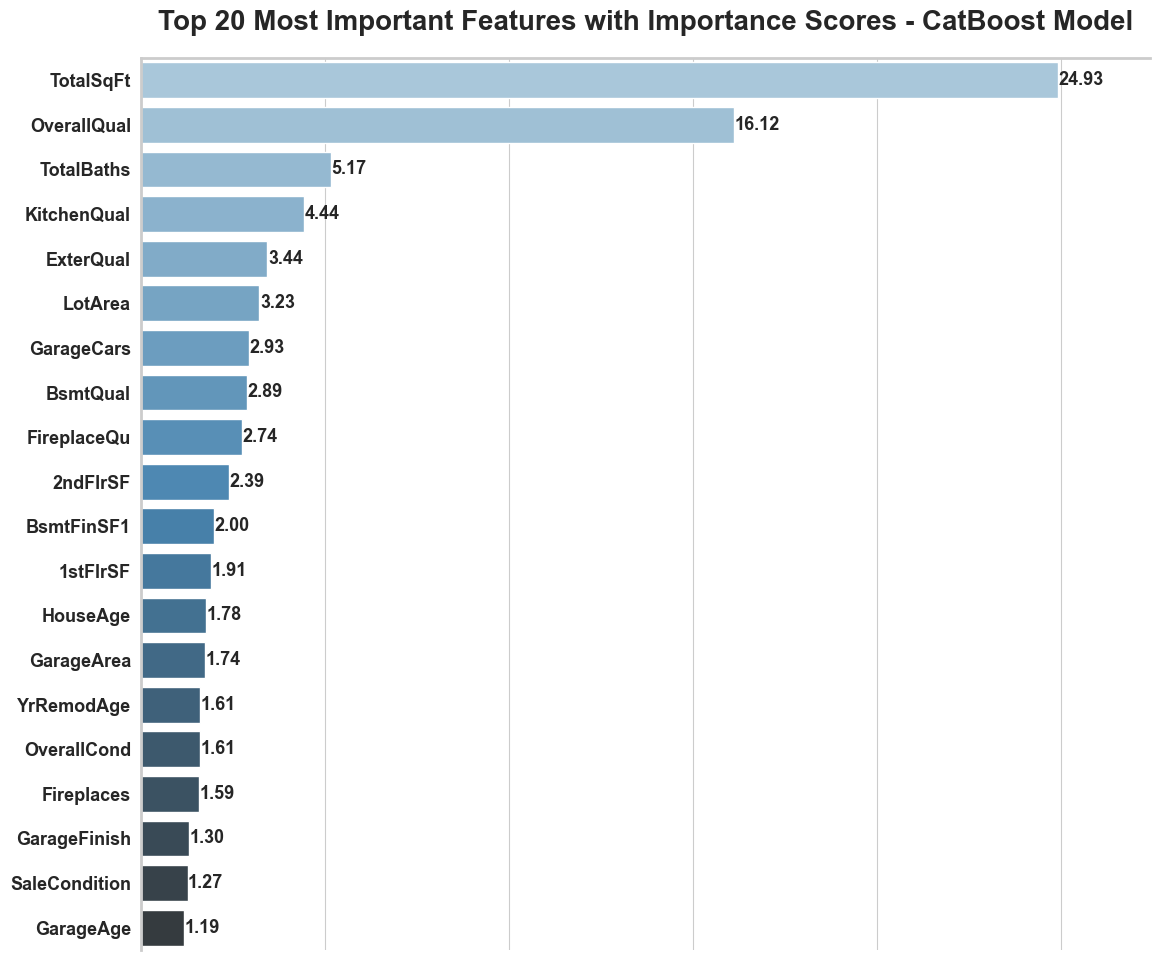

In [135]:
# Set up K-fold cross-validation
kf = KFold(n_splits=5)
feature_importances = []
 
# Iterate over each split
for train_index, test_index in kf.split(X_train_new):
    X_ftrain, X_ftest = X_train_new.iloc[train_index], X_train_new.iloc[test_index]
    y_ftrain, y_ftest = y_train.iloc[train_index], y_train.iloc[test_index]
 
    # Train default CatBoost model
    model = CatBoostRegressor(cat_features=cat_features, random_state=42, verbose=0)
    model.fit(X_ftrain, y_ftrain)
    feature_importances.append(model.get_feature_importance())
 
# Average feature importance across all folds
avg_importance = np.mean(feature_importances, axis=0)
 
# Convert to DataFrame
feat_imp_df = pd.DataFrame({'Feature': X_train_new.columns, 'Importance': avg_importance})
 
# Sort and take the top 20 features
top_features = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)

# Set the style and color palette
sns.set_style("whitegrid")
palette = sns.color_palette("Blues_d", len(top_features))

# Create the plot
plt.figure(figsize=(12, 10))
ax = sns.barplot(x='Importance', y='Feature', data=top_features, palette=palette)

# Customize the plot
plt.title('Top 20 Most Important Features with Importance Scores - CatBoost Model', fontweight='bold')
plt.xlabel(None)
plt.ylabel(None)

# Make x-ticks invisible
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Add value labels to the end of each bar
for i, v in enumerate(top_features['Importance']):
    ax.text(v + 0.015, i, f'{v:.2f}', va='center', fontsize=13)

# Extend x-axis by 10% and feature names font size
plt.xlim(0, max(top_features['Importance']) * 1.1)
plt.yticks(fontsize=13)

# Hide all plot spines but keep gridlines
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Adjust layout and display
plt.tight_layout()
plt.show()


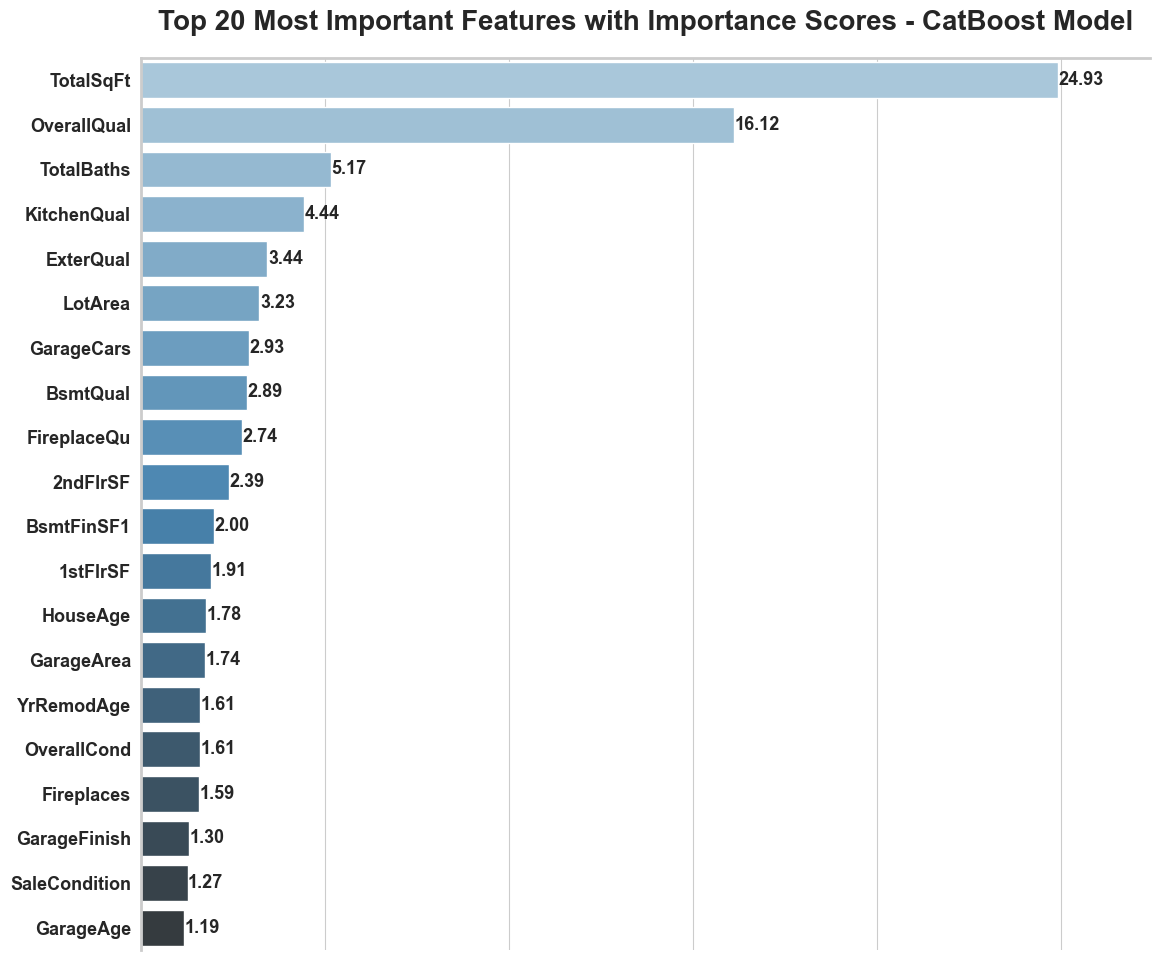

In [136]:
# Set up K-fold cross-validation
kf = KFold(n_splits=5)
feature_importances = []

# Identify and fill NaNs in categorical columns
cat_features = [col for col in X_train_new.columns if X_train_new[col].dtype == 'object']

# Iterate over each split
for train_index, test_index in kf.split(X_train_new):
    X_ftrain, X_ftest = X_train_new.iloc[train_index], X_train_new.iloc[test_index]
    y_ftrain, y_ftest = y_train.iloc[train_index], y_train.iloc[test_index]
 
    # Train default CatBoost model
    model = CatBoostRegressor(cat_features=cat_features, random_state=42, verbose=0)
    model.fit(X_ftrain, y_ftrain)
    feature_importances.append(model.get_feature_importance())
 
# Average feature importance across all folds
avg_importance = np.mean(feature_importances, axis=0)
 
# Convert to DataFrame
feat_imp_df = pd.DataFrame({'Feature': X_train_new.columns, 'Importance': avg_importance})
 
# Sort and take the top 20 features
top_features = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)

# Set the style and color palette
sns.set_style("whitegrid")
palette = sns.color_palette("Blues_d", len(top_features))

# Create the plot
plt.figure(figsize=(12, 10))
ax = sns.barplot(x='Importance', y='Feature', data=top_features, palette=palette)

# Customize the plot
plt.title('Top 20 Most Important Features with Importance Scores - CatBoost Model', fontweight='bold')
plt.xlabel(None)
plt.ylabel(None)

# Make x-ticks invisible
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Add value labels to the end of each bar
for i, v in enumerate(top_features['Importance']):
    ax.text(v + 0.015, i, f'{v:.2f}', va='center', fontsize=13)

# Extend x-axis by 10% and feature names font size
plt.xlim(0, max(top_features['Importance']) * 1.1)
plt.yticks(fontsize=13)

# Hide all plot spines but keep gridlines
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Adjust layout and display
plt.tight_layout()
plt.show()


In [225]:
# Identify and fill NaNs in categorical columns
cat_features = [col for col in X_train_new.columns if X_train_new[col].dtype == 'object']

# Define and train the default CatBoost Model
base_model_new = CatBoostRegressor(cat_features = cat_features, random_state = 42, verbose = 0)
base_scores_new = cross_val_score(base_model_new, X_train_new, y_train, cv = 5, scoring = 'r2')
print(f"Average r2 score for default CatBoost: {base_scores_new.mean():.4f}")

Average r2 score for default CatBoost: 0.9125


## CatBoost with Selected Features

In [146]:
numerical_features = [
    "TotalSqFt",
    "HouseAge",
    "OverallQual",
    "TotalBaths",
    "TotRmsAbvGrd",
    "GarageCars",
    "YrRemodAge",
    "Fireplaces",
    "LotFrontage",
    "MasVnrArea"
]

categorical_features = ['Neighborhood',
                         'FireplaceQu', 
                         'KitchenQual',
                         'BsmtExposure']
important_features =    numerical_features + categorical_features 

train_model_data = X_train_new[important_features]
test_model_data = X_test_new[important_features]

In [236]:
# Identify and fill NaNs in categorical columns
cat_features = [col for col in train_model_data.columns if train_model_data[col].dtype == 'object']

# Define and train the default CatBoost Model
desired_catboost_model = CatBoostRegressor(cat_features = cat_features, random_state = 42, verbose = 0)
desired_catboost_scores = cross_val_score(desired_catboost_model, train_model_data, y_train, cv = 5, scoring = 'r2')
print(f"Average r2 score for default CatBoost: {desired_catboost_scores.mean():.4f}")

Average r2 score for default CatBoost: 0.9027


In [228]:
def calculate_adjusted_r2(r2_score, n, p):
    """
    Calculate the adjusted R² score.

    Parameters:
    r2_score (float): The R² score.
    n (int): The number of observations.
    p (int): The number of independent variables.

    Returns:
    float: The adjusted R² score.
    """
    adjusted_r2 = 1 - ((1 - r2_score) * (n - 1)) / (n - p - 1)
    return adjusted_r2


In [229]:
print("Adjusted r2_score for desired catboost model:", calculate_adjusted_r2(0.9111, 2580, 15))
print("Adjusted r2_score for base catboost model:", calculate_adjusted_r2(0.9281, 2580, 80))

Adjusted r2_score for desired catboost model: 0.9105799141965679
Adjusted r2_score for base catboost model: 0.9257982793117248


## XGBoost

In [272]:
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

# Preprocessing: Apply scaling to numeric columns
scaler = StandardScaler()
numeric_cols = train_model_data.select_dtypes(include=['float64', 'int64']).columns
# train_model_data[numeric_cols] = scaler.fit_transform(train_model_data[numeric_cols])
# test_model_data[numeric_cols] = scaler.transform(test_model_data[numeric_cols])

# Convert categorical columns to category dtype
cat_feats = ['Neighborhood', 'FireplaceQu', 'KitchenQual', 'BsmtExposure']
for col in cat_feats:
    train_model_data[col] = train_model_data[col].astype('category')
    test_model_data[col] = test_model_data[col].astype('category')


# Create LightGBM datasets for training and validation
train_data = lgb.Dataset(train_model_data, label=y_train, categorical_feature=cat_feats)
test_data = lgb.Dataset(test_model_data, label=y_test, reference=train_data)

# Set parameters
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 11,
    'learning_rate': 0.003,
    'force_col_wise': 'true'
}

# Train with early stopping callback
bst = lgb.train(
    params, 
    train_data, 
    num_boost_round=1000000, 
    valid_sets=[test_data], 
    callbacks=[lgb.early_stopping(stopping_rounds= 500, first_metric_only=True)]
)

# Predict on the test set (use feature columns only)
y_pred = bst.predict(test_model_data, num_iteration=bst.best_iteration)

# Rename result variable to avoid conflict with function name
r2 = r2_score(y_test, y_pred)
mse = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"r2_score: {r2}")
print(f"mse: {mse}")
print(f"mape: {mape}")


[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 14
[LightGBM] [Info] Start training from score 178582.207765
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[3354]	valid_0's l1: 15948.6
Evaluated only: l1
r2_score: 0.920983422355537
mse: 15948.617152422812
mape: 0.08943143715527675


The results you shared indicate an L1 loss of 15,486.4, meaning the model's predictions, on average, differ from actual values by about $15,486. This seems reasonable given your target range of $300K–600K.

The R² score of 0.927 suggests that your model explains about 92.7% of the variance in the target variable, which is a strong fit.

Overall, these metrics indicate that your model is performing quite well, with a relatively low error and a high R², reflecting good predictive power.

In [281]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define categorical and numerical features
cat_feats = ['Neighborhood', 'FireplaceQu', 'KitchenQual', 'BsmtExposure']
numeric_cols = train_model_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Create OneHotEncoder with infrequent category handling
one_hot = OneHotEncoder(handle_unknown='ignore', drop='first', min_frequency = 0.01)

# Create ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', one_hot, cat_feats)
    ]
)

# Apply preprocessing pipeline to train and test data
X_train = preprocessor.fit_transform(train_model_data)
X_test = preprocessor.transform(test_model_data)

# Create LightGBM datasets for training and validation
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 11,
    'learning_rate': 0.003,
    'force_col_wise': True
}

# Train with early stopping
bst = lgb.train(
    params,
    train_data,
    num_boost_round=1000000,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds = 500, first_metric_only = True)]
)

# Predict on test set
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Evaluate performance
r2 = r2_score(y_test, y_pred)
mse = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"r2_score: {r2}")
print(f"mse: {mse}")
print(f"mape: {mape}")

[LightGBM] [Info] Total Bins 892
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 43
[LightGBM] [Info] Start training from score 178582.207765
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[5603]	valid_0's l1: 16038.9
Evaluated only: l1
r2_score: 0.9161646191873412
mse: 16038.878117649603
mape: 0.08877897222559976


In [294]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import pandas as pd

class MissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_threshold=0.5):
        self.cat_threshold = cat_threshold
        self.num_imputer = SimpleImputer(strategy = 'median')

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()

        # Handle missing values in categorical columns
        for col in data.select_dtypes(include=['object', 'category']).columns:
            missing_ratio = data[col].isnull().mean() * 100.
            if missing_ratio > self.cat_threshold:
                # Set categories first if they are categorical
                if pd.api.types.is_categorical_dtype(data[col]):
                    categories = data[col].cat.categories.tolist() + ['Unknown']
                    data[col] = data[col].cat.add_categories(['Unknown'])
                else:
                    data[col] = data[col].astype('category')
                    data[col].cat.add_categories(['Unknown'], inplace=True)

                data[col] = data[col].fillna('Unknown')
            else:
                data[col] = data[col].fillna(data[col].mode()[0])

        # Handle numeric columns with SimpleImputer
        num_cols = data.select_dtypes(include=['number']).columns
        data[num_cols] = self.num_imputer.fit_transform(data[num_cols])

        return data

# Define your training and test data here
# train_model_data, test_model_data, y_train, y_test = ...

# Define categorical and numerical features
cat_feats = ['Neighborhood', 'FireplaceQu', 'KitchenQual', 'BsmtExposure']
numeric_cols = train_model_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Create OneHotEncoder with infrequent category handling
one_hot = OneHotEncoder(handle_unknown='ignore', drop='first', min_frequency=0.01)

# Create ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', one_hot, cat_feats)
    ]
)

# Create AdaBoost pipeline with the custom imputer
pipeline = Pipeline([
    ('imputer', MissingValueImputer(cat_threshold = 0.5)),  # Custom imputer to handle missing values
    ('preprocessor', preprocessor),
    ('regressor', AdaBoostRegressor(n_estimators = 100, learning_rate = 1.0))
])

# Fit the model
pipeline.fit(train_model_data, y_train)

# Predict on test set
y_pred = pipeline.predict(test_model_data)

# Evaluate performance
r2 = r2_score(y_test, y_pred)
mse = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"r2_score: {r2}")
print(f"mse: {mse}")
print(f"mape: {mape}")


r2_score: 0.8507593017694928
mse: 23799.415194328194
mape: 0.15139658571555445


In [295]:
# Fit the preprocessor on training data and transform both train and test sets
X_train_transformed = pipeline.named_steps['preprocessor'].fit_transform(train_model_data)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(test_model_data)

# Get the feature names after transformation
ohe_columns = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(cat_feats)
num_columns = numeric_cols

# Concatenate the numeric and encoded categorical columns
transformed_columns = list(num_columns) + list(ohe_columns)

# Create DataFrame for transformed train and test data
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_columns)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_columns)

# Display the transformed data with columns
print(X_train_transformed_df.head())
print(X_test_transformed_df.head())


   TotalSqFt  HouseAge  OverallQual  TotalBaths  TotRmsAbvGrd  GarageCars  \
0  -0.100204 -0.181084     0.673941   -0.251545     -0.261706    0.339058   
1   0.749261  0.115603    -0.766750    0.981971      0.377959    0.339058   
2  -1.646506  0.280430    -1.487095   -0.251545     -0.261706    0.339058   
3  -1.876700  0.708978    -1.487095   -0.251545     -0.261706    0.339058   
4  -0.299122  1.664971    -1.487095   -0.251545      1.017625   -2.341388   

   YrRemodAge  Fireplaces  LotFrontage  MasVnrArea  ...  FireplaceQu_Po  \
0    0.439320    0.614268     0.485756    0.531409  ...             0.0   
1    0.872439   -0.917482    -0.008229   -0.569155  ...             0.0   
2    1.016812   -0.917482     0.036679   -0.569155  ...             0.0   
3    1.690554   -0.917482    -0.412398   -0.569155  ...             0.0   
4    1.690554   -0.917482    -0.277675   -0.569155  ...             0.0   

   FireplaceQu_TA  FireplaceQu_Unknown  KitchenQual_Fa  KitchenQual_Gd  \
0           

## Automated MLOPs Pipeline

2024-10-31 12:36:42,832 - __main__ - INFO - Starting house price prediction pipeline...
2024-10-31 12:36:42,857 - __main__ - INFO - Loaded 2930 rows and 81 columns
2024-10-31 12:36:42,871 - __main__ - INFO - 
Column: Neighborhood
2024-10-31 12:36:42,871 - __main__ - INFO - Categories to keep: ['Other']
2024-10-31 12:36:42,871 - __main__ - INFO - Number of categories after merging: 1
2024-10-31 12:36:42,871 - __main__ - INFO - 
Column: KitchenQual
2024-10-31 12:36:42,871 - __main__ - INFO - Categories to keep: ['TA', 'Gd', 'Other']
2024-10-31 12:36:42,871 - __main__ - INFO - Number of categories after merging: 3
2024-10-31 12:36:42,871 - __main__ - INFO - 
Column: BsmtExposure
2024-10-31 12:36:42,871 - __main__ - INFO - Categories to keep: ['No', 'Other']
2024-10-31 12:36:42,871 - __main__ - INFO - Number of categories after merging: 2
2024-10-31 12:36:42,887 - __main__ - INFO - 
=== Feature Engineering Information ===
2024-10-31 12:36:42,888 - __main__ - INFO - Original features to be 

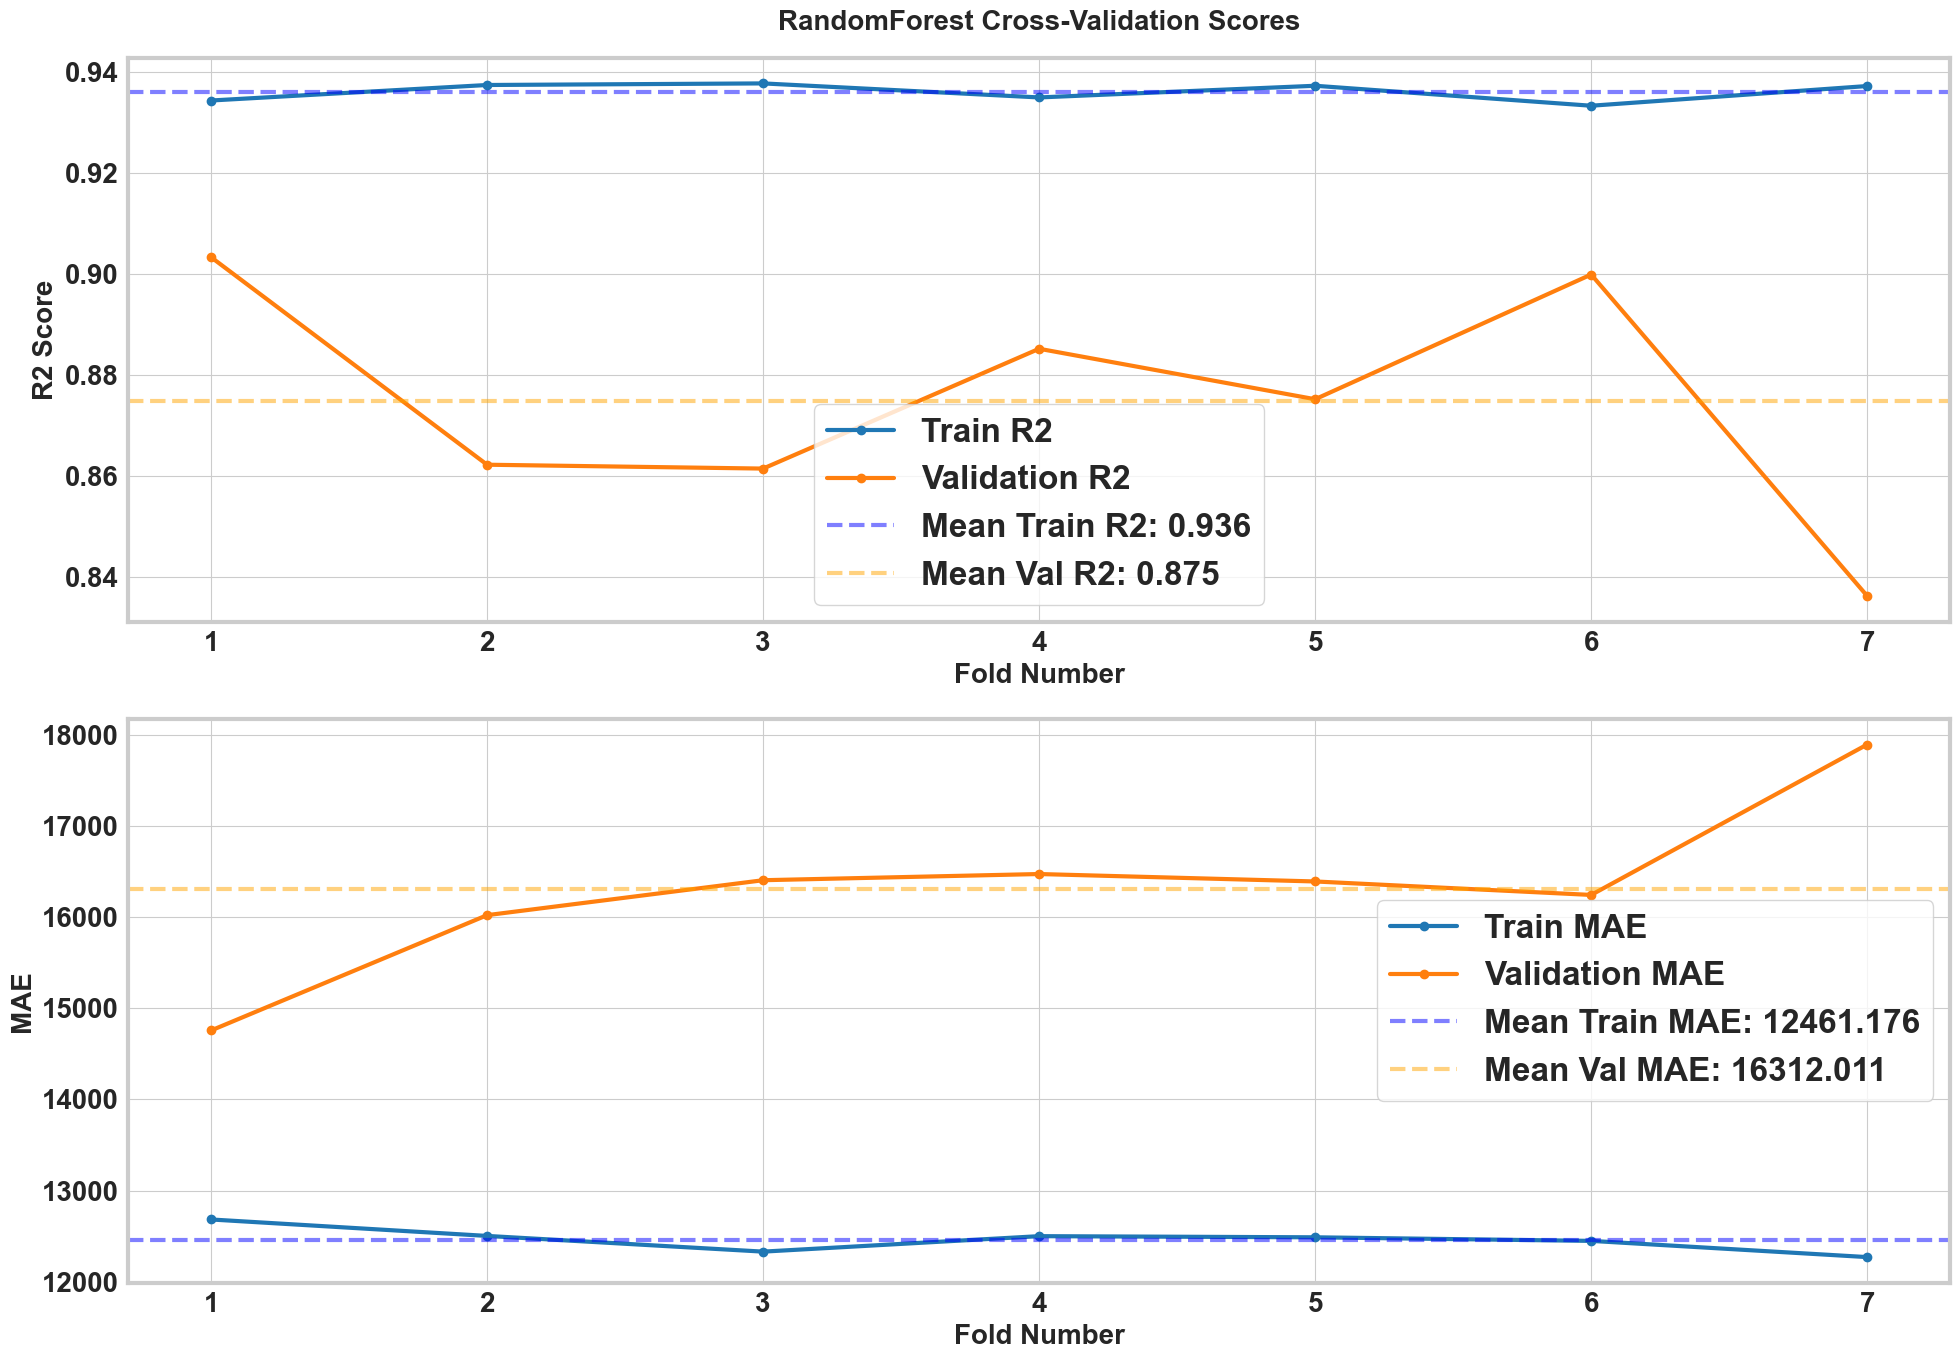

2024-10-31 12:36:46,437 - __main__ - INFO - 
Performing 7-fold CV for LightGBM
2024-10-31 12:36:46,481 - __main__ - INFO - 
Fold 1 Results for LightGBM:
2024-10-31 12:36:46,482 - __main__ - INFO - Train R2: 0.9241
2024-10-31 12:36:46,483 - __main__ - INFO - Validation R2: 0.9015
2024-10-31 12:36:46,484 - __main__ - INFO - Train MAE: 11356.7057
2024-10-31 12:36:46,484 - __main__ - INFO - Validation MAE: 14710.9654
2024-10-31 12:36:46,526 - __main__ - INFO - 
Fold 2 Results for LightGBM:
2024-10-31 12:36:46,527 - __main__ - INFO - Train R2: 0.9242
2024-10-31 12:36:46,527 - __main__ - INFO - Validation R2: 0.8809
2024-10-31 12:36:46,528 - __main__ - INFO - Train MAE: 11387.7082
2024-10-31 12:36:46,529 - __main__ - INFO - Validation MAE: 14940.4811
2024-10-31 12:36:46,572 - __main__ - INFO - 
Fold 3 Results for LightGBM:
2024-10-31 12:36:46,573 - __main__ - INFO - Train R2: 0.9259
2024-10-31 12:36:46,573 - __main__ - INFO - Validation R2: 0.8751
2024-10-31 12:36:46,573 - __main__ - INFO - 

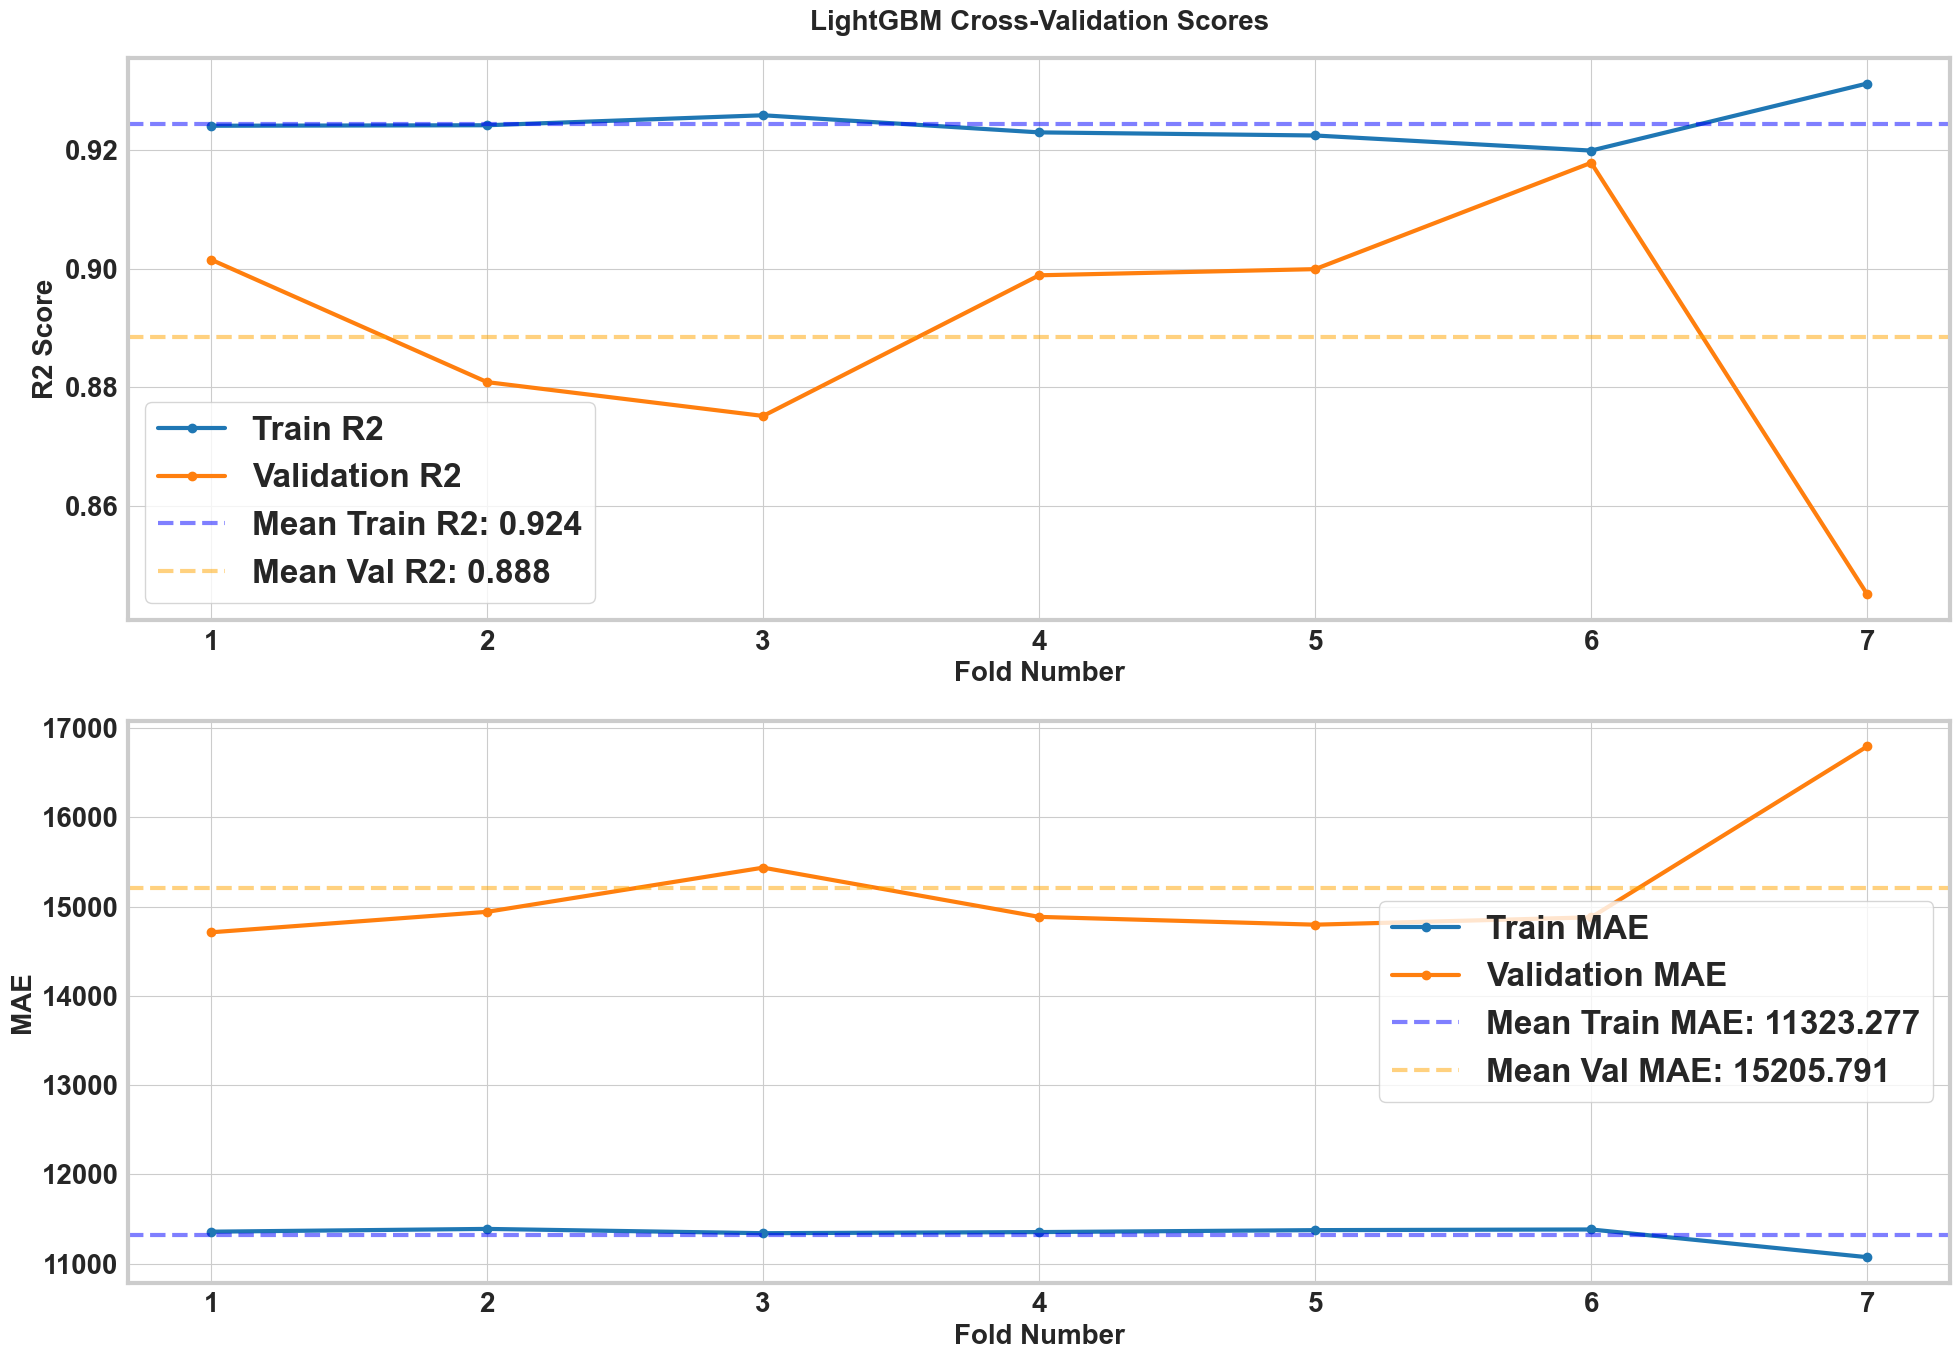

2024-10-31 12:36:47,218 - __main__ - INFO - 
Performing 7-fold CV for CatBoost
2024-10-31 12:36:49,142 - __main__ - INFO - 
Fold 1 Results for CatBoost:
2024-10-31 12:36:49,143 - __main__ - INFO - Train R2: 0.9301
2024-10-31 12:36:49,143 - __main__ - INFO - Validation R2: 0.9149
2024-10-31 12:36:49,144 - __main__ - INFO - Train MAE: 11879.9493
2024-10-31 12:36:49,144 - __main__ - INFO - Validation MAE: 13701.4045
2024-10-31 12:36:51,173 - __main__ - INFO - 
Fold 2 Results for CatBoost:
2024-10-31 12:36:51,174 - __main__ - INFO - Train R2: 0.9331
2024-10-31 12:36:51,175 - __main__ - INFO - Validation R2: 0.8918
2024-10-31 12:36:51,175 - __main__ - INFO - Train MAE: 11768.3965
2024-10-31 12:36:51,176 - __main__ - INFO - Validation MAE: 14459.4696
2024-10-31 12:36:53,034 - __main__ - INFO - 
Fold 3 Results for CatBoost:
2024-10-31 12:36:53,034 - __main__ - INFO - Train R2: 0.9309
2024-10-31 12:36:53,034 - __main__ - INFO - Validation R2: 0.8852
2024-10-31 12:36:53,034 - __main__ - INFO - 

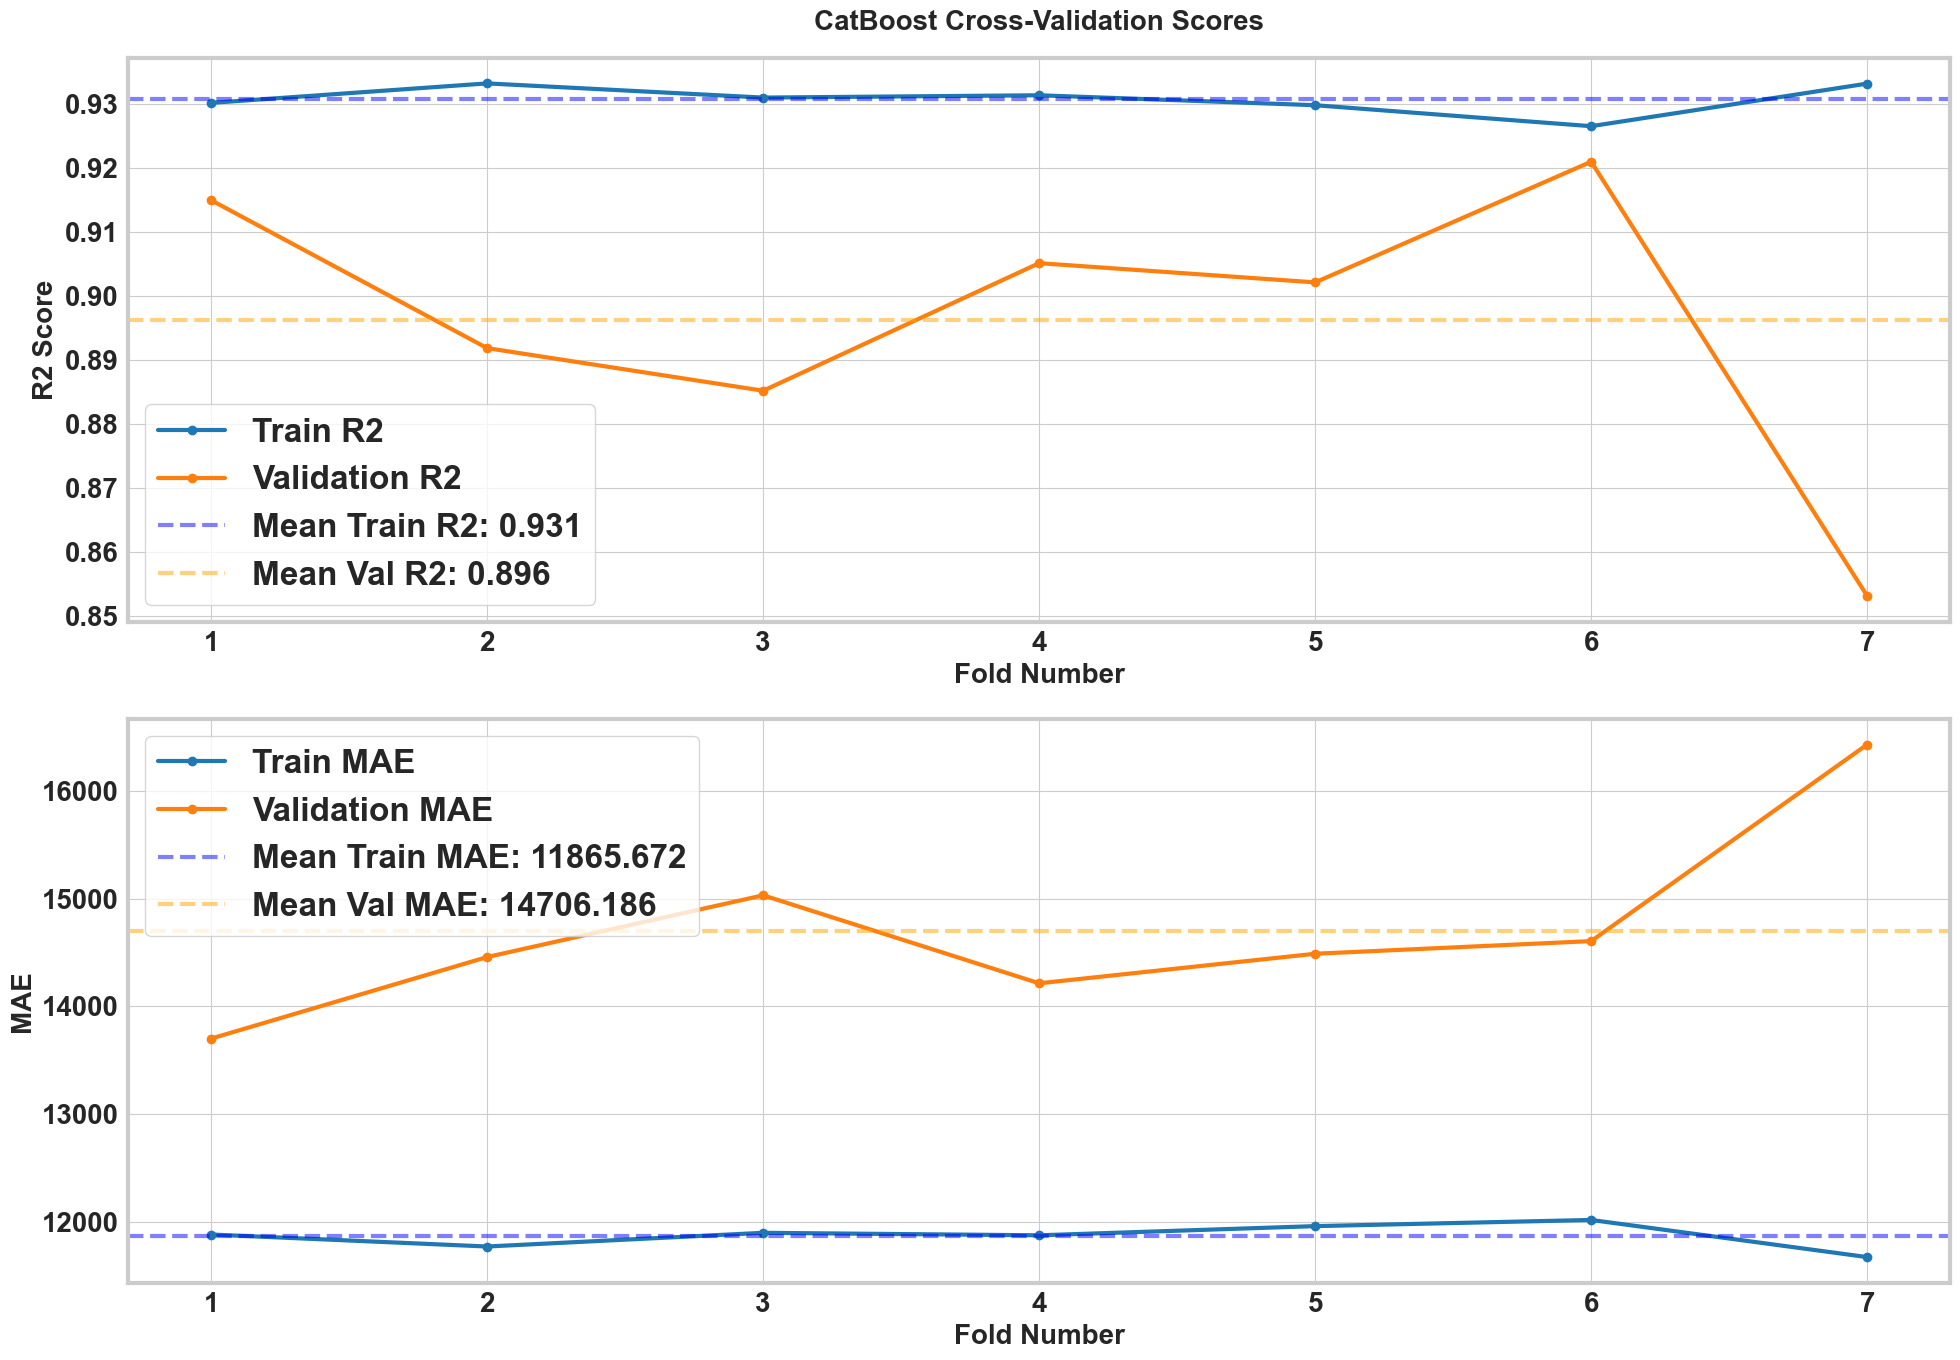

2024-10-31 12:37:00,568 - __main__ - INFO - 
Performing 7-fold CV for AdaBoost
2024-10-31 12:37:00,871 - __main__ - INFO - 
Fold 1 Results for AdaBoost:
2024-10-31 12:37:00,871 - __main__ - INFO - Train R2: 0.8390
2024-10-31 12:37:00,871 - __main__ - INFO - Validation R2: 0.8487
2024-10-31 12:37:00,871 - __main__ - INFO - Train MAE: 20801.8019
2024-10-31 12:37:00,871 - __main__ - INFO - Validation MAE: 19601.7937
2024-10-31 12:37:01,161 - __main__ - INFO - 
Fold 2 Results for AdaBoost:
2024-10-31 12:37:01,162 - __main__ - INFO - Train R2: 0.8468
2024-10-31 12:37:01,162 - __main__ - INFO - Validation R2: 0.7838
2024-10-31 12:37:01,163 - __main__ - INFO - Train MAE: 20534.5232
2024-10-31 12:37:01,163 - __main__ - INFO - Validation MAE: 22420.0398
2024-10-31 12:37:01,468 - __main__ - INFO - 
Fold 3 Results for AdaBoost:
2024-10-31 12:37:01,468 - __main__ - INFO - Train R2: 0.8440
2024-10-31 12:37:01,484 - __main__ - INFO - Validation R2: 0.7903
2024-10-31 12:37:01,485 - __main__ - INFO - 

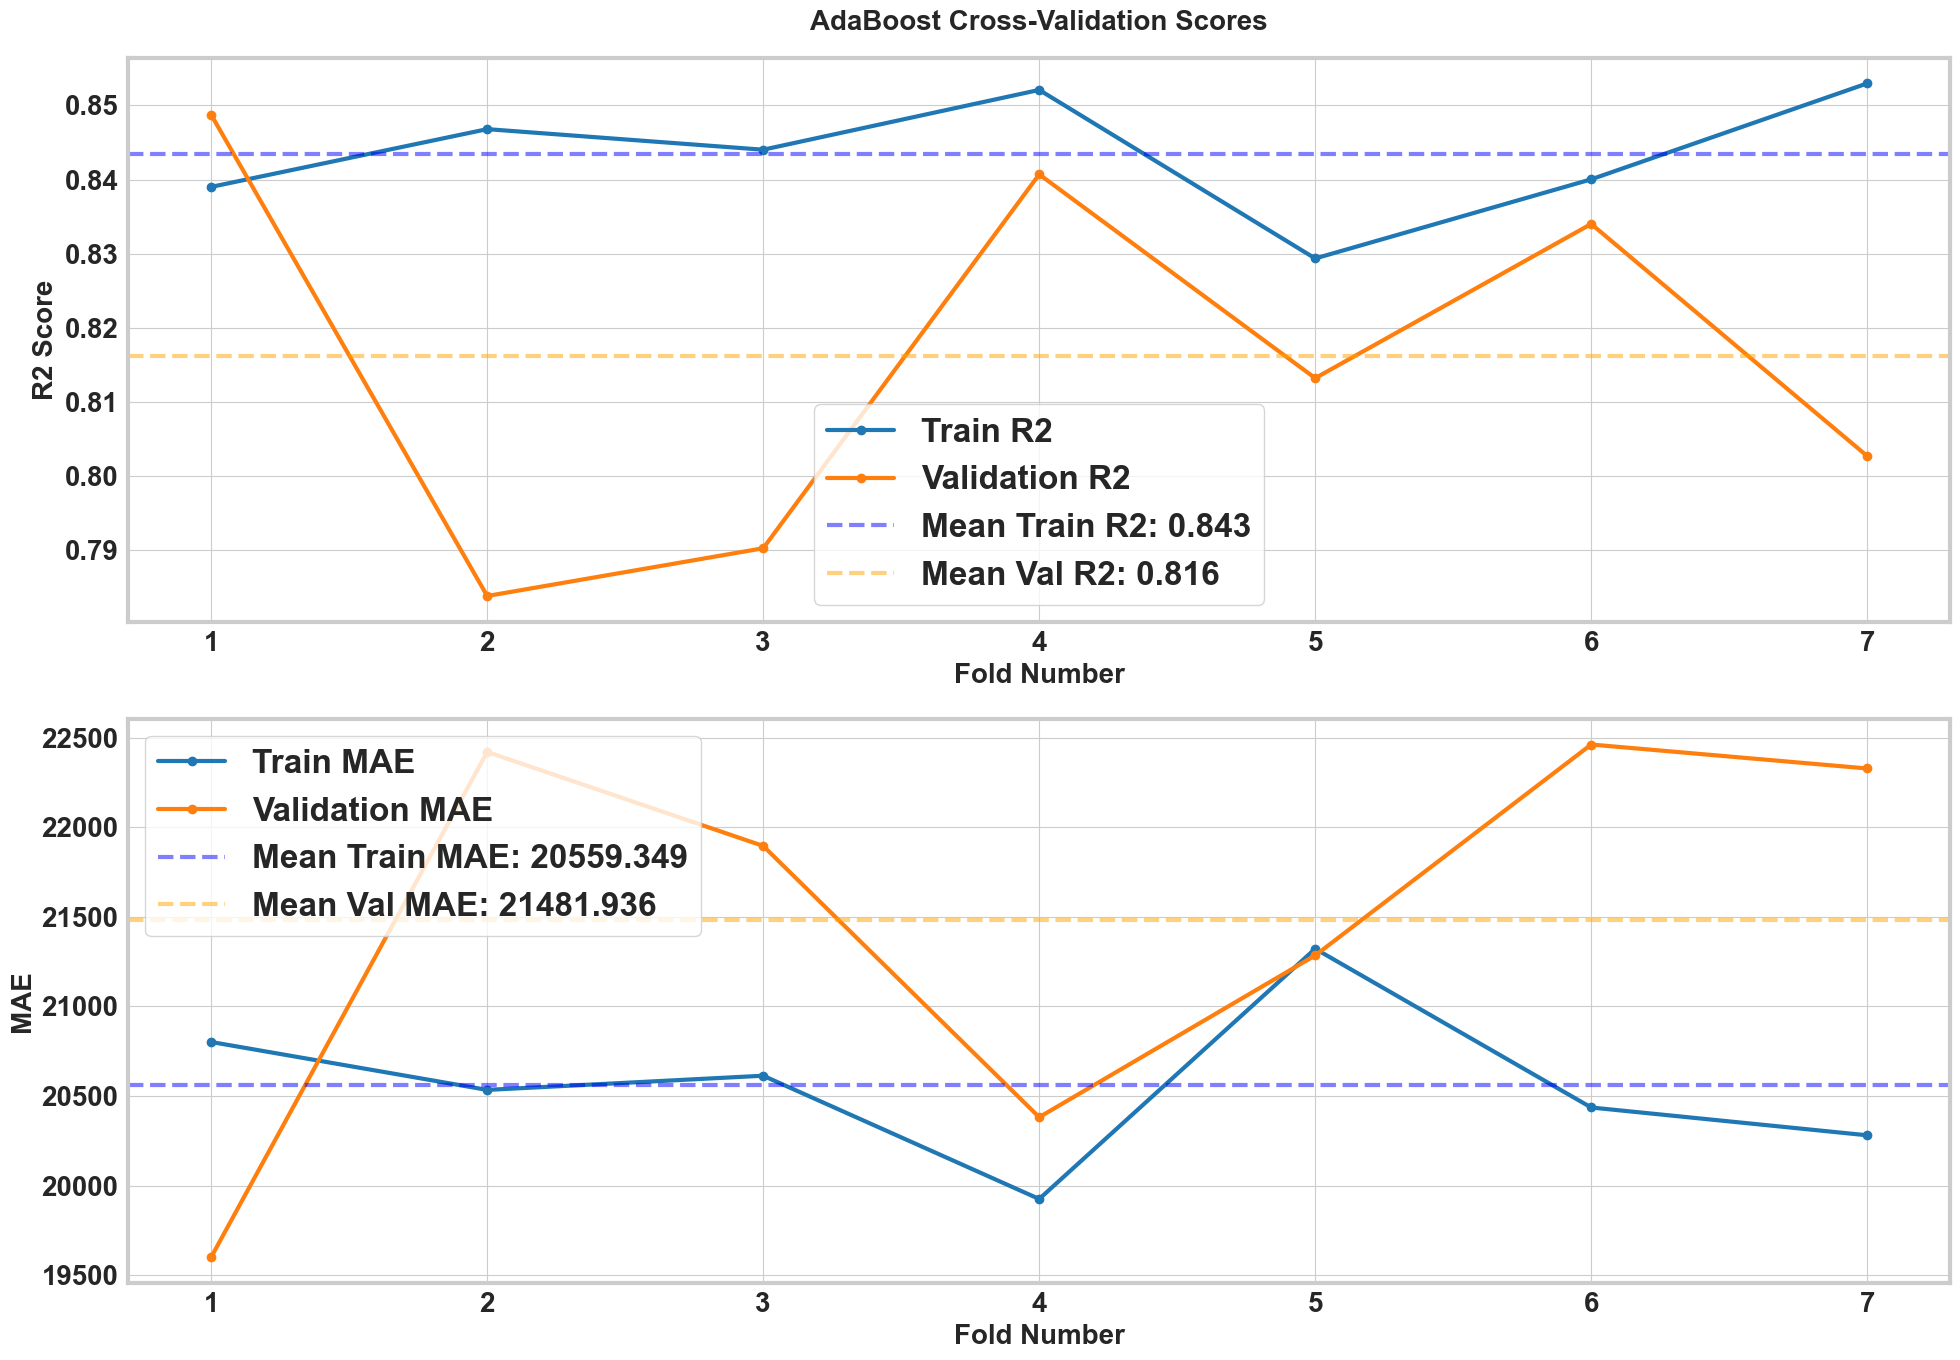

2024-10-31 12:37:06,268 - __main__ - INFO - 
Selected 4 models for hypertuning:
2024-10-31 12:37:06,268 - __main__ - INFO - Model: CatBoost, Train R2: 0.9294, Test R2: 0.9330, Train MAE: 12053.0880, Test MAE: 13268.6268,   R2 Score Delta: 0.0036
2024-10-31 12:37:06,268 - __main__ - INFO - Model: LightGBM, Train R2: 0.9224, Test R2: 0.9285, Train MAE: 11522.4869, Test MAE: 13580.6788,   R2 Score Delta: 0.0061
2024-10-31 12:37:06,268 - __main__ - INFO - Model: RandomForest, Train R2: 0.9329, Test R2: 0.9160, Train MAE: 12749.4587, Test MAE: 15080.8554,   R2 Score Delta: 0.0169
2024-10-31 12:37:06,268 - __main__ - INFO - Model: AdaBoost, Train R2: 0.8334, Test R2: 0.8474, Train MAE: 20986.5755, Test MAE: 21516.8749,   R2 Score Delta: 0.0140


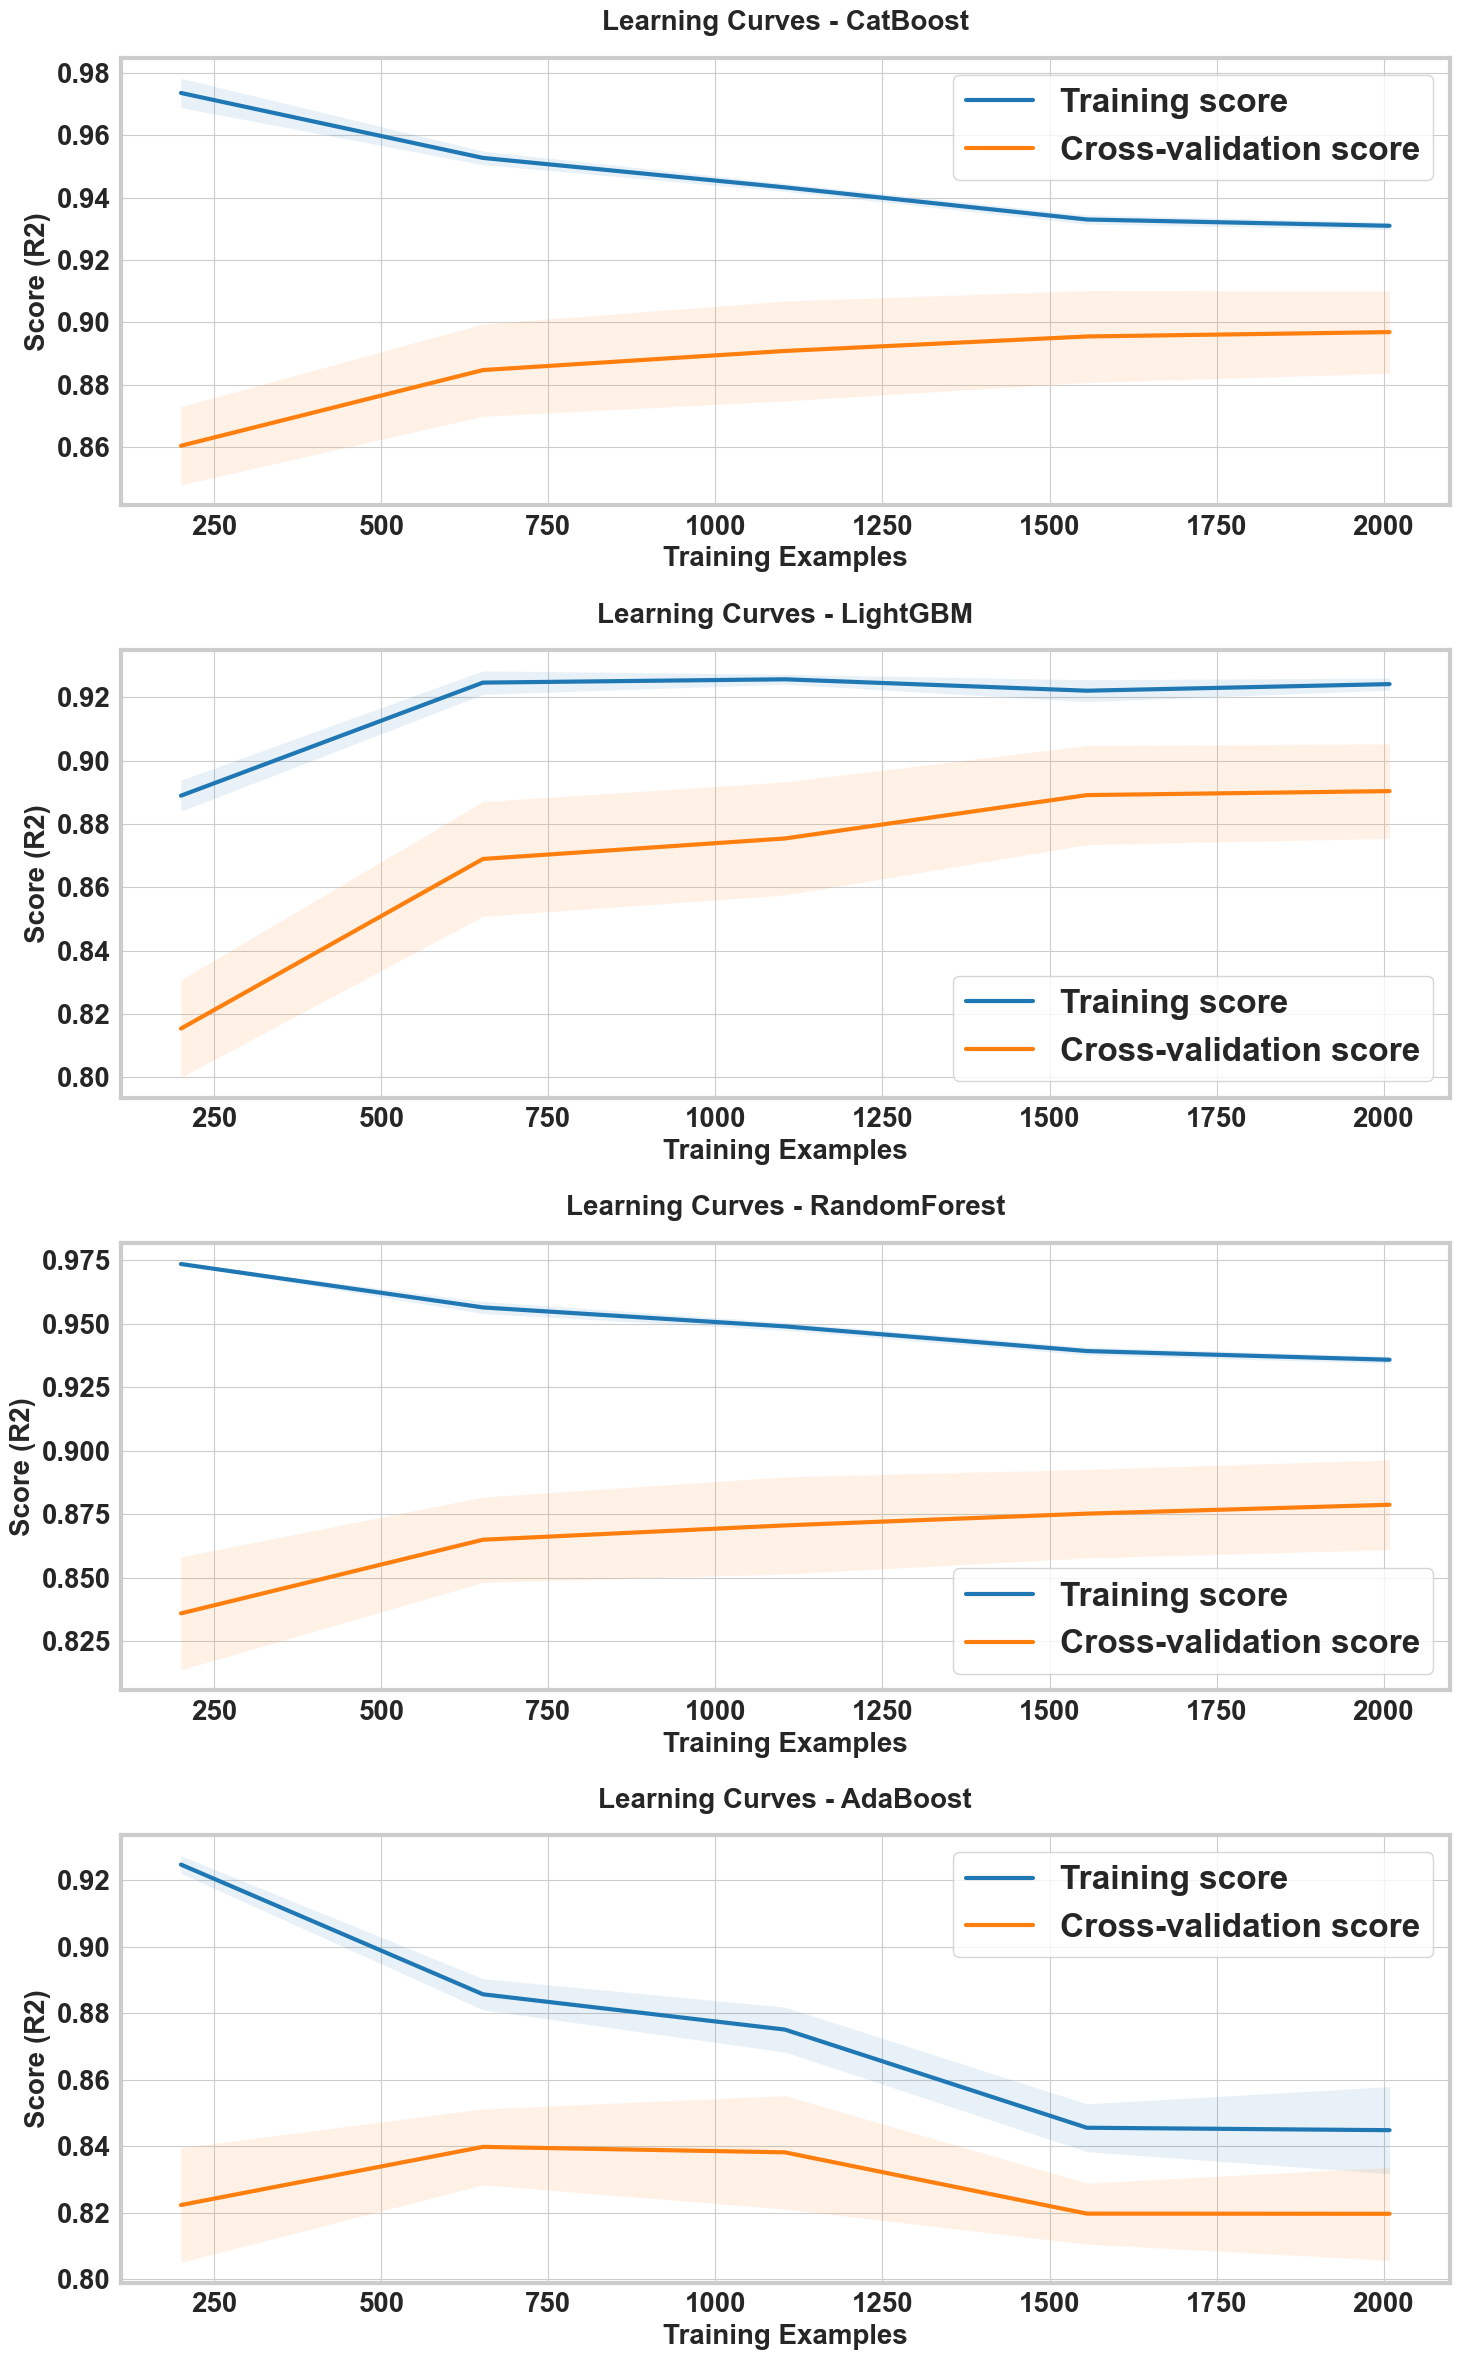

2024-10-31 12:37:48,829 - __main__ - INFO - Starting hyperparameter tuning...
2024-10-31 12:37:48,829 - __main__ - INFO - Tuning CatBoost...
2024-10-31 12:45:41,997 - __main__ - INFO - Best parameters for CatBoost: {'colsample_bylevel': 1.0, 'depth': 5, 'early_stopping_rounds': 500, 'eval_metric': 'MAE', 'iterations': 1000, 'learning_rate': 0.03, 'min_data_in_leaf': 1, 'objective': 'MAE', 'subsample': 0.9, 'verbose': 0}
Best score: 0.9010
2024-10-31 12:45:41,998 - __main__ - INFO - Tuning LightGBM...
2024-10-31 12:54:42,056 - __main__ - INFO - Best parameters for LightGBM: {'colsample_bytree': 0.9, 'learning_rate': 0.15, 'metric': 'mae', 'min_child_samples': 25, 'min_child_weight': 0.001, 'n_estimators': 100, 'num_leaves': 31, 'objective': 'regression_l1', 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'stopping_rounds': 50, 'subsample': 0.9}
Best score: 0.8966
2024-10-31 12:54:42,068 - __main__ - INFO - Tuning RandomForest...
2024-10-31 12:55:29,233 - __main__ - INFO - Best parameters for Rando

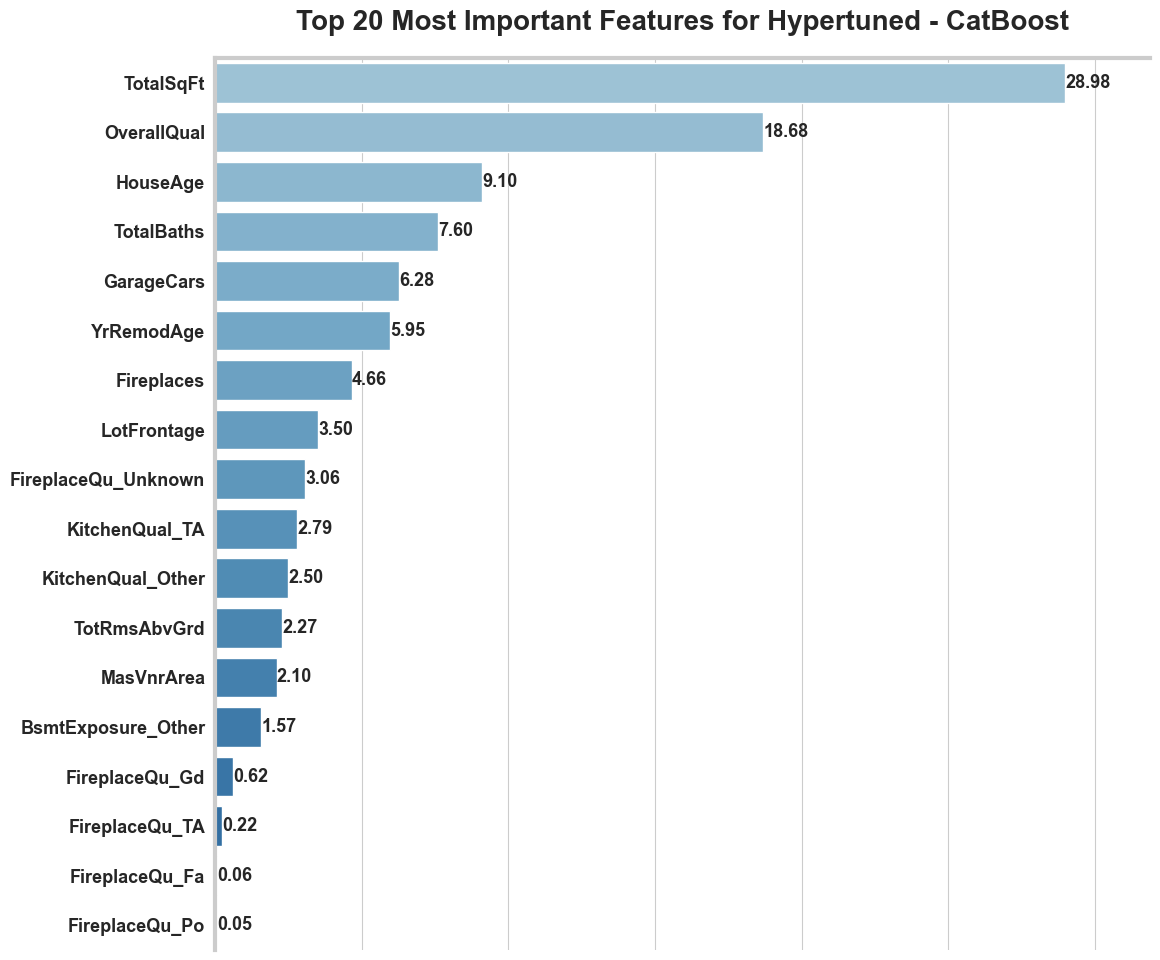

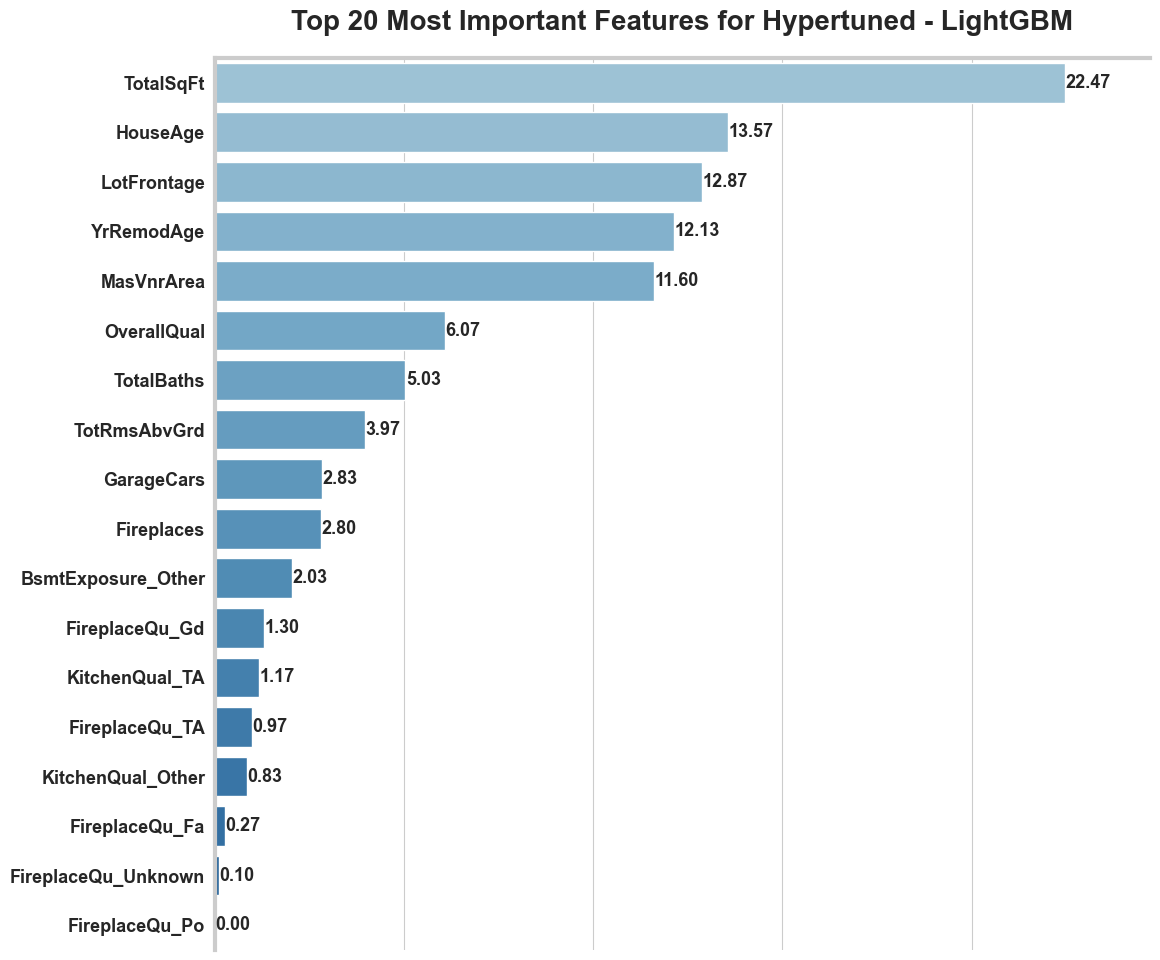

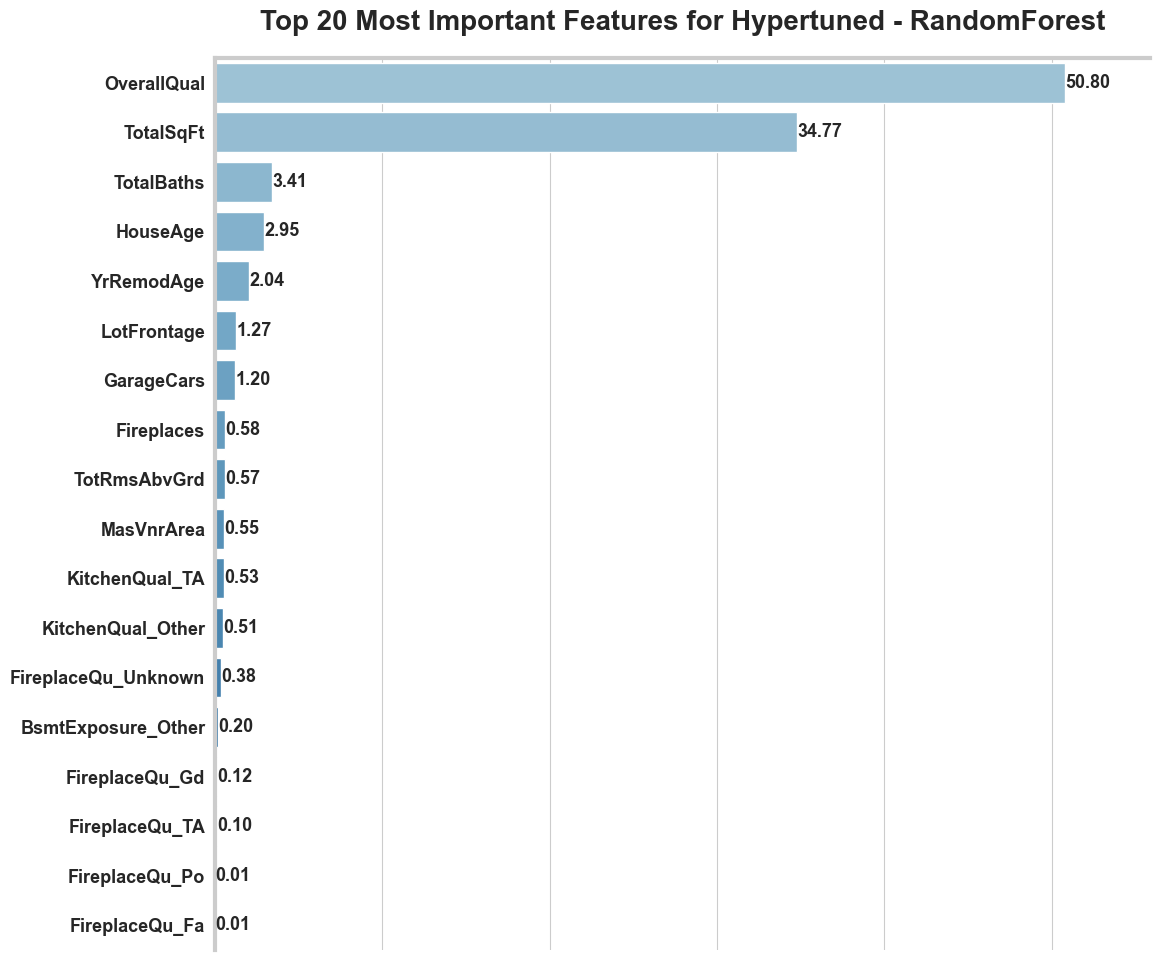

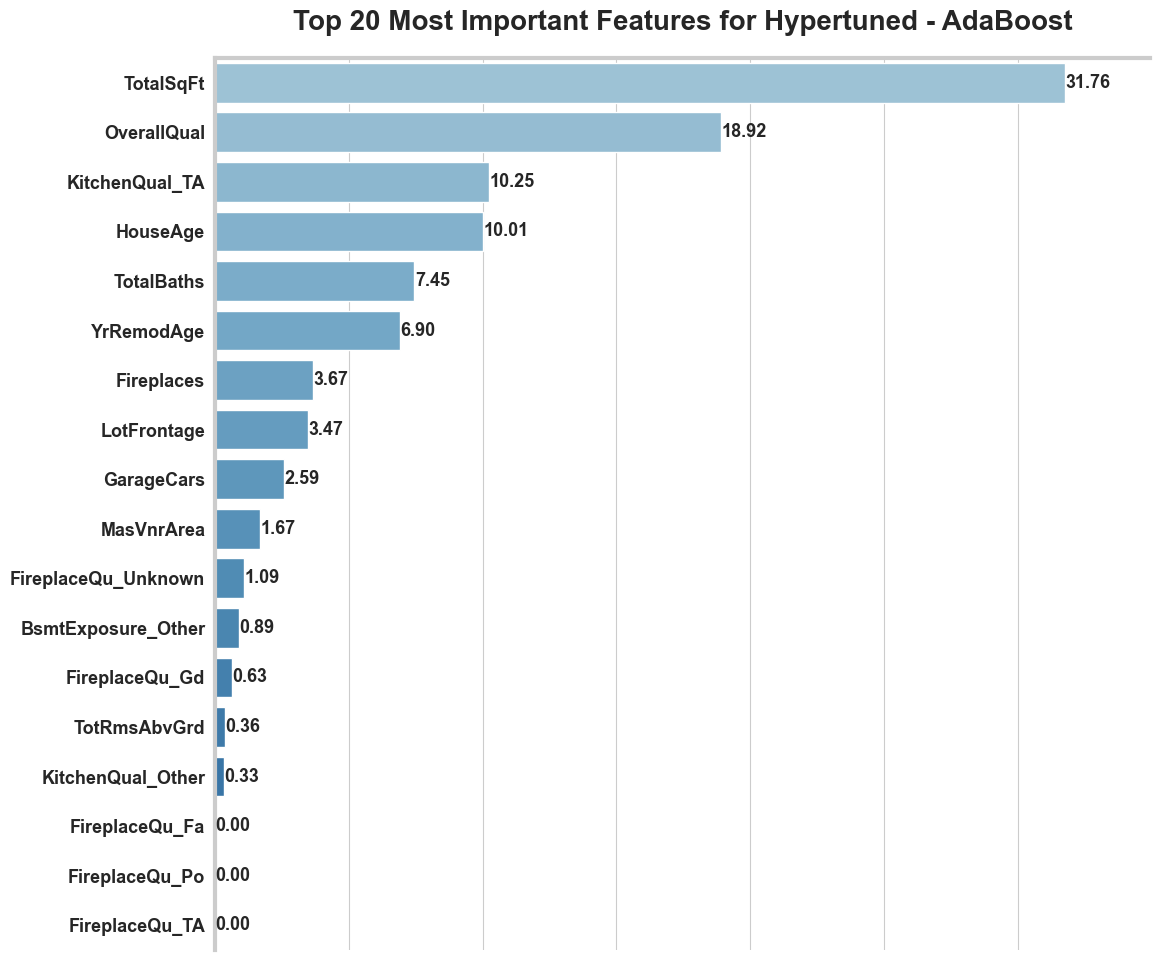

2024-10-31 12:55:42,892 - __main__ - INFO - 
=== Creating Ensemble Predictions ===
2024-10-31 12:55:42,892 - __main__ - INFO - Model weights:
2024-10-31 12:55:42,892 - __main__ - INFO -   CatBoost: 0.250
2024-10-31 12:55:42,892 - __main__ - INFO -   LightGBM: 0.250
2024-10-31 12:55:42,892 - __main__ - INFO -   RandomForest: 0.250
2024-10-31 12:55:42,892 - __main__ - INFO -   AdaBoost: 0.250
2024-10-31 12:55:42,909 - __main__ - INFO - 
Saving hypertuned models...
2024-10-31 12:55:42,909 - __main__ - INFO - Saved hypertuned model: CatBoost_hypertuned_20241031_1236.pkl
2024-10-31 12:55:42,929 - __main__ - INFO - Saved hypertuned model: LightGBM_hypertuned_20241031_1236.pkl
2024-10-31 12:55:42,950 - __main__ - INFO - Saved hypertuned model: RandomForest_hypertuned_20241031_1236.pkl
2024-10-31 12:55:42,958 - __main__ - INFO - Saved hypertuned model: AdaBoost_hypertuned_20241031_1236.pkl
2024-10-31 12:55:42,959 - __main__ - INFO - Pipeline completed successfully
2024-10-31 12:55:42,985 - __m


=== House Price Prediction Pipeline Summary ===

Model Performance Metrics:
       Model Train R2 Test R2  Train MAE   Test MAE  Train MAPE  Test MAPE Training Time                                                                                                                                                                                                                                                          Best Parameters
    CatBoost   0.9362  0.9386 11091.4807 12893.8678    0.075036   0.080996         2.41s                                                         {'colsample_bylevel': 1.0, 'depth': 5, 'early_stopping_rounds': 500, 'eval_metric': 'MAE', 'iterations': 1000, 'learning_rate': 0.03, 'min_data_in_leaf': 1, 'objective': 'MAE', 'subsample': 0.9, 'verbose': 0}
    LightGBM   0.9371  0.9280  9783.1770 13702.3802    0.067831   0.087694         0.12s {'colsample_bytree': 0.9, 'learning_rate': 0.15, 'metric': 'mae', 'min_child_samples': 25, 'min_child_weight': 0.001, 'n_estim

In [89]:
import os
import time, datetime
import pickle
import logging
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional, Union
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    GridSearchCV, 
    KFold, 
    learning_curve,
    validation_curve,
    train_test_split
)
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import re
import warnings

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Constants
TRAIN_TEST_DELTA_THRESHOLD = 0.2
NUM_MODELS = 4 # Can be int, str, or None
CAT_THRESHOLD = 10   # If missing values are below this %, impute with mode
MERGE_THRESHOLD = 20  # If subcategories account for less than this %, merge to form 'Others'
CV_FOLDS = 7   # Number of cross-fold validations

# Model name mapping for convenience
MODEL_NAME_MAPPING = {
    'rf': 'RandomForest',
    'lgbm': 'LightGBM',
    'cat': 'CatBoost',
    'ada': 'AdaBoost',
    'RandomForest': 'RandomForest',
    'LightGBM': 'LightGBM',
    'CatBoost': 'CatBoost',
    'AdaBoost': 'AdaBoost'
}

# Parameter Grids (based on the adjusted default parameter we have used in training)
PARAM_GRIDS = {
    'RandomForest': {
        'max_depth': [5, 7, 9],                    # Centered around 7
        'n_estimators': [50, 100, 150],           # Centered around 100
        'min_samples_split': [2, 5],              # Default values
        'min_samples_leaf': [1, 2]                # Default values
    },
    
    'LightGBM': {
        'objective': ['regression_l1'],           # Fixed as per reference
        'metric': ['mae'],                        # Fixed as per reference
        'num_leaves': [23, 31, 39],              # Centered around 31
        'learning_rate': [0.05, 0.1, 0.15],      # Centered around 0.1
        'n_estimators': [50, 100],               # Based on reference
        'min_child_samples': [15, 20, 25],       # Centered around 20
        'min_child_weight': [1e-3],              # Fixed as per reference
        'subsample': [0.9, 1.0],                 # Near reference value
        'colsample_bytree': [0.9, 1.0],          # Near reference value
        'reg_alpha': [0.0, 0.1],                 # Near reference value
        'reg_lambda': [0.0, 0.1],                # Near reference value
        'stopping_rounds': [50]                   # Added early stopping
    },
    
    'CatBoost': {
        'iterations': [1000],                     # Fixed as per reference
        'learning_rate': [0.01, 0.03],           # Based on reference
        'depth': [5, 6, 7],                      # Centered around 6
        'subsample': [0.9, 1.0],                 # Near reference value
        'colsample_bylevel': [0.9, 1.0],         # Near reference value
        'min_data_in_leaf': [1, 2],              # Near reference value
        'verbose': [0],
        'objective': ['MAE'],                    # Fixed as per reference
        'eval_metric': ['MAE'],                  # Fixed as per reference
        'early_stopping_rounds': [500]           # As per reference
    },
    
    'AdaBoost': {
        'n_estimators': [50, 100, 150],          # Centered around 100
        'learning_rate': [0.8, 1.0, 1.2],        # Centered around 1.0
        'loss': ['linear']                       # Default value
    }
}


class DataLoader:
    """Handles data loading and initial preprocessing"""
    def __init__(self, file_path: str):
        self.file_path = file_path
        
    def load_data(self) -> pd.DataFrame:
        """Loads data from file and performs initial checks"""
        try:
            file_ext = os.path.splitext(self.file_path)[1].lower()
            
            if file_ext == '.csv':
                data = pd.read_csv(self.file_path)
            elif file_ext in ['.xlsx', '.xls']:
                data = pd.read_excel(self.file_path)
            else:
                raise ValueError(f"Unsupported file format: {file_ext}")
                
            logger.info(f"Loaded {len(data)} rows and {len(data.columns)} columns")
            return data
            
        except Exception as e:
            logger.error(f"Error loading data: {str(e)}")
            raise

class ColumnProcessor:
    """Handles column normalization and validation"""
    @staticmethod
    def normalize_column_names(df: pd.DataFrame) -> pd.DataFrame:
        """Normalizes column names by removing spaces and special characters"""
        df_copy = df.copy()
        df_copy.columns = [re.sub(r'[^a-zA-Z0-9]', '', col.strip()) for col in df_copy.columns]
        return df_copy

class FeaturePreprocessor(BaseEstimator, TransformerMixin):
    """Handles initial feature preprocessing including handling missing values and merging categories."""
    
    def __init__(
        self, 
        numeric_features: List[str], 
        categorical_features: List[str], 
        cat_threshold: float = CAT_THRESHOLD,
        merge_threshold: float = MERGE_THRESHOLD
    ):
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.cat_threshold = cat_threshold
        self.merge_threshold = merge_threshold
        self.num_imputer = SimpleImputer(strategy='median')
        self.cat_modes = {}
        self.category_maps = {}

    def fit(self, X, y=None):
        """Learn preprocessing parameters from training data."""
        data = X.copy()
        
        # Fit numeric imputer
        numeric_data = data[self.numeric_features].copy()
        self.num_imputer.fit(numeric_data)
        
        # Learn categorical handling parameters
        for col in self.categorical_features:
            if col in data.columns:
                missing_ratio = data[col].isnull().mean() * 100
                
                if missing_ratio > self.cat_threshold:
                    unique_cats = list(data[col].dropna().unique())
                    self.category_maps[col] = unique_cats + ['Unknown']
                else:
                    self.cat_modes[col] = data[col].mode()[0]
                    value_counts = data[col].value_counts(normalize=True) * 100
                    keep_categories = value_counts[value_counts >= self.merge_threshold].index.tolist()
                    
                    if any(value_counts < self.merge_threshold):
                        keep_categories.append('Other')
                    
                    self.category_maps[col] = keep_categories
                    
                    logger.info(f"\nColumn: {col}")
                    logger.info(f"Categories to keep: {keep_categories}")
                    logger.info(f"Number of categories after merging: {len(keep_categories)}")

        return self

    def transform(self, X):
        """Apply preprocessing to features."""
        data = X.copy()
        
        # Transform numeric features
        numeric_data = data[self.numeric_features].copy()
        data[self.numeric_features] = self.num_imputer.transform(numeric_data)
        
        # Transform categorical features
        for col in self.categorical_features:
            if col in data.columns:
                missing_ratio = data[col].isnull().mean() * 100
                
                if missing_ratio > self.cat_threshold:
                    data[col] = data[col].fillna('Unknown')
                else:
                    data[col] = data[col].fillna(self.cat_modes[col])
                    
                    # Map values using comprehensive logic
                    known_categories = set(self.category_maps[col])
                    data[col] = data[col].apply(
                        lambda x: (x if x in known_categories else 'Other')
                        if 'Other' in known_categories
                        else (x if x in known_categories else next(iter(known_categories)))
                    )

        return data

    def get_feature_names(self, pipeline) -> Dict[str, List[str]]:
        """Get feature names after preprocessing and one-hot encoding"""
        try:
            categorical_encoded = []
            for col in self.categorical_features:
                if col in self.category_maps:
                    categories = self.category_maps[col][1:]
                    encoded_names = [f"{col}_{cat}" for cat in categories]
                    categorical_encoded.extend(encoded_names)
                    
                    logger.info(f"\nEncoding for {col}:")
                    logger.info(f"Original categories: {self.category_maps[col]}")
                    logger.info(f"Encoded features: {encoded_names}")

            feature_engineer = pipeline.named_steps['feature_engineering']
            engineered_features = feature_engineer.engineered_features if hasattr(feature_engineer, 'engineered_features') else []
            
            numeric_features = [f for f in self.numeric_features if f not in feature_engineer.features_to_drop]
            numeric_features.extend(engineered_features)
            
            feature_info = {
                'numeric_features': numeric_features,
                'categorical_features': categorical_encoded,
                'total_features': len(numeric_features) + len(categorical_encoded)
            }
            
            logger.info("\n=== Final Feature Counts ===")
            logger.info(f"Numeric features: {len(numeric_features)}")
            logger.info(f"Categorical features (encoded): {len(categorical_encoded)}")
            logger.info(f"Total features: {feature_info['total_features']}")
            
            return feature_info
            
        except Exception as e:
            logger.error(f"Error getting feature names: {str(e)}")
            raise

class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Creates new features and removes original features used in engineering"""
    def __init__(self):
        self.original_features = None
        self.engineered_features = None
        self.features_to_drop = None
        
    def fit(self, X, y=None):
        """Identify features to be created and dropped"""
        X = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        
        self.original_features = X.columns.tolist()
        self.engineered_features = []
        self.features_to_drop = set()
        
        feature_combinations = [
            (['GrLivArea', 'TotalBsmtSF'], 'TotalSqFt'),
            (['YrSold', 'YearBuilt'], 'HouseAge'),
            (['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], 'TotalBaths'),
            (['YrSold', 'YearRemodAdd'], 'YrRemodAge')
        ]
        
        for required_cols, new_feature in feature_combinations:
            if all(col in X.columns for col in required_cols):
                self.engineered_features.append(new_feature)
                self.features_to_drop.update(required_cols)
        
        logger.info("\n=== Feature Engineering Information ===")
        logger.info(f"Original features to be dropped: {list(self.features_to_drop)}")
        logger.info(f"New engineered features: {self.engineered_features}")
        
        return self

    def transform(self, X):
        """Apply feature engineering transformations"""
        X = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        data = X.copy()
        
        # Total Square Footage
        if all(col in data.columns for col in ['GrLivArea', 'TotalBsmtSF']):
            data['TotalSqFt'] = data['GrLivArea'].astype(float) + data['TotalBsmtSF'].fillna(0).astype(float)
        
        # House Age
        if all(col in data.columns for col in ['YrSold', 'YearBuilt']):
            data['HouseAge'] = abs(data['YrSold'].astype(float) - data['YearBuilt'].astype(float))
        
        # Total Bathrooms
        bathroom_cols = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']
        if all(col in data.columns for col in bathroom_cols):
            data['TotalBaths'] = (
                data['FullBath'].astype(float) + 
                0.5 * data['HalfBath'].fillna(0).astype(float) + 
                data['BsmtFullBath'].fillna(0).astype(float) + 
                0.5 * data['BsmtHalfBath'].fillna(0).astype(float)
            )
        
        # Years since remodeling
        if all(col in data.columns for col in ['YrSold', 'YearRemodAdd']):
            data['YrRemodAge'] = abs(data['YrSold'].astype(float) - data['YearRemodAdd'].astype(float))
        
        data = data.drop(columns=list(self.features_to_drop), errors='ignore')
        
        return data

class ModelTrainer:
    """Handles model training and evaluation"""
    def __init__(self):
        self.models = {
            'RandomForest': RandomForestRegressor(
                max_depth=7,
                n_estimators=100,
                random_state=42
            ),
            'LightGBM': LGBMRegressor(
                objective='regression_l1',
                metric='mae',
                num_leaves=31,
                learning_rate=0.1,
                n_estimators=50,
                min_child_samples=20,
                min_child_weight=1e-3,
                subsample=1.0,
                colsample_bytree=1.0,
                reg_alpha=0.0,
                reg_lambda=0.0
            ),
            'CatBoost': CatBoostRegressor(
                iterations=1000,
                learning_rate=0.01,
                depth=6,
                subsample=1.0,
                colsample_bylevel=1.0,
                min_data_in_leaf=1,
                verbose=0,
                objective="MAE",
                eval_metric="MAE",
                early_stopping_rounds=500
            ),
            'AdaBoost': AdaBoostRegressor(
                n_estimators=100,
                learning_rate=1.0
            )
        }
        
    def train_and_evaluate(
        self, 
        X_train: np.ndarray, 
        y_train: np.ndarray, 
        X_test: np.ndarray, 
        y_test: np.ndarray
    ) -> pd.DataFrame:
        """Trains multiple models and evaluates their performance"""
        results = []
        
        for name, model in self.models.items():
            start_time = time.time()
            
            model.fit(X_train, y_train)
            # Make predictions
            train_preds = model.predict(X_train)
            test_preds = model.predict(X_test)
            
            # Calculate metrics
            train_mae = mean_absolute_error(y_train, train_preds)
            test_mae = mean_absolute_error(y_test, test_preds)
            train_r2 = r2_score(y_train, train_preds)
            test_r2 = r2_score(y_test, test_preds)
            train_mape = mean_absolute_percentage_error(y_train, train_preds)
            test_mape = mean_absolute_percentage_error(y_test, test_preds)
            
            # Record results
            results.append({
                'Model': name,
                'Train MAE': train_mae,
                'Test MAE': test_mae,
                'Train R2': train_r2,
                'Test R2': test_r2,
                'Train MAPE': train_mape,
                'Test MAPE': test_mape,
                'Training Time': f"{time.time() - start_time:.2f}s"
            })
            
            logger.info(f"Trained {name}")
            
        return pd.DataFrame(results)

class ModelHypertuner:
    """Handles model hyperparameter tuning and validation analysis"""
    def __init__(
        self, 
        models: Dict,
        param_grids: Optional[Dict] = None,
        train_test_delta_threshold: float = TRAIN_TEST_DELTA_THRESHOLD,
        n_best_models: Optional[Union[int, str, List[str]]] = NUM_MODELS,
        cv_folds: int = CV_FOLDS,
        scoring: str = 'r2',
        n_jobs: int = -1
    ):
        self.models = models
        self.param_grids = param_grids or PARAM_GRIDS
        self.delta_threshold = train_test_delta_threshold
        self.models_to_select = n_best_models
        self.cv_folds = cv_folds
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.best_models = {}
        self.cv_results = {}
        self.tuned_models = {}

    def _get_model_name(self, name: str) -> str:
        """Convert potential shorthand model names to full names"""
        return MODEL_NAME_MAPPING.get(name, name)

    def _filter_models(self) -> Dict:
        """Filter models based on models_to_select parameter"""
        if self.models_to_select is None:
            return self.models
            
        if isinstance(self.models_to_select, int):
            return self.models
            
        if isinstance(self.models_to_select, str):
            model_name = self._get_model_name(self.models_to_select)
            if model_name not in self.models:
                raise ValueError(f"Model {model_name} not found in available models")
            return {model_name: self.models[model_name]}
            
        if isinstance(self.models_to_select, (list, tuple)):
            selected_models = {}
            for name in self.models_to_select:
                model_name = self._get_model_name(name)
                if model_name not in self.models:
                    raise ValueError(f"Model {model_name} not found in available models")
                selected_models[model_name] = self.models[model_name]
            return selected_models
            
        raise ValueError("Invalid models_to_select parameter")

    def select_best_models(
        self, 
        X_train: np.ndarray, 
        y_train: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray
    ) -> Dict:
        """Select best models based on performance metrics or specification"""
        available_models = self._filter_models()
        model_scores = []

        for name, model in available_models.items():
            model.fit(X_train, y_train)
            
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            train_mae = mean_absolute_error(y_train, y_train_pred)
            test_mae = mean_absolute_error(y_test, y_test_pred)
            train_r2 = r2_score(y_train, y_train_pred)
            test_r2 = r2_score(y_test, y_test_pred)
            r2_score_delta = abs(train_r2 - test_r2)

            model_scores.append({
                'name': name,
                'model': model,
                'train_r2': train_r2,
                'test_r2': test_r2,
                'train_mae': train_mae,
                'test_mae': test_mae,
                'r2_score_delta': r2_score_delta
            })

        if isinstance(self.models_to_select, (str, list, tuple)):
            self.best_models = available_models
        else:
            valid_models = [
                model for model in model_scores 
                if model['r2_score_delta'] <= self.delta_threshold
            ]

            if not valid_models:
                logger.warning(
                    f"No models found with train-test delta below {self.delta_threshold}. "
                    "Using all models."
                )
                valid_models = model_scores

            valid_models.sort(key=lambda x: x['test_r2'], reverse=True)
            n_models = self.models_to_select if isinstance(self.models_to_select, int) else 2
            selected_models = valid_models[:n_models]
            
            self.best_models = {
                model['name']: model['model'] for model in selected_models
            }

        logger.info(f"\nSelected {len(self.best_models)} models for hypertuning:")
        for name, model in self.best_models.items():
            score = next(s for s in model_scores if s['name'] == name)
            logger.info(
                f"Model: {name}, "
                f"Train R2: {score['train_r2']:.4f}, "
                f"Test R2: {score['test_r2']:.4f}, "
                f"Train MAE: {score['train_mae']:.4f}, "
                f"Test MAE: {score['test_mae']:.4f}, "
                f"  R2 Score Delta: {score['r2_score_delta']:.4f}"
            )

        return self.best_models

    def tune_hyperparameters(
        self,
        X: np.ndarray,
        y: np.ndarray
    ) -> Dict:
        """Perform hyperparameter tuning using GridSearchCV"""
        logger.info("Starting hyperparameter tuning...")
        
        for name, model in self.best_models.items():
            if name not in self.param_grids:
                logger.warning(f"No parameter grid defined for {name}. Skipping tuning.")
                continue
                
            logger.info(f"Tuning {name}...")
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=self.param_grids[name],
                cv = self.cv_folds,
                scoring = self.scoring,
                n_jobs = self.n_jobs,
                verbose = 0
            )
            
            grid_search.fit(X, y)
            
            self.tuned_models[name] = grid_search.best_estimator_
            self.cv_results[name] = pd.DataFrame(grid_search.cv_results_)
            
            logger.info(
                f"Best parameters for {name}: {grid_search.best_params_}\n"
                f"Best score: {grid_search.best_score_:.4f}"
            )
        
        return self.tuned_models

    def plot_learning_curves(
        self,
        X: np.ndarray,
        y: np.ndarray,
        train_sizes: np.ndarray = np.linspace(0.1, 1.0, 5)
    ) -> None:
        """Plot learning curves for each selected model"""
        plt.figure(figsize=(15, 6 * len(self.best_models)))
        
        for idx, (name, model) in enumerate(self.best_models.items(), 1):
            train_sizes_abs, train_scores, test_scores = learning_curve(
                estimator=model,
                X=X,
                y=y,
                train_sizes=train_sizes,
                cv=self.cv_folds,
                n_jobs=self.n_jobs,
                scoring=self.scoring
            )
            
            train_mean = np.mean(train_scores, axis=1)
            train_std = np.std(train_scores, axis=1)
            test_mean = np.mean(test_scores, axis=1)
            test_std = np.std(test_scores, axis=1)
            
            plt.subplot(len(self.best_models), 1, idx)
            
            plt.plot(train_sizes_abs, train_mean, label='Training score')
            plt.plot(train_sizes_abs, test_mean, label='Cross-validation score')
            
            plt.fill_between(
                train_sizes_abs,
                train_mean - train_std,
                train_mean + train_std,
                alpha=0.1
            )
            plt.fill_between(
                train_sizes_abs,
                test_mean - test_std,
                test_mean + test_std,
                alpha=0.1
            )
            
            plt.title(f'Learning Curves - {name}')
            plt.xlabel('Training Examples')
            plt.ylabel(f'Score ({self.scoring.title()})')
            plt.legend(loc='best')
            plt.grid(True)
        
        plt.tight_layout()
        plt.show()

    def get_cv_summary(self) -> pd.DataFrame:
        """Generate a summary of cross-validation results"""
        summary_data = []
        
        for name, cv_result in self.cv_results.items():
            best_idx = cv_result['rank_test_score'].argmin()
            
            summary_data.append({
                'Model': name,
                'Best Score': cv_result.loc[best_idx, 'mean_test_score'],
                'Std Score': cv_result.loc[best_idx, 'std_test_score'],
                'Best Parameters': cv_result.loc[best_idx, 'params']
            })
        
        return pd.DataFrame(summary_data)

class TunedModelTrainer:
    """Handles training of models using hypertuned parameters"""
    
    def __init__(self):
        self.best_models = {}
        self.model_predictions = {}
        self.performance_metrics = {}
        self.feature_names = None
        
    def set_feature_names(self, pipeline, original_features: List[str]):
        """Set feature names based on the preprocessing pipeline and original features"""
        try:
            final_preprocessor = pipeline.named_steps.get('final_preprocessing')
            if not final_preprocessor:
                logger.warning("Could not find final preprocessing step in pipeline")
                return
                
            numeric_features = final_preprocessor.named_transformers_['num'].get_feature_names_out()
            categorical_features = final_preprocessor.named_transformers_['cat'].get_feature_names_out()
            
            self.feature_names = np.concatenate([numeric_features, categorical_features])
            
            logger.info(f"\nFeature names set: {len(self.feature_names)} features")
            
        except Exception as e:
            logger.error(f"Error setting feature names: {str(e)}")
            self.feature_names = [f"feature_{i}" for i in range(100)]

    def get_feature_importance(self, model_name: str) -> Optional[pd.DataFrame]:
        """Get feature importance for a specific model"""
        if model_name not in self.best_models:
            logger.warning(f"Model {model_name} not found in trained models")
            return None
            
        model = self.best_models[model_name]
        
        try:
            # Get default feature names if none are set
            if self.feature_names is None:
                feature_names = [f"feature_{i}" for i in range(100)]
            else:
                feature_names = self.feature_names
            
            # Get feature importances
            if hasattr(model, 'feature_importances_'):
                # Normalize feature importances to sum to 100
                importance = model.feature_importances_
                importance = (importance / importance.sum()) * 100  # Convert to percentage
            elif hasattr(model, 'coef_'):
                importance = np.abs(model.coef_)
                # If 2D array, take mean across rows
                if isinstance(importance, np.ndarray) and importance.ndim > 1:
                    importance = np.mean(importance, axis=0)
                # Normalize coefficients to sum to 100
                importance = (importance / importance.sum()) * 100  # Convert to percentage
            else:
                logger.warning(f"Feature importance not available for {model_name}")
                return None
            
            # Ensure lengths match
            n_features = len(importance)
            if len(feature_names) > n_features:
                feature_names = feature_names[:n_features]
            elif len(feature_names) < n_features:
                feature_names.extend([f"feature_{i}" for i in range(len(feature_names), n_features)])
            
            # Create DataFrame
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importance.astype(float)  # Values are already percentages
            })
            
            # Sort by importance value
            importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
            
            # Add relative importance (which is the same as Importance since we normalized)
            importance_df['Relative Importance (%)'] = importance_df['Importance']
            
            return importance_df
        
        except Exception as e:
            logger.error(f"Error getting feature importance: {str(e)}")
            return None
                
    def train_with_tuned_params(
        self,
        cv_results: Dict,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        models: Dict,
        pipeline = None,
        original_features: List[str] = None
    ) -> Tuple[Dict, pd.DataFrame]:
        """Train models using the best parameters found from GridSearchCV"""
        if pipeline and original_features:
            self.set_feature_names(pipeline, original_features)
        
        metrics_list = []
        
        if not cv_results:
            logger.warning("No CV results provided. Using default parameters.")
            for model_name, model in models.items():
                self._train_single_model(
                    model_name, model, model.get_params(),
                    X_train, y_train, X_test, y_test, metrics_list
                )
        else:
            for model_name, model_cv_results in cv_results.items():
                if model_name not in models:
                    continue
                    
                if isinstance(model_cv_results, pd.DataFrame) and 'params' in model_cv_results.columns:
                    best_idx = model_cv_results['rank_test_score'].argmin()
                    best_params = model_cv_results.loc[best_idx, 'params']
                else:
                    best_params = models[model_name].get_params()
                
                self._train_single_model(
                    model_name, models[model_name], best_params,
                    X_train, y_train, X_test, y_test, metrics_list
                )
        
        if not self.model_predictions:
            raise ValueError("No models were successfully trained")
            
        return self.best_models, pd.DataFrame(metrics_list)

    def _train_single_model(
        self,
        model_name: str,
        base_model,
        params: Dict,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        metrics_list: List
    ):
        """Helper method to train a single model and record metrics"""
        try:
            logger.info(f"\nTraining {model_name} with parameters:")
            for param, value in params.items():
                logger.info(f"  {param}: {value}")
            
            # Create and train model
            start_time = time.time()
            model = type(base_model)(**params)
            model.fit(X_train, y_train)
            training_time = time.time() - start_time
            
            # Make predictions
            train_pred = model.predict(X_train)
            test_pred = model.predict(X_test)
            
            # Store model and predictions
            self.best_models[model_name] = model
            self.model_predictions[model_name] = {
                'train': train_pred,
                'test': test_pred
            }
            
            # Calculate metrics
            metrics = {
                'Model': model_name,
                'Train R2': r2_score(y_train, train_pred),
                'Test R2': r2_score(y_test, test_pred),
                'Train MAE': mean_absolute_error(y_train, train_pred),
                'Test MAE': mean_absolute_error(y_test, test_pred),
                'Train MAPE': mean_absolute_percentage_error(y_train, train_pred),
                'Test MAPE': mean_absolute_percentage_error(y_test, test_pred),
                'Training Time': f"{training_time:.2f}s",
                'Best Parameters': params
            }
            
            metrics_list.append(metrics)
            self.performance_metrics[model_name] = metrics
            
            logger.info(f"Successfully trained {model_name}")
            logger.info(f"Training time: {training_time:.2f}s")
            logger.info(f"Test R2: {metrics['Test R2']:.4f}")
            logger.info(f"Test MAE: {metrics['Test MAE']:.4f}")
            
        except Exception as e:
            logger.error(f"Error training {model_name}: {str(e)}")
    
    def get_ensemble_predictions(
        self,
        weights: Optional[Dict[str, float]] = None
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Create weighted ensemble predictions from tuned models"""
        if not self.model_predictions:
            raise ValueError("No model predictions available. Train models first.")
            
        if weights is None:
            weights = {
                model_name: 1/len(self.model_predictions) 
                for model_name in self.model_predictions.keys()
            }
            
        if set(weights.keys()) != set(self.model_predictions.keys()):
            raise ValueError("Weights must be provided for all models")
            
        first_model = next(iter(self.model_predictions.values()))
        train_pred = np.zeros_like(first_model['train'])
        test_pred = np.zeros_like(first_model['test'])
        
        logger.info("\n=== Creating Ensemble Predictions ===")
        logger.info("Model weights:")
        for model_name, weight in weights.items():
            logger.info(f"  {model_name}: {weight:.3f}")
            train_pred += weight * self.model_predictions[model_name]['train']
            test_pred += weight * self.model_predictions[model_name]['test']
            
        return train_pred, test_pred

def load_model(model_path: str) -> object:
    """Load a specific model from file"""
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    return model

def list_saved_models(model_dir: str = './models') -> pd.DataFrame:
    """List all saved models with their details"""
    if not os.path.exists(model_dir):
        return pd.DataFrame()
    
    models_info = []
    for filename in os.listdir(model_dir):
        if filename.endswith('.pkl'):
            name_parts = filename.replace('.pkl', '').split('_')
            model_name = name_parts[0]
            model_type = name_parts[1]
            timestamp = '_'.join(name_parts[2:])
            
            models_info.append({
                'Model Name': model_name,
                'Type': model_type,
                'Timestamp': timestamp,
                'Filename': filename,
                'Path': os.path.join(model_dir, filename)
            })
    
    return pd.DataFrame(models_info)

class HousePricePipeline:
    """Main pipeline class that orchestrates the house price prediction process"""
    def __init__(self, file_path: str):
        self.file_path = file_path
        self.data_loader = DataLoader(file_path)
        self.column_processor = ColumnProcessor()
        
        # Define feature groups
        self.engineering_features = [
            'GrLivArea', 'TotalBsmtSF',
            'YrSold', 'YearBuilt',
            'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath',
            'YearRemodAdd'
        ]
        
        self.original_numeric_features = [
            'OverallQual',
            'TotRmsAbvGrd',
            'GarageCars',
            'Fireplaces',
            'LotFrontage',
            'MasVnrArea'
        ]
        
        self.engineered_features = [
            'TotalSqFt',
            'HouseAge',
            'TotalBaths',
            'YrRemodAge'
        ]
        
        self.numeric_features = self.original_numeric_features + self.engineered_features
        
        self.categorical_features = [
            'Neighborhood',
            'FireplaceQu',
            'KitchenQual',
            'BsmtExposure'
        ]

    def create_preprocessing_pipeline(self) -> Pipeline:
        """Creates the preprocessing pipeline"""
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())
        ])
        
        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(
                drop='first',
                sparse_output=False,
                handle_unknown='ignore'
            ))
        ])
        
        initial_numeric_features = list(set(
            self.engineering_features + 
            [f for f in self.numeric_features if f not in self.engineered_features]
        ))
        
        initial_preprocessor = FeaturePreprocessor(
            numeric_features=initial_numeric_features,
            categorical_features=self.categorical_features
        )
        
        final_preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, self.numeric_features),
                ('cat', categorical_transformer, self.categorical_features)
            ],
            remainder='drop'
        )
        
        return Pipeline([
            ('initial_preprocessing', initial_preprocessor),
            ('feature_engineering', FeatureEngineer()),
            ('final_preprocessing', final_preprocessor)
        ])

    def _perform_cross_validation(
        self,
        model,
        model_name: str,
        X: np.ndarray,
        y: np.ndarray
    ) -> Dict:
        """Perform k-fold cross-validation for a single model"""
        kf = KFold(n_splits = CV_FOLDS, shuffle = True, random_state=42)
        cv_results = {
            'fold_scores': [],
            'train_scores': [],
            'val_scores': [],
            'train_mae': [],
            'val_mae': []
        }
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            # Split data
            X_fold_train = X[train_idx]
            X_fold_val = X[val_idx]
            y_fold_train = y.iloc[train_idx]
            y_fold_val = y.iloc[val_idx]
            
            # Train model
            fold_model = clone(model)
            fold_model.fit(X_fold_train, y_fold_train)
            
            # Get predictions
            train_pred = fold_model.predict(X_fold_train)
            val_pred = fold_model.predict(X_fold_val)
            
            # Calculate metrics
            train_r2 = r2_score(y_fold_train, train_pred)
            val_r2 = r2_score(y_fold_val, val_pred)
            train_mae = mean_absolute_error(y_fold_train, train_pred)
            val_mae = mean_absolute_error(y_fold_val, val_pred)
            
            # Store results
            cv_results['fold_scores'].append({
                'fold': fold,
                'train_r2': train_r2,
                'val_r2': val_r2,
                'train_mae': train_mae,
                'val_mae': val_mae
            })
            cv_results['train_scores'].append(train_r2)
            cv_results['val_scores'].append(val_r2)
            cv_results['train_mae'].append(train_mae)
            cv_results['val_mae'].append(val_mae)
            
            logger.info(f"\nFold {fold} Results for {model_name}:")
            logger.info(f"Train R2: {train_r2:.4f}")
            logger.info(f"Validation R2: {val_r2:.4f}")
            logger.info(f"Train MAE: {train_mae:.4f}")
            logger.info(f"Validation MAE: {val_mae:.4f}")
        
        # Calculate averages
        cv_results.update({
            'train_mean_r2': np.mean(cv_results['train_scores']),
            'train_std_r2': np.std(cv_results['train_scores']),
            'val_mean_r2': np.mean(cv_results['val_scores']),
            'val_std_r2': np.std(cv_results['val_scores']),
            'train_mean_mae': np.mean(cv_results['train_mae']),
            'val_mean_mae': np.mean(cv_results['val_mae'])
        })
        
        return cv_results

    def plot_cv_results(self, cv_results: Dict[str, Dict]) -> None:
        """Plot cross-validation results for each model"""
        for model_name, results in cv_results.items():
            plt.figure(figsize=(20, 14))
            
            # Create fold numbers for x-axis
            fold_numbers = np.arange(1, len(results['train_scores']) + 1)
            
            # Plot R² scores
            plt.subplot(2, 1, 1)
            plt.plot(fold_numbers, results['train_scores'], 'o-', label='Train R2')
            plt.plot(fold_numbers, results['val_scores'], 'o-', label='Validation R2')
            plt.axhline(y=results['train_mean_r2'], color='b', linestyle='--', alpha=0.5, 
                    label=f'Mean Train R2: {results["train_mean_r2"]:.3f}')
            plt.axhline(y=results['val_mean_r2'], color='orange', linestyle='--', alpha=0.5,
                    label=f'Mean Val R2: {results["val_mean_r2"]:.3f}')
            plt.title(f'{model_name} Cross-Validation Scores')
            plt.xlabel('Fold Number')
            plt.ylabel('R2 Score')
            plt.xticks(fold_numbers)
            plt.legend()
            plt.grid(True)
            
            # Plot MAE scores
            plt.subplot(2, 1, 2)
            plt.plot(fold_numbers, results['train_mae'], 'o-', label='Train MAE')
            plt.plot(fold_numbers, results['val_mae'], 'o-', label='Validation MAE')
            plt.axhline(y=results['train_mean_mae'], color='b', linestyle='--', alpha=0.5,
                    label=f'Mean Train MAE: {results["train_mean_mae"]:.3f}')
            plt.axhline(y=results['val_mean_mae'], color='orange', linestyle='--', alpha=0.5,
                    label=f'Mean Val MAE: {results["val_mean_mae"]:.3f}')
            plt.xlabel('Fold Number')
            plt.ylabel('MAE')
            plt.xticks(fold_numbers)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    def plot_feature_importance(self, importance_df: pd.DataFrame, model_name: str) -> None:
        """Plot feature importance for a given model with custom formatting"""
        # Sort and take top 20 features
        top_features = importance_df.sort_values(by='Importance', ascending = False).head(20)

        # Set the style and color palette
        palette = plt.cm.Blues(np.linspace(0.4, 0.8, len(top_features)))
        sns.set_style('whitegrid')

        # Create the plot
        plt.figure(figsize=(12, 10))
        ax = sns.barplot(
            x='Importance', 
            y='Feature', 
            data=top_features, 
            palette= palette
        )

        # Customize the plot
        plt.title(f'Top 20 Most Important Features for Hypertuned - {model_name}', fontweight='bold')
        plt.xlabel(None)
        plt.ylabel(None)

        # Make x-ticks invisible
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        # Add value labels to the end of each bar
        for i, v in enumerate(top_features['Importance']):
            ax.text(v + 0.015, i, f'{v:.2f}', va='center', fontsize=13)

        # Extend x-axis by 10% and feature names font size
        plt.xlim(0, max(top_features['Importance']) * 1.1)
        plt.yticks(fontsize=13)

        # Hide all plot spines but keep gridlines
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        # Adjust layout and display
        plt.tight_layout()
        plt.show()

    def run(self) -> Tuple[Dict, Dict]:
        """Runs the entire pipeline following ML workflow stages"""
        try:
            # 1. Data Loading and Preprocessing
            logger.info("Starting house price prediction pipeline...")
            data = self.data_loader.load_data()
            data = self.column_processor.normalize_column_names(data)
            
            # 2. Feature Split and Train-Test Split
            X = data.drop('SalePrice', axis = 1)
            y = data['SalePrice']
            # Calculate percentiles
            p95 = np.percentile(y, 95)

            # Replace values outside percentiles with the percentile values
            y_capped = y.copy()
            y_capped[y > p95] = p95

            X_train, X_test, y_train, y_test = train_test_split(
                X, y_capped, test_size = 0.20, random_state = 42
            )

            # 3. Feature Processing and Engineering
            preprocessing_pipeline = self.create_preprocessing_pipeline()
            X_train_processed = preprocessing_pipeline.fit_transform(X_train)
            X_test_processed = preprocessing_pipeline.transform(X_test)
            y_train = y_train.reset_index(drop=True)
            
            # Save the fitted preprocessing pipeline
            os.makedirs('./models', exist_ok=True)
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
            pipeline_path = os.path.join('./models', f'preprocessing_pipeline_{timestamp}.pkl')
            with open(pipeline_path, 'wb') as f:
                pickle.dump(preprocessing_pipeline, f)
            logger.info(f"Saved fitted preprocessing pipeline to {pipeline_path}")
            
            feature_preprocessor = preprocessing_pipeline.named_steps['initial_preprocessing']
            feature_info = feature_preprocessor.get_feature_names(preprocessing_pipeline)

            # 4. Model Training and Cross-Validation
            trainer = ModelTrainer()
            cv_results = {}
            
            for model_name, model in trainer.models.items():
                logger.info(f"\nPerforming {CV_FOLDS}-fold CV for {model_name}")
                cv_result = self._perform_cross_validation(
                    model, model_name, X_train_processed, y_train
                )
                cv_results[model_name] = cv_result
                self.plot_cv_results({model_name: cv_result})

            # 5. Model Selection and Hyperparameter Tuning
            hypertuner = ModelHypertuner(
                models=trainer.models,
                param_grids=PARAM_GRIDS,
                train_test_delta_threshold=TRAIN_TEST_DELTA_THRESHOLD,
                n_best_models=NUM_MODELS
            )
            
            best_models = hypertuner.select_best_models(
                X_train_processed, y_train,
                X_test_processed, y_test
            )
            
            hypertuner.plot_learning_curves(X_train_processed, y_train)
            tuned_models = hypertuner.tune_hyperparameters(X_train_processed, y_train)

            # 6. Final Model Training and Evaluation
            tuned_trainer = TunedModelTrainer()
            final_models, metrics = tuned_trainer.train_with_tuned_params(
                cv_results=hypertuner.cv_results,
                X_train=X_train_processed,
                y_train=y_train,
                X_test=X_test_processed,
                y_test=y_test,
                models=trainer.models,
                pipeline=preprocessing_pipeline,
                original_features=X.columns.tolist()
            )

            # 7. Feature Importance Analysis
            feature_importance = {}
            for model_name in final_models.keys():
                importance_df = tuned_trainer.get_feature_importance(model_name)
                if importance_df is not None:
                    feature_importance[model_name] = importance_df
                    self.plot_feature_importance(importance_df, model_name)

            # 8. Ensemble Predictions
            train_ensemble, test_ensemble = tuned_trainer.get_ensemble_predictions()
            
            ensemble_metrics = {
                'Model': 'Ensemble',
                'Train R2': r2_score(y_train, train_ensemble),
                'Test R2': r2_score(y_test, test_ensemble),
                'Train MAE': mean_absolute_error(y_train, train_ensemble),
                'Test MAE': mean_absolute_error(y_test, test_ensemble),
                'Training Time': 'N/A',
                'Best Parameters': 'N/A'
            }
            
            metrics = pd.concat([
                metrics,
                pd.DataFrame([ensemble_metrics])
            ], ignore_index=True)

            # 9. Save Models
            
            model_dir = './models'

            # Only save hypertuned models
            logger.info("\nSaving hypertuned models...")
            for name, model in final_models.items():
                # Only save if the model was actually tuned (exists in param_grids)
                if name in PARAM_GRIDS:
                    filename = f"{name}_hypertuned_{timestamp}.pkl"
                    path = os.path.join(model_dir, filename)
                    with open(path, 'wb') as f:
                        pickle.dump(model, f)
                    logger.info(f"Saved hypertuned model: {filename}")
                        
            logger.info("Pipeline completed successfully")
                        
            return {
                'pipeline': preprocessing_pipeline,
                'feature_info': feature_info,
                'cv_results': cv_results,
                'models': trainer.models,
                'tuned_models': final_models,
                'ensemble_predictions': (train_ensemble, test_ensemble),
                'feature_importance': feature_importance
            }, {
                'model_metrics': metrics,
                'cv_summary': hypertuner.get_cv_summary()
            }
            
        except Exception as e:
            logger.error(f"Pipeline failed: {str(e)}")
            raise

    def print_summary(self, results: Dict) -> None:
        """Print summary of pipeline results with improved formatting"""
        print("\n=== House Price Prediction Pipeline Summary ===")
        
        if 'feature_info' in results:
            print("\nFeature Information:")
            for key, value in results['feature_info'].items():
                if isinstance(value, list):
                    print(f"{key}: {len(value)} features")
                else:
                    print(f"{key}: {value}")
        
        if 'model_metrics' in results:
            print("\nModel Performance Metrics:")
            metrics_df = results['model_metrics']
            # Format numeric columns to 4 decimal places
            numeric_cols = ['Train R2', 'Test R2', 'Train MAE', 'Test MAE']
            for col in numeric_cols:
                if col in metrics_df.columns:
                    metrics_df[col] = metrics_df[col].map('{:.4f}'.format)
            print(metrics_df.to_string(index=False))
        
        print("\nModel Types Explanation:")
        print("- Hypertuned: Best performing models after extensive tuning")

def main():
    """Main function to run the pipeline"""
    warnings.filterwarnings('ignore')
    
    file_path = './data/raw_data/AmesHousing.csv'
    
    try:
        pipeline = HousePricePipeline(file_path)
        artifacts, results = pipeline.run()
        pipeline.print_summary(results)
        
        logger.info("\nSaved Model Information:")
        models_info = list_saved_models()
        if not models_info.empty:
            print(models_info.to_string(index=False))
        
        return artifacts, results
        
    except Exception as e:
        logger.error(f"Error in main execution: {str(e)}")
        raise

if __name__ == "__main__":
    main()

### Prediction on new test data set

In [90]:
def predict_on_new_data(new_data, pipeline, model):
    try:
        if isinstance(new_data, str):
            data_loader = DataLoader(new_data)
            new_data = data_loader.load_data()
        
        column_processor = ColumnProcessor()
        new_data = column_processor.normalize_column_names(new_data)
        
        transformed_data = pipeline.transform(new_data)
        
        predictions = model.predict(transformed_data)
        
        return predictions
        
    except Exception as e:
        logger.error(f"Error predicting on new data: {str(e)}")
        raise

# Usage
pipeline = load_model('./models/preprocessing_pipeline_20241031_1236.pkl')
model = load_model('./models/CatBoost_hypertuned_20241031_1236.pkl')
predictions = predict_on_new_data(X_test, pipeline, model)
predictions[0]

174568.26863020903

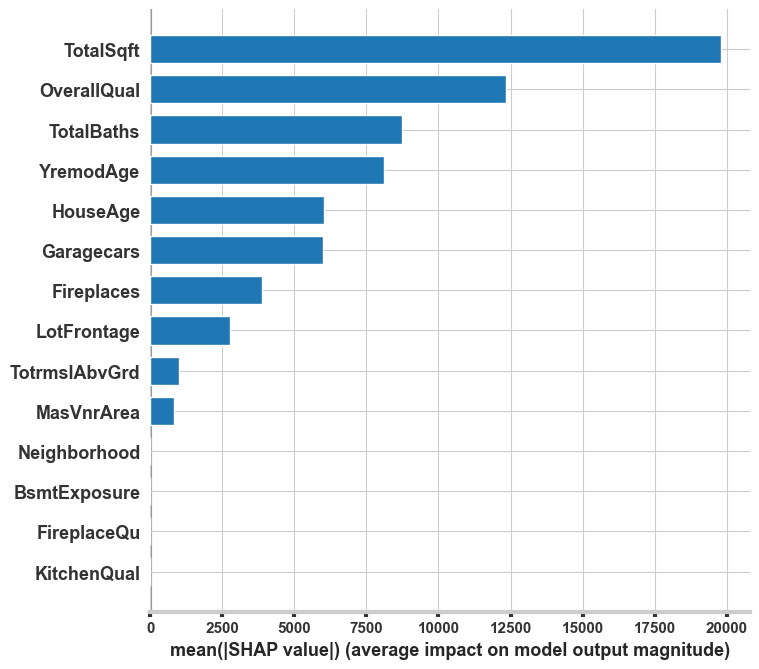

In [91]:
import shap
import re

def group_features(col):
    if re.match(r'^(BsmtExposure|KitchenQual|FireplaceQu|Neighborhood)', col):
        return col.split('_')[0]
    return col

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Preprocess test data
column_processor = ColumnProcessor()
X_test = column_processor.normalize_column_names(X_test)
X_test_transformed = pipeline.transform(X_test)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_transformed)

# Get transformed feature names
transformed_features = pipeline[-1].get_feature_names_out()

# Group SHAP values by original feature names
shap_df = pd.DataFrame(shap_values, columns=transformed_features)
shap_df.columns = shap_df.columns.map(group_features)
shap_grouped = shap_df.groupby(shap_df.columns, axis=1).sum()

# Map transformed to original feature names
feature_map = {feat: feat.split("__")[1] for feat in transformed_features}
shap_df.columns = shap_df.columns.map(feature_map)
shap_grouped = shap_df.groupby(shap_df.columns, axis=1).sum()

# Aggregate SHAP values as requested
cat_cols = [col for col in shap_grouped.columns if col.startswith('cat__')]
num_cols = [col for col in shap_grouped.columns if col.startswith('num__')]

cat_kitchenqual = shap_grouped[[col for col in cat_cols if 'KitchenQual' in col]].sum(axis=1)
cat_fireplacequ = shap_grouped[[col for col in cat_cols if 'FireplaceQu' in col]].sum(axis=1)
cat_bsmtexposure = shap_grouped[[col for col in cat_cols if 'BsmtExposure' in col]].sum(axis=1)
cat_neighborhood = shap_grouped[[col for col in cat_cols if 'Neighborhood' in col]].sum(axis=1)
num_fireplaces = shap_grouped['Fireplaces']
num_garagecars = shap_grouped['GarageCars'] 
num_houseage = shap_grouped['HouseAge']
num_lotfrontage = shap_grouped['LotFrontage']
num_masvnrarea = shap_grouped['MasVnrArea']
num_overallqual = shap_grouped['OverallQual']
num_totrmslabvgrd = shap_grouped['TotRmsAbvGrd']
num_totalbaths = shap_grouped['TotalBaths']
num_totalsqft = shap_grouped['TotalSqFt']
num_yremodage = shap_grouped['YrRemodAge']

# Create new DataFrame with the aggregated SHAP values
shap_aggregated = pd.DataFrame({
    'KitchenQual': cat_kitchenqual,
    'FireplaceQu': cat_fireplacequ,
    'BsmtExposure': cat_bsmtexposure,
    'Neighborhood': cat_neighborhood,
    'Fireplaces': num_fireplaces,
    'Garagecars': num_garagecars,
    'HouseAge': num_houseage,
    'LotFrontage': num_lotfrontage,
    'MasVnrArea': num_masvnrarea,
    'OverallQual': num_overallqual,
    'TotrmslAbvGrd': num_totrmslabvgrd,
    'TotalBaths': num_totalbaths,
    'TotalSqft': num_totalsqft,
    'YremodAge': num_yremodage
})

# Plot the aggregated SHAP values
shap.summary_plot(shap_aggregated, plot_type="bar", feature_names=shap_aggregated.columns,  color="#1F77B4")

In [173]:
# shap.initjs()
# # Assuming feature_names is your list of column names
# shap.force_plot(explainer.expected_value, 
#                 shap_values,
#                 feature_names = shap_aggregated.columns)

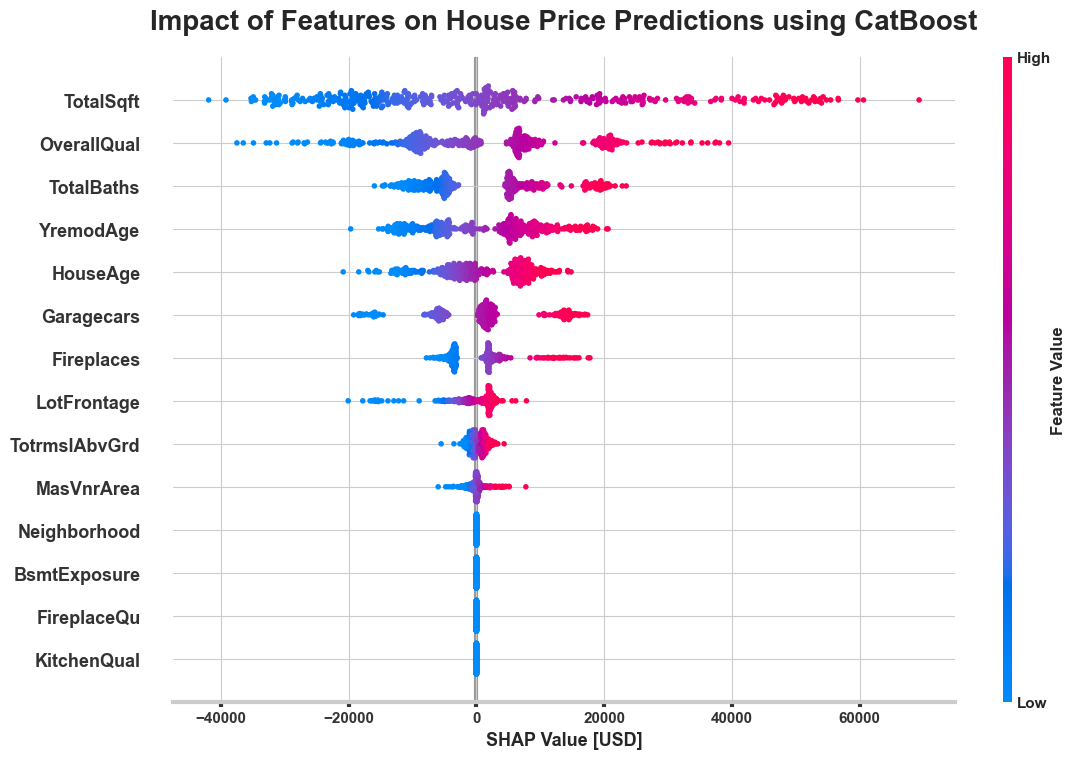

In [93]:
shap_explanation = shap.Explanation(
    values=shap_aggregated.values,
    data=shap_aggregated.values,
    feature_names=shap_aggregated.columns
)

shap.plots.beeswarm(
    shap_explanation,
    color_bar_label="Feature Value",
    max_display=14,
    plot_size=(12, 8),  # Control figure size
    show=False
)
plt.title("Impact of Features on House Price Predictions using CatBoost")
plt.xlabel("SHAP Value [USD]")
plt.tight_layout()
plt.show()

#### SHAP Value Analysis for House Price Prediction

This SHAP (SHapley Additive exPlanations) value plot shows how different features impact house price predictions using the CatBoost model.

##### 1. Most Influential Features (Top to Bottom)
- **TotalSqft**: Strongest impact on price
 - Larger values (red) increase price up to +$60,000 USD

- **OverallQual**: Second most important
 - Higher quality (red) significantly increases price

- **TotalBaths**: More bathrooms generally increase price

- **YremodAge & HouseAge**: Show mixed effects
 - Newer/recently remodeled homes (lower age, blue) generally command higher prices

##### 2. Moderate Impact Features
- **Garagecars**: More garage spaces tend to increase price
- **Fireplaces**: Presence/number shows moderate positive impact
- **LotFrontage**: Shows some impact but less significant

##### 3. Lower Impact Features
- **Categorical Features** have smaller individual impacts:
 - Neighborhood
 - BsmtExposure
 - FireplaceQu
 - KitchenQual

Note on color interpretation:
- **Red**: Higher feature values
- **Blue**: Lower feature values
- **Spread**: Shows range of impact on price predictions

This visualization helps understand feature importance and their directional impact (positive/negative) on house price predictions.

# Conclusion

Our project has successfully delivered a high-performing predictive solution using CatBoost, achieving an R² score of 0.93. The model demonstrated excellent stability in its learning curves across both training and test datasets, indicating robust generalization capabilities.

The implementation includes a fully automated end-to-end pipeline that handles preprocessing, training, and prediction generation. This pipeline can be easily retrained on new data, ensuring the model stays current and maintains its predictive power over time.

This solution provides a reliable foundation for making accurate predictions on new samples while requiring minimal manual intervention through its automated workflow.

In [77]:
shap_aggregated.columns

Index(['KitchenQual', 'FireplaceQu', 'BsmtExposure', 'Neighborhood',
       'Fireplaces', 'Garagecars', 'HouseAge', 'LotFrontage', 'MasVnrArea',
       'OverallQual', 'TotrmslAbvGrd', 'TotalBaths', 'TotalSqft', 'YremodAge'],
      dtype='object')